# Sentence selector

In [98]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import os
import glob
import itertools
import operator
import string

# scikit learn imports
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import scale, StandardScaler, Normalizer, label_binarize
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import PredefinedSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.metrics import plot_confusion_matrix


# visualization
from mlxtend.plotting import plot_confusion_matrix

import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import umap

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
#nltk.download()
from nltk import ngrams, pos_tag

# GPU configuration
#from keras.backend.tensorflow_backend import set_session
#import keras
#configtf = tf.ConfigProto()
#configtf.gpu_options.allow_growth = True
#configtf.gpu_options.visible_device_list = "3"
#set_session(tf.Session(config=configtf))

In [99]:
def plot_confMatrix(y_test, y_predicted_counts):
    
    cm = confusion_matrix(y_test, y_predicted_counts)
    classes = ['class 1', 'class 0']

    figure, ax = plot_confusion_matrix(conf_mat = cm,
                                       class_names = classes,
                                       show_absolute = False,
                                       show_normed = True,
                                       colorbar = True)
    plt.show()
    print('the confusion matrix: ', cm)

In [77]:
normalizer = Normalizer()

In [78]:
# Build sentences from the EBM-NLP dataset

# hilfiker
par_text_dir_t2 = '/home/anjani/systematicReviews/data/TA_screening/hilfiker_sr_ta/PICO_annotation_project/validation_files/tokens'
par_lab_dir_t2 = '/home/anjani/systematicReviews/data/TA_screening/hilfiker_sr_ta/PICO_annotation_project/validation_files/labels/intervention/annot'

# EBM-NLP training
par_text_dir = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/documents/train/'
par_lab_dir = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/annotations/aggregated/starting_spans/interventions/train/'

# EBM-NLP Gold
par_text_dir_t1 = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/documents/test/'
par_lab_dir_t1 = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/annotations/aggregated/starting_spans/interventions/test/gold/'

print('Number of documents: ', len([name for name in os.listdir(par_text_dir) if os.path.isfile(os.path.join(par_text_dir, name))]) /3)
print('Number of doc labels: ', len([name for name in os.listdir(par_lab_dir) if os.path.isfile(os.path.join(par_lab_dir, name))]))

Number of documents:  4802.0
Number of doc labels:  4782


In [5]:
write_file = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/allSentence_annot/hilfiker_sentence_annotation2POS.txt'

from nltk.tokenize.punkt import PunktSentenceTokenizer
import nltk, json

def getData(par_text_dir, par_lab_dir):
    all_text_files = os.listdir(par_text_dir)

    sentences_wwo_intervention = 0
    sentences_with_intervention = 0
    sentences_without_intervention = 0

    sent_w_intannot = []
    sent_w_intannotLab = []
    sent_wo_intannot = []
    sent_wo_intannotLab = []

    for i, eachFile in enumerate(all_text_files):
        if '.tokens' in eachFile or '.txt' in eachFile and '1530836' not in eachFile:

            document = os.path.join(par_text_dir, eachFile)
            if '.tokens' in eachFile:
                label_extension = '.AGGREGATED.ann'
                label = os.path.join(par_lab_dir, str(eachFile).replace('.tokens', label_extension))
            else:
                label_extension = '.txt'
                label = os.path.join(par_lab_dir, str(eachFile).replace('.txt', label_extension))

            added_length = 0
            if os.path.isfile(label):

                write_document = dict()
                token_list = []
                label_list = []
                with open(label, 'r') as labfile, open(document, 'r') as docfile:
                    for eachToken, eachTokLabel in zip(docfile, labfile):
                        string2print = eachToken.rstrip() + ' : ' + eachTokLabel.rstrip()

                        token_list.append(eachToken.rstrip())
                        label_list.append(eachTokLabel.rstrip())                    

                s = nltk.sent_tokenize(' '.join(token_list)) # converts tokens into sentences
                reSent = ' '.join(s) # joins the sentences into a passage
                retokens = reSent.split(' ')
                assert len(token_list) == len(label_list) == len(retokens)

                reformed = []

                write_sentences = dict()
                for j, eachSentence in enumerate(s):
                    words = eachSentence.split(' ')
                    reformed.extend( words )

                    fetchLab = len(words)
                    sent_lab = label_list[added_length : added_length + fetchLab]          

                    added_length = added_length + fetchLab
                    if all(p == '0' for p in sent_lab) is False:
                        #print(words)
                        write_sentences[str(j)] = [words, sent_lab, [eachTuple[1]  for eachTuple in nltk.pos_tag_sents([words])[0]]]
                        sentences_with_intervention = sentences_with_intervention + 1
                        # Remove stopwords and punctuations from the input sentence
                        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
                        words2string = ' '.join(filtered_words).lower()
                        removePunct = words2string.translate(str.maketrans('', '', string.punctuation))
                        sent_w_intannot.append( removePunct )
                        sent_w_intannotLab.append( 1 )
                    else:
                        #print('No intervention: ' , words)
                        # writes even if no annotations are found in the sentence
                        write_sentences[str(j)] = [words, sent_lab, [eachTuple[1]  for eachTuple in nltk.pos_tag_sents([words])[0]]]
                        sentences_without_intervention = sentences_without_intervention + 1
                        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
                        words2string = ' '.join(filtered_words).lower()
                        removePunct = words2string.translate(str.maketrans('', '', string.punctuation))
                        sent_wo_intannot.append( removePunct )
                        sent_wo_intannotLab.append( 0 )

                    sentences_wwo_intervention = sentences_wwo_intervention + 1

                assert len(token_list) == len(reformed)
                write_document[eachFile] = write_sentences

                #with open(write_file, 'a+') as writeAnnotfile:
                    #print(write_document)
                    #json_str = json.dumps(write_document)
                    #writeAnnotfile.write(str(json_str))
                    #writeAnnotfile.write('\n')
                #print('--------------------------------------------------------')
    print('Number of sentences with and without intervention annotation: ' , sentences_wwo_intervention)
    print('Number of sentences with intervention annotation: ' , sentences_with_intervention)
    print('Number of sentences without intervention annotation: ' , sentences_without_intervention)
    
    return sent_w_intannot, sent_w_intannotLab, sent_wo_intannot, sent_wo_intannotLab

In [6]:
# Get training data
sent_w_intannot, sent_w_intannotLab, sent_wo_intannot, sent_wo_intannotLab = getData(par_text_dir, par_lab_dir)

Number of sentences with and without intervention annotation:  51577
Number of sentences with intervention annotation:  23241
Number of sentences without intervention annotation:  28336


In [7]:
# Get test data
sent_w_intannot_t1, sent_w_intannotLab_t1, sent_wo_intannot_t1, sent_wo_intannotLab_t1 = getData(par_text_dir_t1, par_lab_dir_t1)

Number of sentences with and without intervention annotation:  2068
Number of sentences with intervention annotation:  1107
Number of sentences without intervention annotation:  961


In [8]:
sent_w_intannot_t2, sent_w_intannotLab_t2, sent_wo_intannot_t2, sent_wo_intannotLab_t2 = getData(par_text_dir_t2, par_lab_dir_t2)

Number of sentences with and without intervention annotation:  2080
Number of sentences with intervention annotation:  856
Number of sentences without intervention annotation:  1224


In [9]:
# Get training dataframe
sentsX = sent_w_intannot + sent_wo_intannot
sentsy = sent_w_intannotLab + sent_wo_intannotLab
print(len(sentsX))
print(len(sentsy))

51577
51577


In [10]:
# Get test dataframe
sentsXtest = sent_w_intannot_t1 + sent_wo_intannot_t1
sentsytest = sent_w_intannotLab_t1 + sent_wo_intannotLab_t1
print(len(sentsXtest))
print(len(sentsytest))

2068
2068


In [11]:
# Get test dataframe
sentsXtest2 = sent_w_intannot_t2 + sent_wo_intannot_t2
sentsytest2 = sent_w_intannotLab_t2 + sent_wo_intannotLab_t2
print(len(sentsXtest2))
print(len(sentsytest2))

2080
2080


In [12]:
# Construct the vocab from all the dataframes and remove all the words that are represented less than 10 times in the entire corpus

vocabulary = dict()

print('Generating vocabulary for the training set')
for eachText in sentsX:
    
    eachText = eachText.split(' ')

    # generate the vocabulary
    for t in eachText:
        if t not in vocabulary:
            vocabulary[t] = 1
        elif t in vocabulary:
            vocabulary[t] = vocabulary[t] + 1

print('Generating vocabulary for the test set 1')
for eachText in sentsXtest:
    
    eachText = eachText.split(' ')

    # generate the vocabulary
    for t in eachText:
        if t not in vocabulary:
            vocabulary[t] = 1
        elif t in vocabulary:
            vocabulary[t] = vocabulary[t] + 1

print('Generating vocabulary for the test set 2')
for eachText in sentsXtest2:
    
    eachText = eachText.split(' ')

    # generate the vocabulary
    for t in eachText:
        if t not in vocabulary:
            vocabulary[t] = 1
        elif t in vocabulary:
            vocabulary[t] = vocabulary[t] + 1
            
print('Size of vocabulary: ', len(vocabulary))

Generating vocabulary for the training set
Generating vocabulary for the test set 1
Generating vocabulary for the test set 2
Size of vocabulary:  42376


In [13]:
# Remove tokens that do not appear more than 10 times in the entire corpus
sentsXtest_reduced = [ ]

print('Reduce tokens in test set 1')
for eachText in sentsXtest:
    
    text_i = eachText.split(' ')
    sample_i = [ ]
    for t in text_i:
        if vocabulary[t] > 10:
            sample_i.append( t )
    sentsXtest_reduced.append( ' '.join(sample_i) )

Reduce tokens in test set 1


In [14]:
sentsXtest2_reduced = [ ]

print('Reduce tokens in test set 2')
for eachText in sentsXtest2:
    
    text_i = eachText.split(' ')
    sample_i = [ ]
    for t in text_i:
        if vocabulary[t] > 10:
            sample_i.append( t )
    sentsXtest2_reduced.append( ' '.join(sample_i) )

Reduce tokens in test set 2


In [15]:
sentsX_reduced = [ ]
print('Reduce tokens in training set')
for eachText in sentsX:
    
    text_i = eachText.split(' ')
    sample_i = [ ]
    for t in text_i:
        if vocabulary[t] > 10:
            sample_i.append( t )
    sentsX_reduced.append( ' '.join(sample_i) )

Reduce tokens in training set


In [16]:
assert len(sentsX) == len(sentsX_reduced) 
assert len(sentsXtest) == len(sentsXtest_reduced) == len(sentsytest)
assert len(sentsXtest2) == len(sentsXtest2_reduced) == len(sentsytest2)

In [17]:
vocabulary_reduced = {key:val for key, val in vocabulary.items() if val > 10}
print(len(vocabulary_reduced))

7648


In [20]:
df_data = pd.DataFrame(
    {'text': sentsX_reduced,
     'category': sentsy
    })

print('Dataframe with training set: ', len(df_data))

df_testdata = pd.DataFrame(
    {'text': sentsXtest_reduced,
     'category': sentsytest
    })

print('Dataframe with training set: ', len(df_testdata))


df_testdata2 = pd.DataFrame(
    {'text': sentsXtest2_reduced,
     'category': sentsytest2
    })

print('Dataframe with training set: ', len(df_testdata2))

Dataframe with training set:  51577
Dataframe with training set:  2068
Dataframe with training set:  2080


### Data exploration

In [21]:
print('Number of reports with the intervention annotation: ', list(df_data['category']).count(1))
print('Number of reports without the intervention annotation: ', list(df_data['category']).count(0))

Number of reports with the intervention annotation:  23241
Number of reports without the intervention annotation:  28336


Text(0.5,1,'Number of sentences with and without intervention annotation.')

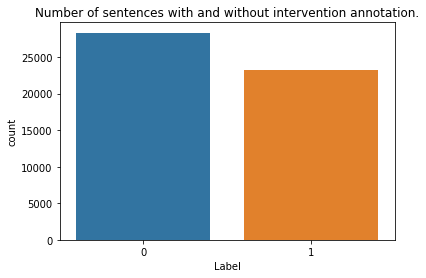

In [22]:
sns.countplot(df_data.category)
plt.xlabel('Label')
plt.title('Number of sentences with and without intervention annotation.')

### Baseline Experiments (tf-idf, no oversampling)

In [33]:
def get_param_grids(s):
    
    if 'logistic_regression' in s:
        
        param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                      'vect__max_features': (None, 4000),
                      'vect__max_df': [0.7, 0.8, 0.9],
                      'vect__min_df': [0.0, 0.1, 0.2, 0.3],
                      'vect__norm': ['l1','l2'],
                      'clf__penalty': ['l1','l2'],
                      'clf__class_weight': ['balanced', None]
              }
             ]
          
        return param_grid
    
    if 'svm' in s:      
  
        param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                       'vect__max_features': (None, 4000),
                       'vect__max_df': [0.7, 0.8, 0.9],
                       'vect__min_df': [0.0, 0.1, 0.2, 0.3],
                       'vect__norm': ['l1','l2']
                      }
                     ]
        
        return param_grid
    
    if 'knn' in s:
        
        param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                        'vect__max_features': (None, 4000),
                        'vect__max_df': [0.7, 0.8, 0.9],
                        'vect__min_df': [0.0, 0.1, 0.2, 0.3],
                        'vect__norm': ['l1','l2'],
                        'clf__n_neighbors': [9, 11, 21, 31],
                        'clf__metric': ['minkowski', 'euclidean']
              }
             ]
        
        return param_grid
    
    if 'trial' in s:
        
        param_grid = [{'clf__penalty': ['l2']
              }
             ]
        
        return param_grid
    
    else:
        raise ValueError('Please correctly specify the name of algorithm to apply...')

In [34]:
def get_classifier_pipeline(s):
    
    # Initialize vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words=None, smooth_idf=True)
    
    if 'logistic_regression' in s:
        
        log_reg_clf = LogisticRegression(intercept_scaling=1, random_state=42)
        log_reg_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('scaler', normalizer), ('clf', log_reg_clf)])
        
        return log_reg_clf_tfidf
    
    if 'svm' in s:
        
        svm_clf = CalibratedClassifierCV(base_estimator=LinearSVC(penalty = 'l2', class_weight = 'balanced', fit_intercept=False, random_state=42, verbose=1, dual=False))
        svm_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('norm', normalizer), ('clf', svm_clf)])
        
        return svm_clf_tfidf
    
    if 'knn' in s:
        
        knn_clf = KNeighborsClassifier(weights='uniform', algorithm='auto')
        knn_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('norm', normalizer), ('clf', knn_clf)])
        
        return knn_clf_tfidf
    
    if 'trial' in s:
        
        svm_clf = CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', fit_intercept=False, class_weight='balanced', random_state=42, verbose=1, dual=False))
        print(svm_clf.get_params().keys())
        svm_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('norm', normalizer), ('clf', svm_clf)])
        
        return svm_clf_tfidf
        
    else:
        raise ValueError('Please correctly specify the name of algorithm to apply...')

In [35]:
def evaluate(gridSearch, X_test, y_test):
    
    test_roc_auc = []
    
    precision_include = []
    recall_include = []
    f1_include = []

    precision_exclude = []
    recall_exclude = []
    f1_exclude = []
    
    # Using best model, predict on the test set
    print('-' * 30)
    y_pred = gridSearch.best_estimator_.predict(X_test)

    y_test = y_test.to_numpy()
    y_test = y_test.astype('int')

    ROCAUC_score = roc_auc_score(y_test, y_pred)
    print('The ROC-AUC score for the test set is: ', ROCAUC_score)
    test_roc_auc.append(ROCAUC_score)

    classReport =  classification_report(y_test, y_pred)
    print(classReport)

    ## Plot confusion matrix
    plot_confMatrix(y_test, y_pred)

    prec_scr = precision_score(y_test, y_pred, average=None)
    rec_scr = recall_score(y_test, y_pred, average=None)
    f_scr = f1_score(y_test, y_pred, average=None)

    precision_include.append(prec_scr[1])
    recall_include.append(rec_scr[1])
    f1_include.append(f_scr[1])

    precision_exclude.append(prec_scr[0])
    recall_exclude.append(rec_scr[0])
    f1_exclude.append(f_scr[0])
        
    ## Print mean scores here
    meanTrainPRU = sum(train_roc_auc)/len(train_roc_auc)
    meanTestPRU = sum(test_roc_auc)/len(test_roc_auc)

    print('Mean training ROC-AUC score is: ', meanTrainPRU)
    print('Mean test ROC-AUC score is: ', meanTestPRU)

    meanP = sum(precision_include)/len(precision_include)
    meanR = sum(recall_include)/len(recall_include)
    meanF1 = sum(f1_include)/len(f1_include)

    print('Mean precision for positive sentences is: ', meanP)
    print('Mean recall for positive sentences is: ', meanR)
    print('Mean F1 for positive sentences is: ', meanF1)

    meanP_0 = sum(precision_exclude)/len(precision_exclude)
    meanR_0 = sum(recall_exclude)/len(recall_exclude)
    meanF1_0 = sum(f1_exclude)/len(f1_exclude)

    print('Mean precision for negative sentences is: ', meanP_0)
    print('Mean recall for negative sentences is: ', meanR_0)
    print('Mean F1 for negative sentences is: ', meanF1_0)    

In [36]:
def execute_baselines(s, df_data, df_testdata, df_testdata2):
    
    # Shuffle the dataframes
    df_data = df_data.sample(frac=1).reset_index(drop=True)
    df_testdata = df_testdata.sample(frac=1).reset_index(drop=True)
    df_testdata2 = df_testdata2.sample(frac=1).reset_index(drop=True)

    train_roc_auc = []
   
    #for i in range(0, 3):
        
    # get training and test datasets
    X_train, y_train = df_data['text'], df_data['category']
    X_test1, y_test1 = df_testdata['text'], df_testdata['category']
    X_test2, y_test2 = df_testdata2['text'], df_testdata2['category']

    # get training and evaluation datasets
    #X_train, X_eval, y_train, y_eval = train_test_split(X_train_i, y_train_i, test_size=0.20, shuffle=True, random_state=42)

    print('-' * 30)
    print('Training set has ', list(y_train).count(1), ' positive instances and ', list(y_train).count(0), ' negative instances.')
    print('Test set 1 has ', list(y_test1).count(1), ' positive instances and ', list(y_test1).count(0), ' negative instances.')
    print('Test set 2 has ', list(y_test2).count(1), ' positive instances and ', list(y_test2).count(0), ' negative instances.')
    print('-' * 30)
    print('\n')


    # Get the test fold from above split
    #testFold = getTestFold(X_train, y_train, X_eval, y_eval)
    #ps = PredefinedSplit(testFold)

    #series_list_corpus = [X_train, X_eval]
    #series_list_label = [y_train, y_eval]

    #X_train_main = pd.concat(series_list_corpus)
    #y_train_main = pd.concat(series_list_label)
    #y_train_main = y_train_main.astype('int')

    y_train = y_train.astype('int')

    clf = get_classifier_pipeline(s)
    params = get_param_grids(s)

    gridSearch = GridSearchCV(clf, params, scoring='roc_auc', cv=3, verbose=1, n_jobs=-10)

    #gridSearch = GridSearchCV(clf, params, scoring='roc_auc', cv=ps, verbose=1, n_jobs=-1)
    grid_result = gridSearch.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    train_roc_auc.append(grid_result.best_score_)

    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']
    for mean, param in zip(means, params):
        print("Mean ROC-AUC score: %f with: %r" % (mean, param))       
    
    evaluate(gridSearch, X_test1, y_test1)
    evaluate(gridSearch, X_test2, y_test2)

In [ ]:
baselines = ['logistic_regression', 'svm', 'knn']

for eachModel in baselines:
    print('#' * 50)
    print('Executing ', eachModel, ' pipeline...')
    print('#' * 50)
    execute_baselines(eachModel, df_data, df_testdata, df_testdata2)

In [79]:
# required imports
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.models.doc2vec
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import multiprocessing

from collections import namedtuple
from collections import OrderedDict

import tqdm

from numpy import array

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be SUPER slow otherwise"

In [80]:
def get_param_grids_d2v(s):
    
    if 'logistic_regression' in s:
        
        param_grid = [{'clf__penalty': ['l2'],
                      'clf__class_weight': ['balanced', None]
              }
             ]
          
        return param_grid
    
    if 'svm' in s:      
  
        param_grid = [{'clf__method': ['sigmoid']
              }
             ]
        
        return param_grid
    
    if 'knn' in s:
        
        param_grid = [{'clf__n_neighbors': [9, 11, 21, 31],
                       'clf__metric': ['minkowski', 'euclidean']
              }
             ]
        
        return param_grid
    
    if 'dtc' in s:
        
        param_grid = [{'clf__criterion': ['gini', 'entropy'],
                       'clf__max_depth': [3, 5, 7, None]
              }
             ]
        
        return param_grid
    
    if 'ada' in s:
        
        # , LogisticRegression(class_weight='balanced' ,solver='lbfgs', random_state=42)
        param_grid = [{'clf__base_estimator': [DecisionTreeClassifier(max_depth=1)],
                       'clf__n_estimators': [10, 20, 30, 50]
              }
             ]
        
        return param_grid        
    
    if 'trial' in s:
        
        param_grid = [{'clf__penalty': ['l2']
              }
             ]
        
        return param_grid
    
    else:
        raise ValueError('Please correctly specify the name of algorithm to apply...')

In [81]:
def get_classifier_pipeline_d2v(s):
    
    
    if 'logistic_regression' in s:
        
        log_reg_clf = LogisticRegression(intercept_scaling=1, solver='liblinear', random_state=42)
        log_reg_clf_tfidf = Pipeline([('norm', normalizer), ('clf', log_reg_clf)])
        
        return log_reg_clf_tfidf
    
    if 'svm' in s:
        
        svm_clf = CalibratedClassifierCV(base_estimator=LinearSVC(penalty = 'l2', class_weight = 'balanced', fit_intercept=False, random_state=42, verbose=1, dual=False))
        svm_clf_tfidf = Pipeline([('norm', normalizer), ('clf', svm_clf)])
        
        return svm_clf_tfidf
    
    if 'knn' in s:
        
        knn_clf = KNeighborsClassifier(weights='uniform', algorithm='auto')
        knn_clf_tfidf = Pipeline([('norm', normalizer), ('clf', knn_clf)])
        
        return knn_clf_tfidf
    
    if 'dtc' in s:
        DT_clf = DecisionTreeClassifier(class_weight='balanced', splitter='best', min_samples_split=2, min_samples_leaf=1, random_state=42)
        DT_clf_tfidf = Pipeline([('norm', normalizer), ('clf', DT_clf)])
        
        return DT_clf_tfidf
    
    if 'ada' in s:
        
        ada_clf = AdaBoostClassifier(random_state=42)
        ada_clf_tfidf = Pipeline([('norm', normalizer), ('clf', ada_clf)])
        
        return ada_clf_tfidf
        
    else:
        raise ValueError('Please correctly specify the name of algorithm to apply...')

In [100]:
def labelledDocs(df):
    
    docs = []
    
    taggedDocument = namedtuple('taggedDocument', 'words tags')
    
    for index, row in df.iterrows():
        docs.append(taggedDocument(row['text'].split(), [row['category'], 'DOC_%s' % index]))
        
    return docs

###############################################################
def tokenize(df):
    
    test_df = []
    test_cat_df = []
    
    for index, row in df.iterrows():
        test_df.append(row['text'].split())
        test_cat_df.append(row['category'])
    
    return test_df, test_cat_df
###############################################################

def inferDocVecs(modelName, train_docs):
    
    train_vectors = []
    
    for eachDoc in train_docs:
        vector = modelName.infer_vector(eachDoc)
        train_vectors.append(vector)
        
    return train_vectors

In [101]:
def doc2vec_models(vec_size, epoch, window):
    
    
    simple_models = dict()
    
    # PV-DBOW plain
    simple_models['pvdbow'] = Doc2Vec(dm=0, vector_size=vec_size, negative=5, hs=0,  window=window, min_count=2, sample=0, workers=cores, epochs = epoch)
    
    # PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
    simple_models['pvdm'] = Doc2Vec(dm=1, vector_size=vec_size, window=window, negative=5, hs=0, min_count=2, sample=0, workers=cores, alpha=0.05, comment='alpha=0.05', epochs = epoch)
    
    # PV-DM w/ concatenation - big, slow, experimental mode
    # window=5 (both sides) approximates paper's apparent 10-word total window size
    simple_models['pvdmc'] = Doc2Vec(dm=1, dm_concat=1, vector_size=vec_size, window=window, negative=5, hs=0, min_count=2, sample=0, workers=cores, epochs = epoch)
    
    # concatenated model    
    #simple_models['dbow+dm'] = ConcatenatedDoc2Vec([simple_models['pvdbow'], simple_models['pvdm']])
    #simple_models['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models['pvdbow'], simple_models['pvdmc']])
    #simple_models['dm+dmc'] = ConcatenatedDoc2Vec([simple_models['pvdm'], simple_models['pvdmc']])
    
    return simple_models

In [102]:
def doc2vec_documentlevel(s, df_data, df_testdata, df_testdata2):
    
    # Shuffle the dataframes
    df_train = df_data.sample(frac=1).reset_index(drop=True)
    df_testdata = df_testdata.sample(frac=1).reset_index(drop=True)
    df_testdata2 = df_testdata2.sample(frac=1).reset_index(drop=True)
    
    # get training and test datasets
    X_train, y_train = df_data['text'], df_data['category']
    X_test1, y_test1 = df_testdata['text'], df_testdata['category']
    X_test2, y_test2 = df_testdata2['text'], df_testdata2['category']
    
    print('-' * 30)
    print('Training set has ', list(y_train).count(1), ' positive instances and ', list(y_train).count(0), ' negative instances.')
    print('Test set 1 has ', list(y_test1).count(1), ' positive instances and ', list(y_test1).count(0), ' negative instances.')
    print('Test set 2 has ', list(y_test2).count(1), ' positive instances and ', list(y_test2).count(0), ' negative instances.')
    print('-' * 30)
    print('\n')
    
    best_model_vec_combination_test1 = dict()
    best_model_vec_combination_test2 = dict()
    
    # Doc2vec parameters
    vec_size = [100, 300, 500]
    epochs = [20, 30, 50]
    window_sizes = [2, 3, 5]
    params = [vec_size, epochs, window_sizes]
    param_list = list(itertools.product(*params))
    
    #X_train, X_test, y_train, y_test = train_test_split(df_data['text'], df_data['category'], test_size=0.20, shuffle=True, random_state=42)
    
    # Tagged training docs
    taggedDocs = labelledDocs(df_train)
    
    # Tokenize test 1 documents
    test_df, test_cat_df = tokenize(df_testdata)
    df_test = pd.DataFrame({'text':test_df, 'category':test_cat_df})
    
    # Tokenize test 2 documents
    test_df, test_cat_df = tokenize(df_testdata2)
    df_test2 = pd.DataFrame({'text':test_df, 'category':test_cat_df})
    
    # Tokenize train documents (train logistic regression using dataset)
    train_df, train_cat_df = tokenize(df_train)
    df_train = pd.DataFrame({'text':train_df, 'category':train_cat_df})
    

    for eachParamTuple in param_list:
        
        ind_vec_size = eachParamTuple[0]
        ind_epoch = eachParamTuple[1]
        ind_window_size = eachParamTuple[2]
        
        allModels = doc2vec_models(ind_vec_size, ind_epoch, ind_window_size)
        for model_key, individualModel in allModels.items():
            if '+' not in model_key:
                individualModel.build_vocab(taggedDocs)
                print("%s vocabulary scanned & state initialized" % individualModel)

        print('\n\n')
        counter = 1
        for model_key, individualModel  in allModels.items():

            print('#' * 30)
            print('Doc2vec_', counter, ' - model name: ', model_key, ' params: ', str(eachParamTuple))
            print('#' * 30)
            counter = counter + 1

            %time individualModel.train(taggedDocs, total_examples=len(taggedDocs), epochs = ind_epoch)

            X_train_set = inferDocVecs(individualModel, df_train['text'])
            Y_train_set = df_train['category']

            ## Gridsearch logistic regression and SVM with doc2vec document level vectors
            clf = get_classifier_pipeline_d2v(s)
            params = get_param_grids_d2v(s)

            gridSearch = GridSearchCV(clf, params, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

            grid_result = gridSearch.fit(X_train_set, Y_train_set)

            # summarize results
            print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

            means = grid_result.cv_results_['mean_test_score']
            params = grid_result.cv_results_['params']
            #for mean, param in zip(means, params):
                #print("Mean ROC-AUC score: %f with: %r" % (mean, param))  

            X_test_set = inferDocVecs(individualModel, df_test['text'])
            Y_test_set = df_test['category']
            Y_test_set = Y_test_set.astype('int')

            Y_predicted = gridSearch.predict(X_test_set)
            Y_predicted = Y_predicted.astype('int')

            ROCAUC_score = roc_auc_score(Y_test_set, Y_predicted)
            print('The ROC-AUC score for the test set is: ', ROCAUC_score)

            key = str(s) + '_' + str(model_key) + '_' + str(eachParamTuple)
            best_model_vec_combination_test1[key] = ROCAUC_score

            classReport =  classification_report(Y_test_set, Y_predicted)
            print(classReport)

            ## Plot confusion matrix
            plot_confMatrix(Y_test_set, Y_predicted)
            
            ######################################################
            ## Evaluate for the second test set
            ######################################################
            X_test2_set = inferDocVecs(individualModel, df_test2['text'])
            Y_test2_set = df_test2['category']
            Y_test2_set = Y_test2_set.astype('int')

            Y_predicted2 = gridSearch.predict(X_test2_set)
            Y_predicted2 = Y_predicted2.astype('int')

            ROCAUC_score2 = roc_auc_score(Y_test2_set, Y_predicted2)
            print('The ROC-AUC score for the test set is: ', ROCAUC_score2)

            key = str(s) + '_' + str(model_key) + '_' + str(eachParamTuple)
            best_model_vec_combination_test2[key] = ROCAUC_score2

            classReport2 =  classification_report(Y_test2_set, Y_predicted2)
            print(classReport2)

            ## Plot confusion matrix
            plot_confMatrix(Y_test2_set, Y_predicted2)

            print('---------------------------------------------------------------')
            
    return best_model_vec_combination_test1, best_model_vec_combination_test2

##################################################
Executing  logistic_regression  pipeline...
##################################################
------------------------------
Training set has  23241  positive instances and  28336  negative instances.
Test set 1 has  1107  positive instances and  961  negative instances.
Test set 2 has  856  positive instances and  1224  negative instances.
------------------------------


Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 2)
##############################
CPU times: user 58.5 s, sys: 117 ms, total: 58.6 s
Wall time: 58.6 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.2s finished


Best: 0.816253 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6986474304562678
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.58      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



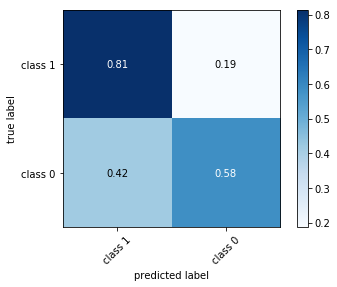

the confusion matrix:  [[782 179]
 [461 646]]
The ROC-AUC score for the test set is:  0.7284069390996274
              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1224
           1       0.72      0.62      0.67       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.73      2080
weighted avg       0.75      0.75      0.74      2080



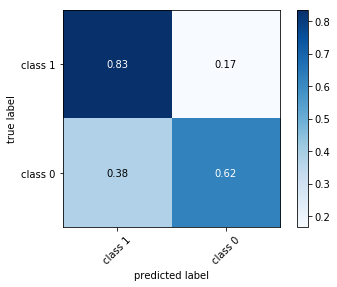

the confusion matrix:  [[1021  203]
 [ 323  533]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 2)
##############################
CPU times: user 1min 24s, sys: 1.27 s, total: 1min 26s
Wall time: 1min 26s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.3s finished


Best: 0.644558 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5473375840244701
              precision    recall  f1-score   support

           0       0.50      0.81      0.62       961
           1       0.63      0.28      0.39      1107

    accuracy                           0.53      2068
   macro avg       0.57      0.55      0.50      2068
weighted avg       0.57      0.53      0.49      2068



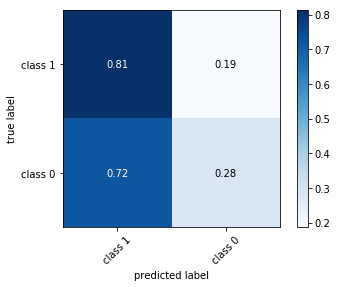

the confusion matrix:  [[782 179]
 [796 311]]
The ROC-AUC score for the test set is:  0.5291712479384277
              precision    recall  f1-score   support

           0       0.61      0.82      0.70      1224
           1       0.48      0.23      0.32       856

    accuracy                           0.58      2080
   macro avg       0.54      0.53      0.51      2080
weighted avg       0.56      0.58      0.54      2080



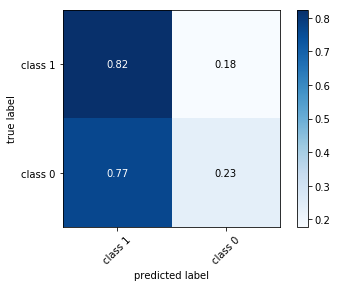

the confusion matrix:  [[1008  216]
 [ 655  201]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 2)
##############################
CPU times: user 4.4 s, sys: 66.6 ms, total: 4.46 s
Wall time: 4.47 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



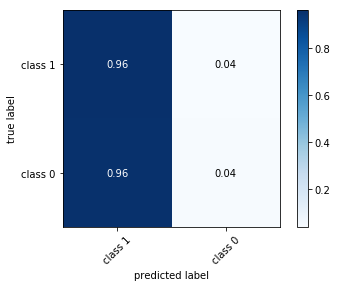

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



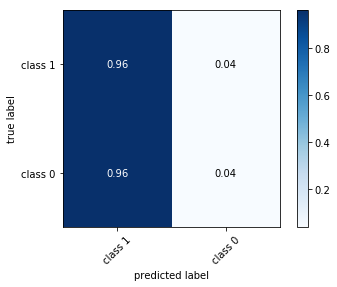

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 3)
##############################
CPU times: user 56.5 s, sys: 85.1 ms, total: 56.6 s
Wall time: 56.6 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.9s finished


Best: 0.817404 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6991677218194311
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.58      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



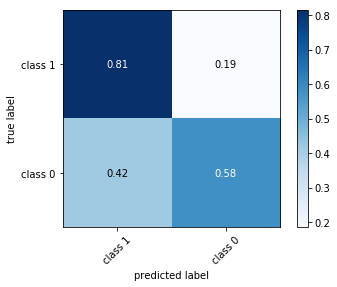

the confusion matrix:  [[783 178]
 [461 646]]
The ROC-AUC score for the test set is:  0.7290521348726405
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1224
           1       0.72      0.63      0.67       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.73      2080
weighted avg       0.74      0.75      0.74      2080



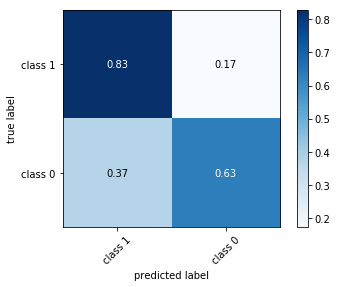

the confusion matrix:  [[1014  210]
 [ 317  539]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 3)
##############################
CPU times: user 1min 23s, sys: 1.19 s, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.9s finished


Best: 0.640000 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5478465953580798
              precision    recall  f1-score   support

           0       0.50      0.83      0.62       961
           1       0.64      0.27      0.38      1107

    accuracy                           0.53      2068
   macro avg       0.57      0.55      0.50      2068
weighted avg       0.57      0.53      0.49      2068



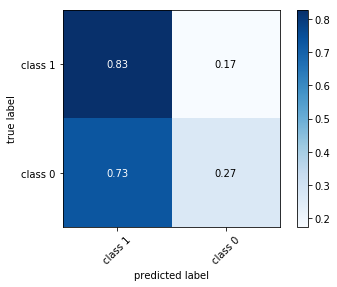

the confusion matrix:  [[796 165]
 [811 296]]
The ROC-AUC score for the test set is:  0.5372953698613402
              precision    recall  f1-score   support

           0       0.61      0.81      0.70      1224
           1       0.49      0.26      0.34       856

    accuracy                           0.59      2080
   macro avg       0.55      0.54      0.52      2080
weighted avg       0.56      0.59      0.55      2080



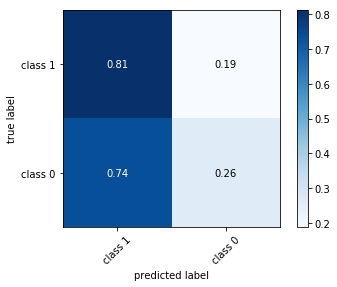

the confusion matrix:  [[995 229]
 [632 224]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 3)
##############################
CPU times: user 4.44 s, sys: 63.3 ms, total: 4.5 s
Wall time: 4.5 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



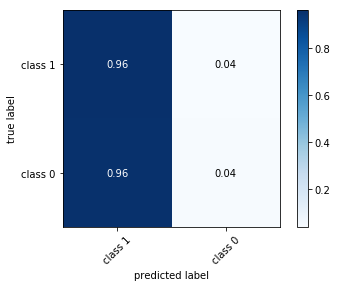

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



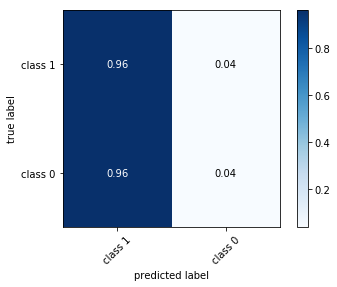

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 5)
##############################
CPU times: user 56.1 s, sys: 106 ms, total: 56.2 s
Wall time: 56.2 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.5s finished


Best: 0.817604 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6977154180143952
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.59      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



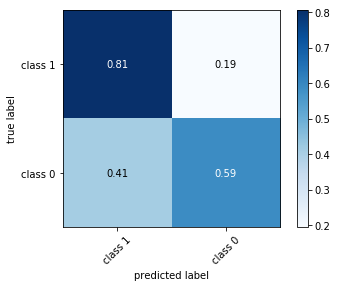

the confusion matrix:  [[775 186]
 [455 652]]
The ROC-AUC score for the test set is:  0.7298118624396799
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1224
           1       0.72      0.63      0.67       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.73      2080
weighted avg       0.74      0.75      0.74      2080



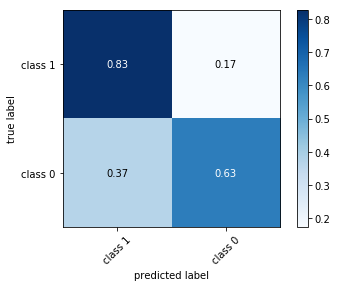

the confusion matrix:  [[1013  211]
 [ 315  541]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 5)
##############################
CPU times: user 1min 24s, sys: 1.24 s, total: 1min 25s
Wall time: 1min 25s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.6s finished


Best: 0.632091 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5491903288786616
              precision    recall  f1-score   support

           0       0.50      0.84      0.62       961
           1       0.65      0.26      0.37      1107

    accuracy                           0.53      2068
   macro avg       0.57      0.55      0.50      2068
weighted avg       0.58      0.53      0.49      2068



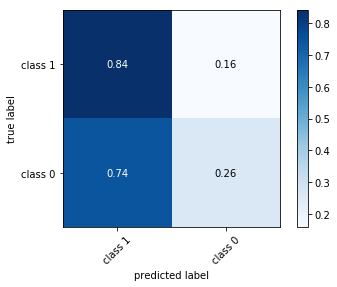

the confusion matrix:  [[809 152]
 [823 284]]
The ROC-AUC score for the test set is:  0.5586708203530634
              precision    recall  f1-score   support

           0       0.63      0.82      0.71      1224
           1       0.54      0.30      0.38       856

    accuracy                           0.60      2080
   macro avg       0.58      0.56      0.55      2080
weighted avg       0.59      0.60      0.57      2080



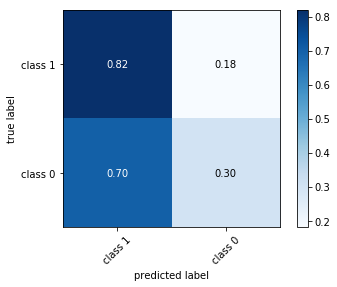

the confusion matrix:  [[1003  221]
 [ 601  255]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 5)
##############################
CPU times: user 4.45 s, sys: 91.1 ms, total: 4.54 s
Wall time: 4.55 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



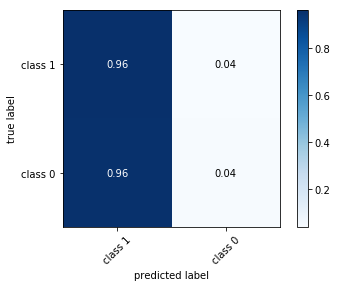

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



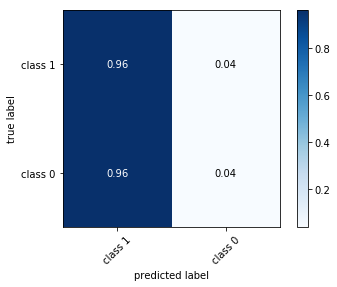

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 2)
##############################
CPU times: user 1min 24s, sys: 135 ms, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.1s finished


Best: 0.810703 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6971664565761163
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.77      0.60      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



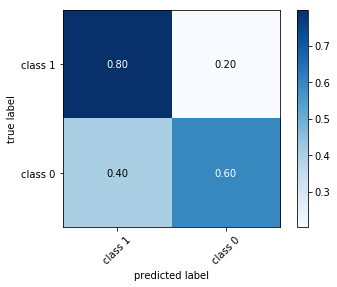

the confusion matrix:  [[767 194]
 [447 660]]
The ROC-AUC score for the test set is:  0.7137010567466863
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      1224
           1       0.69      0.62      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



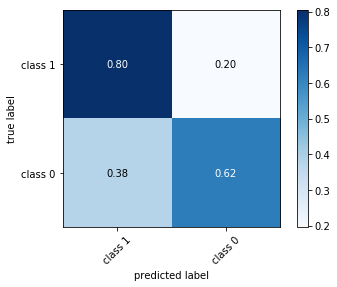

the confusion matrix:  [[985 239]
 [323 533]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 2)
##############################
CPU times: user 2min 3s, sys: 2.07 s, total: 2min 5s
Wall time: 2min 5s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.0s finished


Best: 0.636354 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5499338708267415
              precision    recall  f1-score   support

           0       0.50      0.87      0.63       961
           1       0.67      0.23      0.35      1107

    accuracy                           0.53      2068
   macro avg       0.58      0.55      0.49      2068
weighted avg       0.59      0.53      0.48      2068



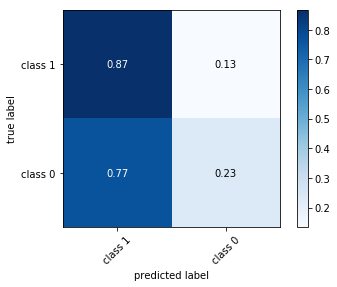

the confusion matrix:  [[833 128]
 [849 258]]
The ROC-AUC score for the test set is:  0.5360507910329241
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1224
           1       0.51      0.22      0.31       856

    accuracy                           0.59      2080
   macro avg       0.56      0.54      0.51      2080
weighted avg       0.57      0.59      0.54      2080



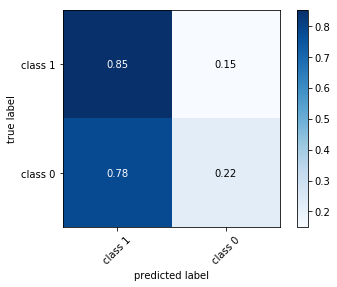

the confusion matrix:  [[1042  182]
 [ 667  189]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 2)
##############################
CPU times: user 6.59 s, sys: 95.2 ms, total: 6.69 s
Wall time: 6.69 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



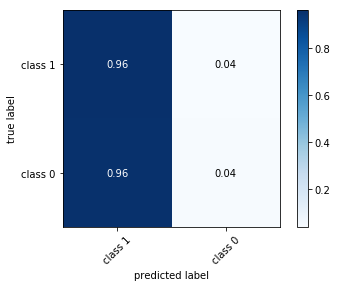

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



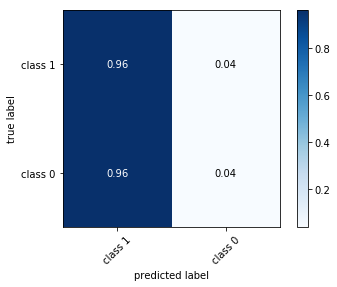

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 3)
##############################
CPU times: user 1min 27s, sys: 218 ms, total: 1min 27s
Wall time: 1min 27s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.2s finished


Best: 0.809168 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6998764836763872
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.77      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



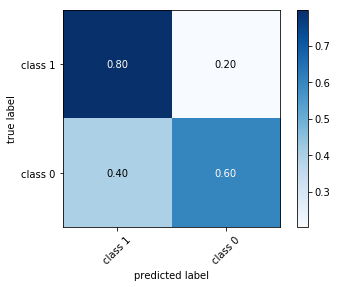

the confusion matrix:  [[767 194]
 [441 666]]
The ROC-AUC score for the test set is:  0.707745403457333
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1224
           1       0.68      0.62      0.65       856

    accuracy                           0.72      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



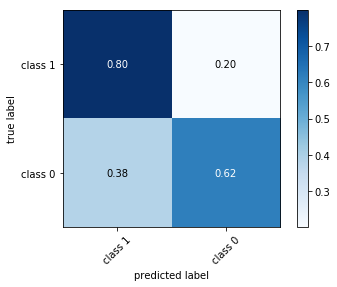

the confusion matrix:  [[979 245]
 [329 527]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 3)
##############################
CPU times: user 2min 7s, sys: 2.06 s, total: 2min 9s
Wall time: 2min 9s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.3s finished


Best: 0.632850 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.538338940448024
              precision    recall  f1-score   support

           0       0.49      0.86      0.62       961
           1       0.64      0.22      0.33      1107

    accuracy                           0.52      2068
   macro avg       0.56      0.54      0.48      2068
weighted avg       0.57      0.52      0.46      2068



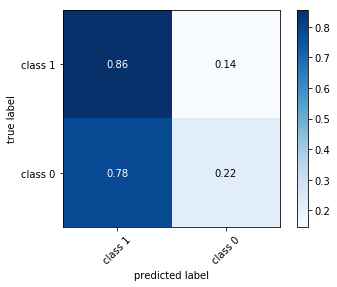

the confusion matrix:  [[822 139]
 [862 245]]
The ROC-AUC score for the test set is:  0.5380970924195224
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1224
           1       0.51      0.23      0.32       856

    accuracy                           0.59      2080
   macro avg       0.56      0.54      0.51      2080
weighted avg       0.57      0.59      0.55      2080



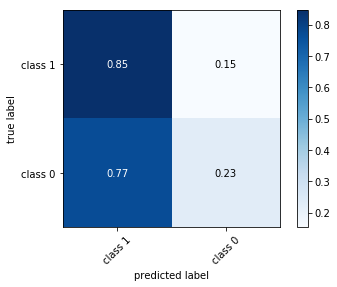

the confusion matrix:  [[1037  187]
 [ 660  196]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 3)
##############################
CPU times: user 6.58 s, sys: 119 ms, total: 6.7 s
Wall time: 6.71 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



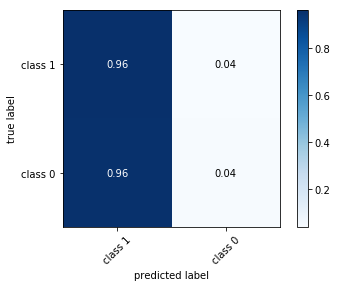

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



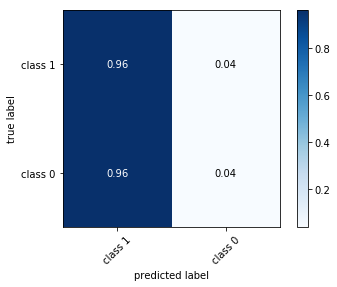

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 5)
##############################
CPU times: user 1min 25s, sys: 192 ms, total: 1min 25s
Wall time: 1min 25s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s finished


Best: 0.809123 using {'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6938040677666576
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       961
           1       0.74      0.64      0.69      1107

    accuracy                           0.69      2068
   macro avg       0.69      0.69      0.69      2068
weighted avg       0.70      0.69      0.69      2068



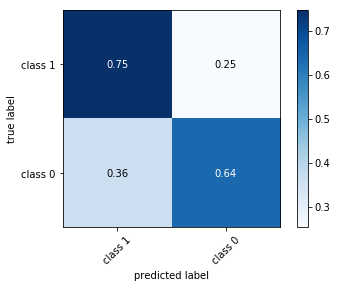

the confusion matrix:  [[718 243]
 [398 709]]
The ROC-AUC score for the test set is:  0.7155984668010507
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1224
           1       0.65      0.69      0.67       856

    accuracy                           0.72      2080
   macro avg       0.71      0.72      0.71      2080
weighted avg       0.72      0.72      0.72      2080



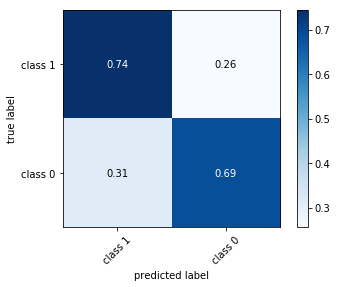

the confusion matrix:  [[911 313]
 [268 588]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 5)
##############################
CPU times: user 2min 6s, sys: 1.81 s, total: 2min 8s
Wall time: 2min 8s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.2s finished


Best: 0.627864 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5336737082251155
              precision    recall  f1-score   support

           0       0.48      0.87      0.62       961
           1       0.63      0.20      0.30      1107

    accuracy                           0.51      2068
   macro avg       0.56      0.53      0.46      2068
weighted avg       0.56      0.51      0.45      2068



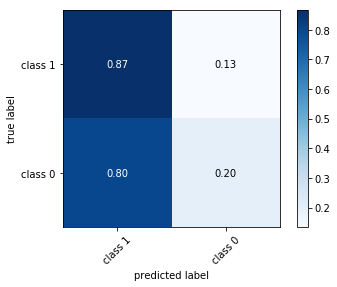

the confusion matrix:  [[833 128]
 [885 222]]
The ROC-AUC score for the test set is:  0.5392576812656527
              precision    recall  f1-score   support

           0       0.61      0.86      0.72      1224
           1       0.52      0.21      0.30       856

    accuracy                           0.60      2080
   macro avg       0.57      0.54      0.51      2080
weighted avg       0.58      0.60      0.55      2080



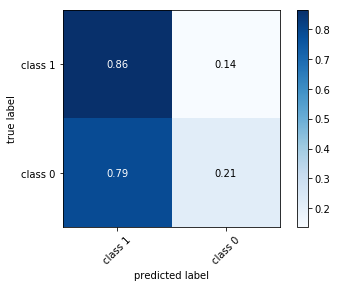

the confusion matrix:  [[1057  167]
 [ 672  184]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 5)
##############################
CPU times: user 6.52 s, sys: 91.5 ms, total: 6.61 s
Wall time: 6.61 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



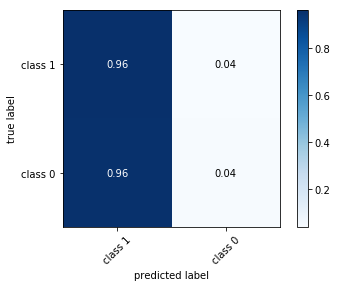

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



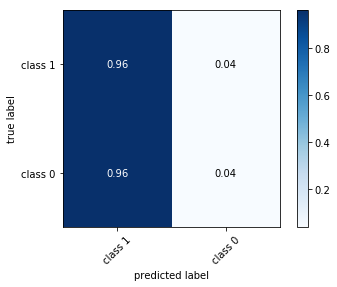

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 2)
##############################
CPU times: user 2min 20s, sys: 272 ms, total: 2min 21s
Wall time: 2min 21s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.8s finished


Best: 0.805033 using {'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.712391206464961
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       961
           1       0.76      0.68      0.71      1107

    accuracy                           0.71      2068
   macro avg       0.71      0.71      0.71      2068
weighted avg       0.71      0.71      0.71      2068



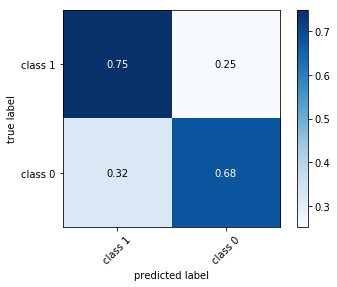

the confusion matrix:  [[719 242]
 [358 749]]
The ROC-AUC score for the test set is:  0.7109866532282696
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1224
           1       0.65      0.68      0.66       856

    accuracy                           0.72      2080
   macro avg       0.71      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



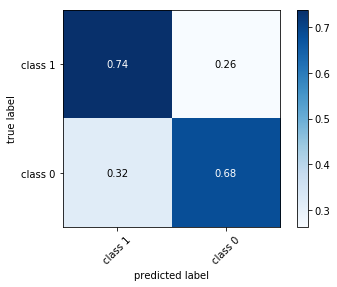

the confusion matrix:  [[904 320]
 [271 585]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 2)
##############################
CPU times: user 3min 24s, sys: 3.47 s, total: 3min 28s
Wall time: 3min 28s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.8s finished


Best: 0.621153 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5391511025758887
              precision    recall  f1-score   support

           0       0.49      0.88      0.63       961
           1       0.66      0.20      0.30      1107

    accuracy                           0.51      2068
   macro avg       0.57      0.54      0.47      2068
weighted avg       0.58      0.51      0.45      2068



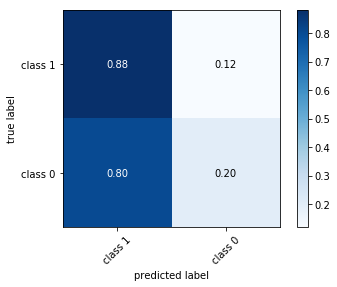

the confusion matrix:  [[847 114]
 [889 218]]
The ROC-AUC score for the test set is:  0.544342892920408
              precision    recall  f1-score   support

           0       0.61      0.86      0.72      1224
           1       0.53      0.23      0.32       856

    accuracy                           0.60      2080
   macro avg       0.57      0.54      0.52      2080
weighted avg       0.58      0.60      0.55      2080



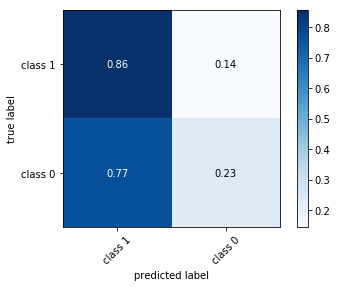

the confusion matrix:  [[1048  176]
 [ 657  199]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 2)
##############################
CPU times: user 11 s, sys: 218 ms, total: 11.2 s
Wall time: 11.2 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



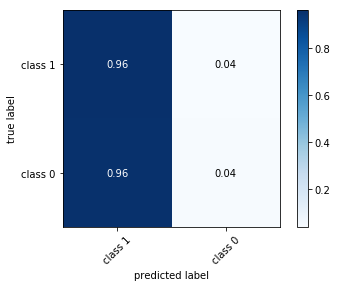

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



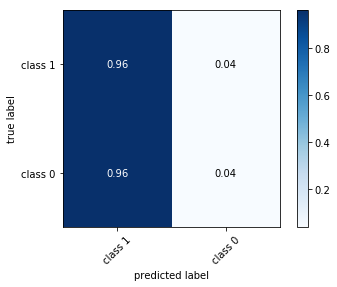

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 3)
##############################
CPU times: user 2min 20s, sys: 219 ms, total: 2min 20s
Wall time: 2min 20s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.8s finished


Best: 0.807075 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7137810001062201
              precision    recall  f1-score   support

           0       0.65      0.79      0.72       961
           1       0.78      0.64      0.70      1107

    accuracy                           0.71      2068
   macro avg       0.72      0.71      0.71      2068
weighted avg       0.72      0.71      0.71      2068



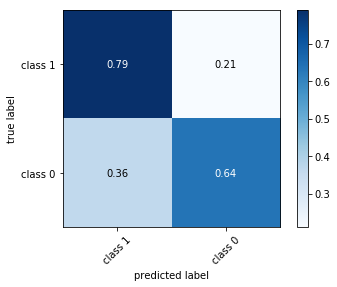

the confusion matrix:  [[759 202]
 [401 706]]
The ROC-AUC score for the test set is:  0.7072338281106836
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1224
           1       0.66      0.64      0.65       856

    accuracy                           0.72      2080
   macro avg       0.71      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



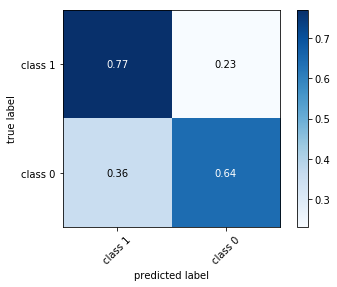

the confusion matrix:  [[942 282]
 [304 552]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 3)
##############################
CPU times: user 3min 24s, sys: 3.23 s, total: 3min 27s
Wall time: 3min 27s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.9s finished


Best: 0.628830 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5382078101044625
              precision    recall  f1-score   support

           0       0.49      0.89      0.63       961
           1       0.66      0.19      0.29      1107

    accuracy                           0.51      2068
   macro avg       0.57      0.54      0.46      2068
weighted avg       0.58      0.51      0.45      2068



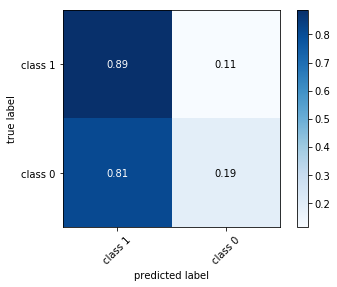

the confusion matrix:  [[853 108]
 [898 209]]
The ROC-AUC score for the test set is:  0.5525739111844115
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1224
           1       0.56      0.24      0.33       856

    accuracy                           0.61      2080
   macro avg       0.59      0.55      0.53      2080
weighted avg       0.59      0.61      0.56      2080



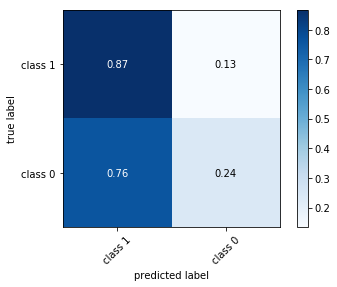

the confusion matrix:  [[1061  163]
 [ 652  204]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 3)
##############################
CPU times: user 10.8 s, sys: 136 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



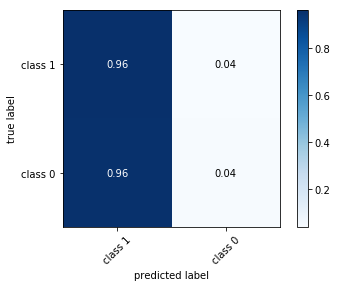

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



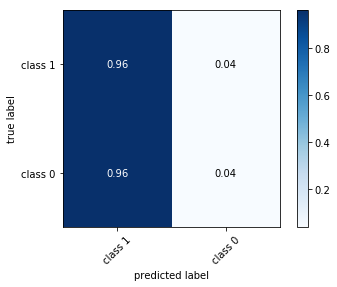

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 5)
##############################
CPU times: user 2min 21s, sys: 227 ms, total: 2min 21s
Wall time: 2min 21s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.7s finished


Best: 0.806482 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7060739199136703
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       961
           1       0.77      0.63      0.69      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.71      0.70      2068
weighted avg       0.71      0.70      0.70      2068



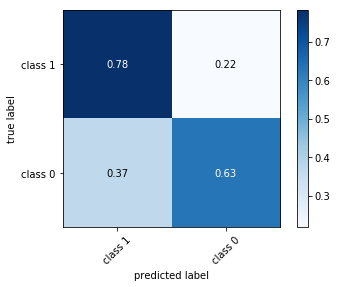

the confusion matrix:  [[752 209]
 [410 697]]
The ROC-AUC score for the test set is:  0.7136590617555433
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1224
           1       0.67      0.66      0.66       856

    accuracy                           0.72      2080
   macro avg       0.71      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



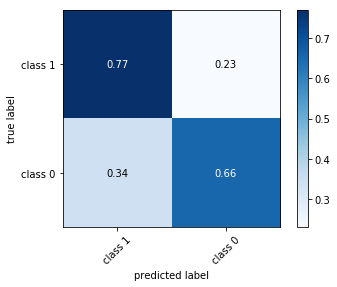

the confusion matrix:  [[942 282]
 [293 563]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 5)
##############################
CPU times: user 3min 29s, sys: 3.32 s, total: 3min 32s
Wall time: 3min 32s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.9s finished


Best: 0.622634 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5269959307293385
              precision    recall  f1-score   support

           0       0.48      0.88      0.62       961
           1       0.62      0.18      0.28      1107

    accuracy                           0.50      2068
   macro avg       0.55      0.53      0.45      2068
weighted avg       0.56      0.50      0.44      2068



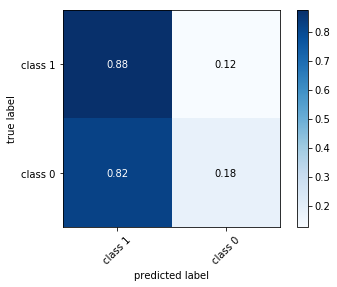

the confusion matrix:  [[841 120]
 [909 198]]
The ROC-AUC score for the test set is:  0.551462952782359
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1224
           1       0.56      0.23      0.33       856

    accuracy                           0.61      2080
   macro avg       0.59      0.55      0.53      2080
weighted avg       0.59      0.61      0.56      2080



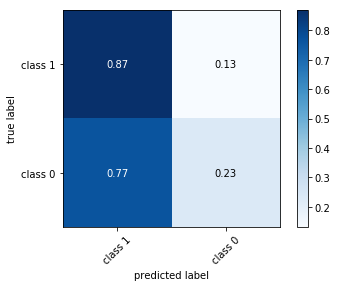

the confusion matrix:  [[1064  160]
 [ 656  200]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 5)
##############################
CPU times: user 10.9 s, sys: 131 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Best: 0.508907 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5021150055413144
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       961
           1       0.56      0.04      0.08      1107

    accuracy                           0.47      2068
   macro avg       0.51      0.50      0.35      2068
weighted avg       0.52      0.47      0.33      2068



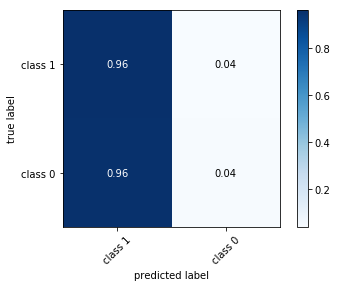

the confusion matrix:  [[ 926   35]
 [1062   45]]
The ROC-AUC score for the test set is:  0.49908374564779184
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1224
           1       0.40      0.04      0.07       856

    accuracy                           0.58      2080
   macro avg       0.49      0.50      0.40      2080
weighted avg       0.51      0.58      0.46      2080



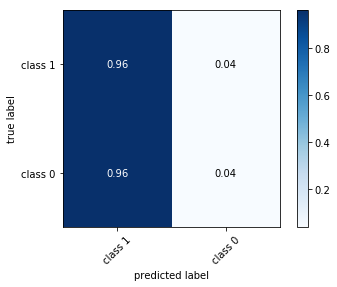

the confusion matrix:  [[1176   48]
 [ 824   32]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 2)
##############################
CPU times: user 1min 8s, sys: 153 ms, total: 1min 8s
Wall time: 1min 8s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   27.1s finished


Best: 0.818830 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6970865563667776
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.58      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



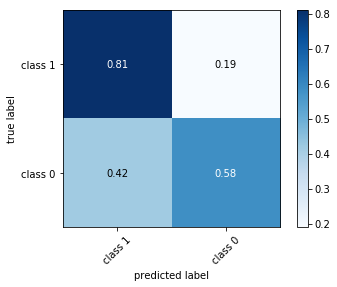

the confusion matrix:  [[779 182]
 [461 646]]
The ROC-AUC score for the test set is:  0.730163093274693
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1224
           1       0.72      0.63      0.67       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.73      2080
weighted avg       0.74      0.75      0.74      2080



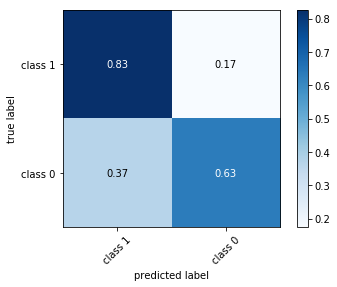

the confusion matrix:  [[1011  213]
 [ 313  543]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 2)
##############################
CPU times: user 1min 30s, sys: 1.35 s, total: 1min 32s
Wall time: 1min 32s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.8s finished


Best: 0.646719 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5482982665414583
              precision    recall  f1-score   support

           0       0.50      0.83      0.62       961
           1       0.64      0.27      0.38      1107

    accuracy                           0.53      2068
   macro avg       0.57      0.55      0.50      2068
weighted avg       0.57      0.53      0.49      2068



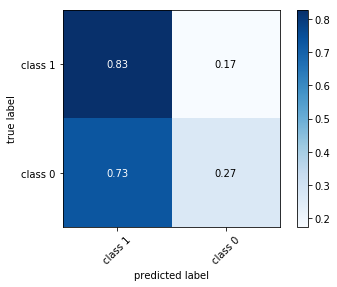

the confusion matrix:  [[796 165]
 [810 297]]
The ROC-AUC score for the test set is:  0.528987997067986
              precision    recall  f1-score   support

           0       0.61      0.84      0.70      1224
           1       0.49      0.22      0.30       856

    accuracy                           0.58      2080
   macro avg       0.55      0.53      0.50      2080
weighted avg       0.56      0.58      0.54      2080



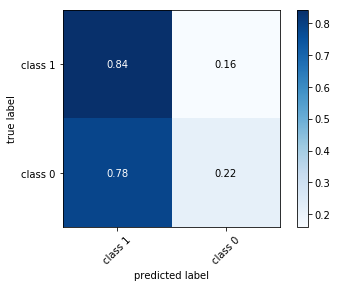

the confusion matrix:  [[1029  195]
 [ 670  186]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 2)
##############################
CPU times: user 4.42 s, sys: 103 ms, total: 4.53 s
Wall time: 4.53 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.4s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



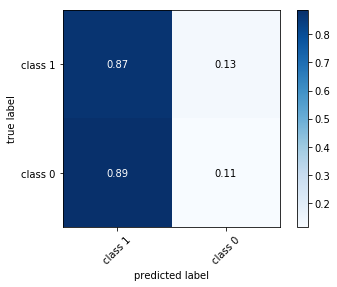

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



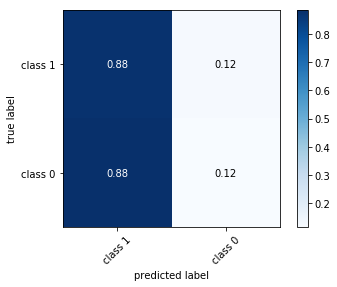

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 3)
##############################
CPU times: user 1min 8s, sys: 148 ms, total: 1min 8s
Wall time: 1min 8s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   27.7s finished


Best: 0.819262 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7033700028294074
              precision    recall  f1-score   support

           0       0.63      0.82      0.71       961
           1       0.79      0.59      0.67      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.72      0.70      0.69      2068



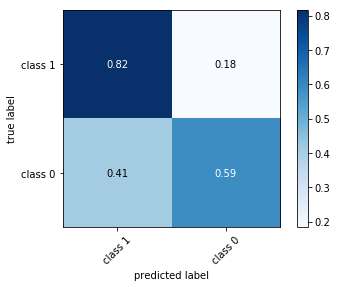

the confusion matrix:  [[785 176]
 [454 653]]
The ROC-AUC score for the test set is:  0.7341335288009284
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1224
           1       0.72      0.64      0.68       856

    accuracy                           0.75      2080
   macro avg       0.75      0.73      0.74      2080
weighted avg       0.75      0.75      0.75      2080



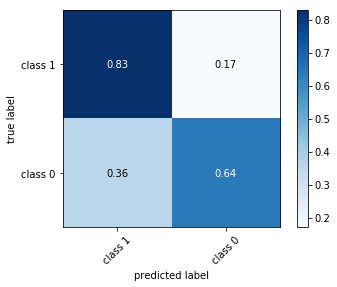

the confusion matrix:  [[1015  209]
 [ 309  547]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 3)
##############################
CPU times: user 1min 32s, sys: 1.32 s, total: 1min 33s
Wall time: 1min 33s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.5s finished


Best: 0.640935 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5405799063193546
              precision    recall  f1-score   support

           0       0.49      0.83      0.62       961
           1       0.63      0.25      0.35      1107

    accuracy                           0.52      2068
   macro avg       0.56      0.54      0.49      2068
weighted avg       0.57      0.52      0.48      2068



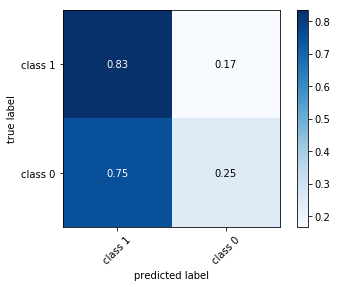

the confusion matrix:  [[802 159]
 [834 273]]
The ROC-AUC score for the test set is:  0.5350009162543522
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1224
           1       0.51      0.22      0.31       856

    accuracy                           0.59      2080
   macro avg       0.56      0.54      0.51      2080
weighted avg       0.57      0.59      0.54      2080



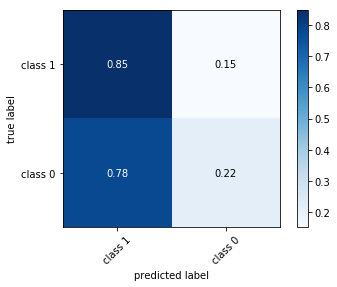

the confusion matrix:  [[1038  186]
 [ 666  190]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 3)
##############################
CPU times: user 4.44 s, sys: 91.6 ms, total: 4.53 s
Wall time: 4.54 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



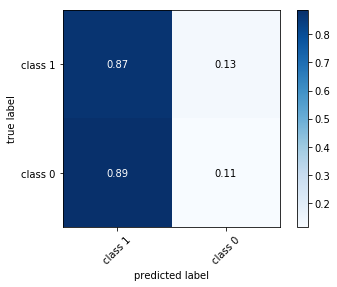

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



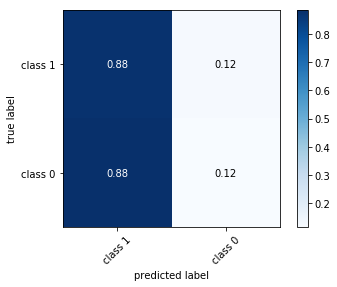

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 5)
##############################
CPU times: user 1min 8s, sys: 125 ms, total: 1min 8s
Wall time: 1min 8s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.8s finished


Best: 0.819129 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7032327624698377
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.79      0.59      0.68      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.72      0.70      0.69      2068



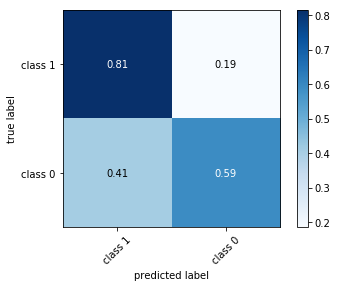

the confusion matrix:  [[783 178]
 [452 655]]
The ROC-AUC score for the test set is:  0.7327896890843564
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1224
           1       0.72      0.64      0.68       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.74      2080
weighted avg       0.75      0.75      0.75      2080



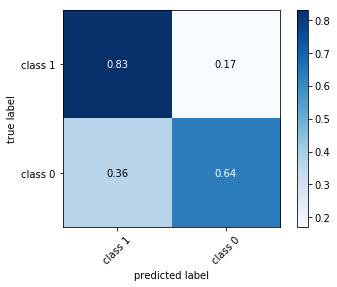

the confusion matrix:  [[1016  208]
 [ 312  544]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 5)
##############################
CPU times: user 1min 33s, sys: 1.31 s, total: 1min 34s
Wall time: 1min 34s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.8s finished


Best: 0.638896 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5399223745966214
              precision    recall  f1-score   support

           0       0.49      0.83      0.62       961
           1       0.63      0.25      0.36      1107

    accuracy                           0.52      2068
   macro avg       0.56      0.54      0.49      2068
weighted avg       0.56      0.52      0.48      2068



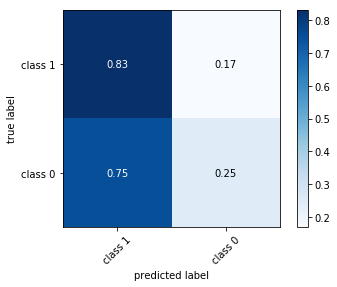

the confusion matrix:  [[799 162]
 [832 275]]
The ROC-AUC score for the test set is:  0.5378145806609247
              precision    recall  f1-score   support

           0       0.61      0.83      0.70      1224
           1       0.50      0.25      0.33       856

    accuracy                           0.59      2080
   macro avg       0.56      0.54      0.52      2080
weighted avg       0.57      0.59      0.55      2080



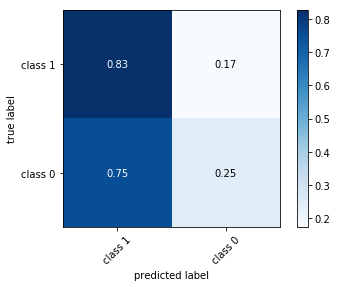

the confusion matrix:  [[1012  212]
 [ 643  213]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 5)
##############################
CPU times: user 4.3 s, sys: 119 ms, total: 4.42 s
Wall time: 4.43 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



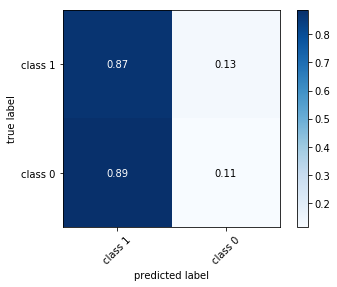

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



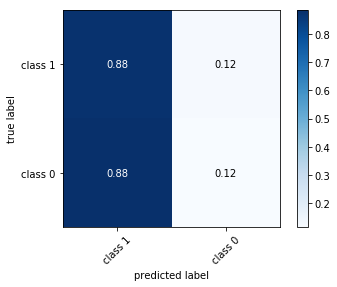

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 2)
##############################
CPU times: user 1min 42s, sys: 148 ms, total: 1min 42s
Wall time: 1min 42s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.7s finished


Best: 0.813219 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7002882047550965
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.78      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



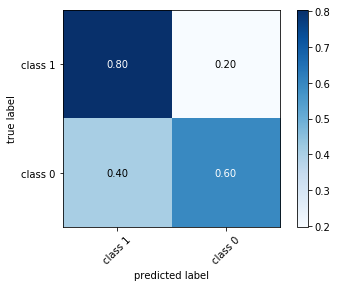

the confusion matrix:  [[773 188]
 [447 660]]
The ROC-AUC score for the test set is:  0.721176165170118
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1224
           1       0.70      0.63      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



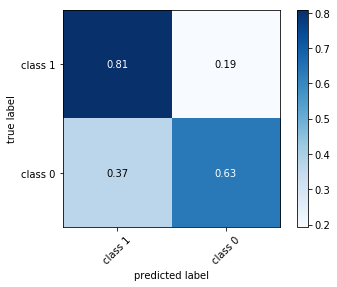

the confusion matrix:  [[989 235]
 [313 543]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 2)
##############################
CPU times: user 2min 14s, sys: 1.96 s, total: 2min 16s
Wall time: 2min 16s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   24.1s finished


Best: 0.638659 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.539562823654598
              precision    recall  f1-score   support

           0       0.49      0.89      0.63       961
           1       0.66      0.19      0.30      1107

    accuracy                           0.51      2068
   macro avg       0.58      0.54      0.46      2068
weighted avg       0.58      0.51      0.45      2068



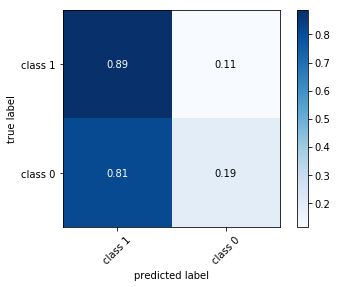

the confusion matrix:  [[853 108]
 [895 212]]
The ROC-AUC score for the test set is:  0.518336540223566
              precision    recall  f1-score   support

           0       0.60      0.88      0.71      1224
           1       0.48      0.15      0.23       856

    accuracy                           0.58      2080
   macro avg       0.54      0.52      0.47      2080
weighted avg       0.55      0.58      0.52      2080



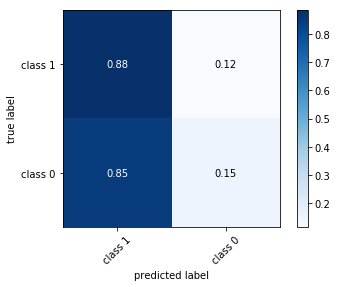

the confusion matrix:  [[1083  141]
 [ 726  130]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 2)
##############################
CPU times: user 6.5 s, sys: 136 ms, total: 6.63 s
Wall time: 6.64 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.4s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



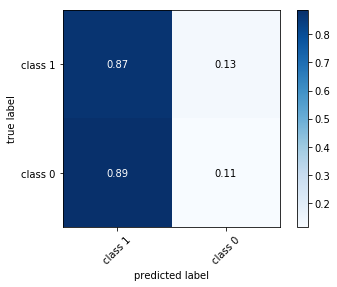

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



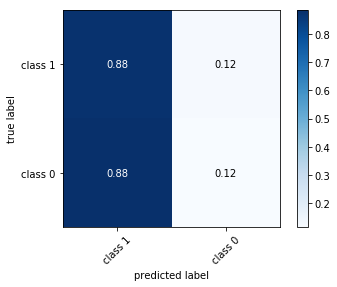

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 3)
##############################
CPU times: user 1min 41s, sys: 180 ms, total: 1min 41s
Wall time: 1min 41s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.8s finished


Best: 0.814840 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6984528499464668
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.77      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



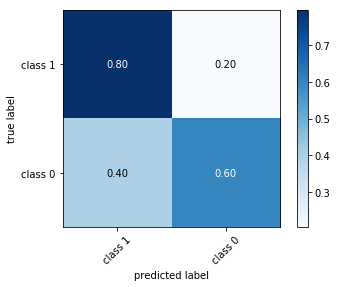

the confusion matrix:  [[766 195]
 [443 664]]
The ROC-AUC score for the test set is:  0.7204126198766111
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1224
           1       0.70      0.62      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.74      0.74      0.73      2080



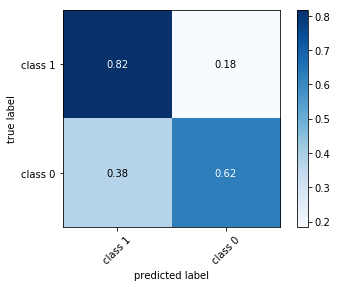

the confusion matrix:  [[1000  224]
 [ 322  534]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 3)
##############################
CPU times: user 2min 17s, sys: 2.09 s, total: 2min 19s
Wall time: 2min 19s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.6s finished


Best: 0.635782 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5227424195851393
              precision    recall  f1-score   support

           0       0.48      0.89      0.62       961
           1       0.62      0.15      0.25      1107

    accuracy                           0.50      2068
   macro avg       0.55      0.52      0.43      2068
weighted avg       0.55      0.50      0.42      2068



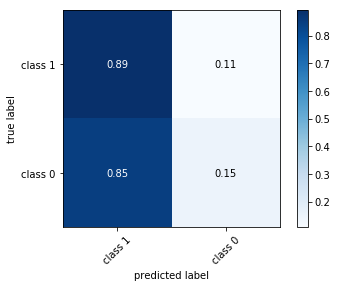

the confusion matrix:  [[858 103]
 [938 169]]
The ROC-AUC score for the test set is:  0.529667552379207
              precision    recall  f1-score   support

           0       0.61      0.89      0.72      1224
           1       0.52      0.17      0.26       856

    accuracy                           0.59      2080
   macro avg       0.56      0.53      0.49      2080
weighted avg       0.57      0.59      0.53      2080



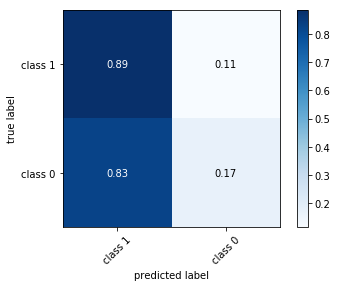

the confusion matrix:  [[1085  139]
 [ 708  148]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 3)
##############################
CPU times: user 6.83 s, sys: 200 ms, total: 7.03 s
Wall time: 7.03 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



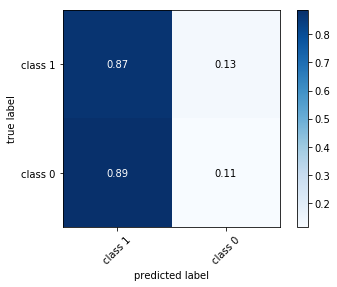

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



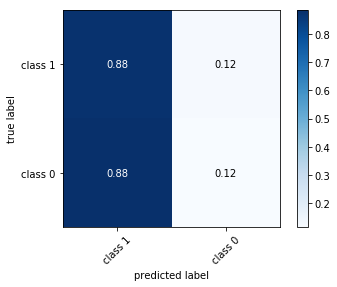

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 5)
##############################
CPU times: user 1min 41s, sys: 189 ms, total: 1min 41s
Wall time: 1min 41s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   24.0s finished


Best: 0.814151 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6934158467495184
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       961
           1       0.77      0.59      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.69      0.69      2068
weighted avg       0.70      0.69      0.68      2068



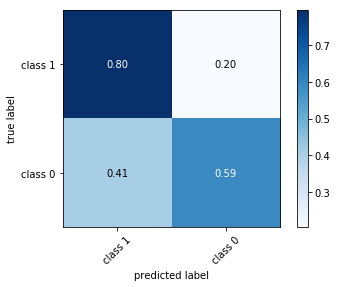

the confusion matrix:  [[765 196]
 [453 654]]
The ROC-AUC score for the test set is:  0.7207104025410788
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1224
           1       0.70      0.64      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



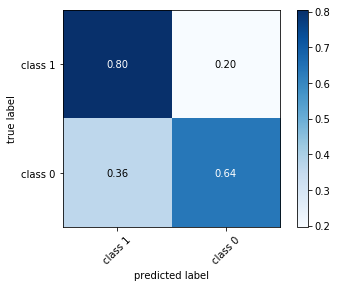

the confusion matrix:  [[985 239]
 [311 545]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 5)
##############################
CPU times: user 2min 18s, sys: 2.09 s, total: 2min 20s
Wall time: 2min 20s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.5s finished


Best: 0.631368 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5226051792255696
              precision    recall  f1-score   support

           0       0.48      0.89      0.62       961
           1       0.62      0.15      0.25      1107

    accuracy                           0.50      2068
   macro avg       0.55      0.52      0.43      2068
weighted avg       0.55      0.50      0.42      2068



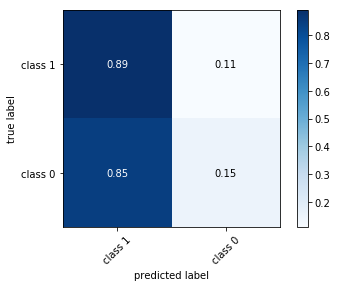

the confusion matrix:  [[856 105]
 [936 171]]
The ROC-AUC score for the test set is:  0.5353292407305601
              precision    recall  f1-score   support

           0       0.61      0.90      0.72      1224
           1       0.54      0.18      0.26       856

    accuracy                           0.60      2080
   macro avg       0.57      0.54      0.49      2080
weighted avg       0.58      0.60      0.54      2080



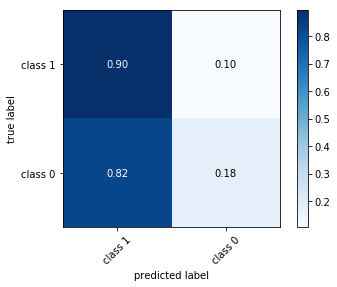

the confusion matrix:  [[1096  128]
 [ 706  150]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 5)
##############################
CPU times: user 6.61 s, sys: 104 ms, total: 6.71 s
Wall time: 6.72 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



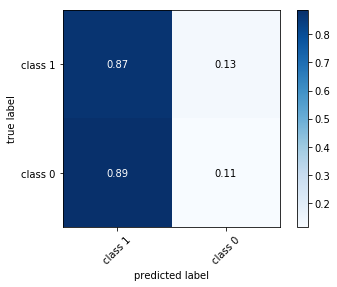

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



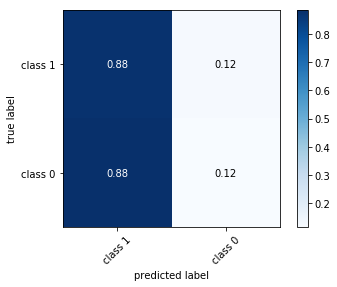

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 2)
##############################
CPU times: user 2min 49s, sys: 295 ms, total: 2min 49s
Wall time: 2min 49s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   21.3s finished


Best: 0.809444 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7091557179879812
              precision    recall  f1-score   support

           0       0.65      0.80      0.71       961
           1       0.78      0.62      0.69      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.71      0.70      2068
weighted avg       0.72      0.70      0.70      2068



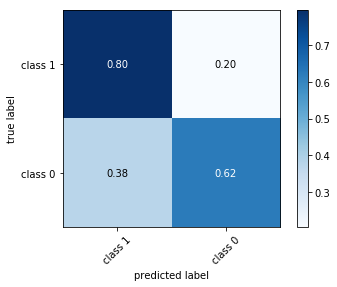

the confusion matrix:  [[764 197]
 [417 690]]
The ROC-AUC score for the test set is:  0.7161024066947651
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1224
           1       0.68      0.64      0.66       856

    accuracy                           0.73      2080
   macro avg       0.72      0.72      0.72      2080
weighted avg       0.73      0.73      0.73      2080



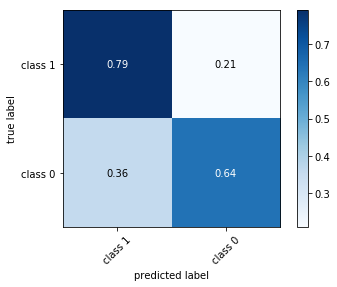

the confusion matrix:  [[968 256]
 [307 549]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 2)
##############################
CPU times: user 3min 40s, sys: 3.52 s, total: 3min 44s
Wall time: 3min 44s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   22.2s finished


Best: 0.626356 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5323534747661038
              precision    recall  f1-score   support

           0       0.48      0.91      0.63       961
           1       0.66      0.16      0.25      1107

    accuracy                           0.51      2068
   macro avg       0.57      0.53      0.44      2068
weighted avg       0.58      0.51      0.43      2068



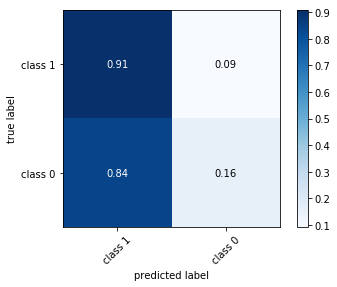

the confusion matrix:  [[873  88]
 [934 173]]
The ROC-AUC score for the test set is:  0.5299615173172072
              precision    recall  f1-score   support

           0       0.61      0.88      0.72      1224
           1       0.51      0.18      0.26       856

    accuracy                           0.59      2080
   macro avg       0.56      0.53      0.49      2080
weighted avg       0.57      0.59      0.53      2080



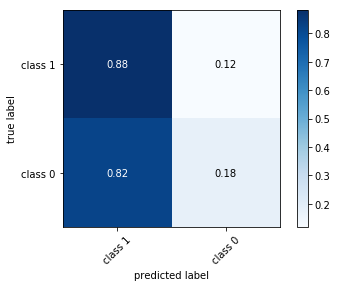

the confusion matrix:  [[1080  144]
 [ 704  152]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 2)
##############################
CPU times: user 10.9 s, sys: 160 ms, total: 11 s
Wall time: 11.1 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



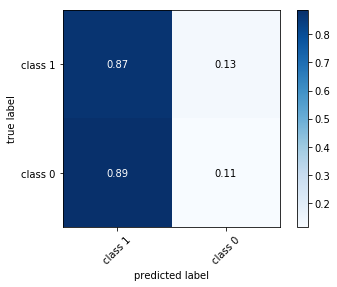

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



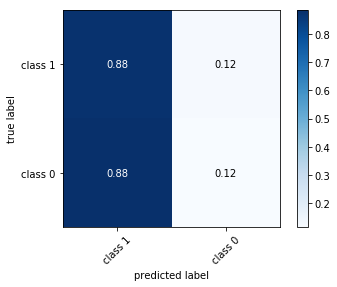

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 3)
##############################
CPU times: user 2min 48s, sys: 307 ms, total: 2min 49s
Wall time: 2min 49s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   22.2s finished


Best: 0.808849 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7117285047286824
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       961
           1       0.78      0.63      0.70      1107

    accuracy                           0.71      2068
   macro avg       0.71      0.71      0.71      2068
weighted avg       0.72      0.71      0.71      2068



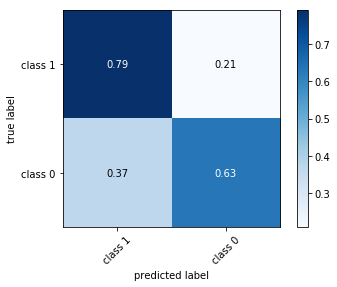

the confusion matrix:  [[762 199]
 [409 698]]
The ROC-AUC score for the test set is:  0.7102116547553602
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1224
           1       0.67      0.65      0.66       856

    accuracy                           0.72      2080
   macro avg       0.71      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



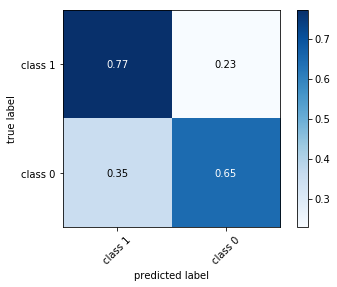

the confusion matrix:  [[945 279]
 [301 555]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 3)
##############################
CPU times: user 3min 43s, sys: 3 s, total: 3min 46s
Wall time: 3min 46s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   21.6s finished


Best: 0.625594 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.516750843887211
              precision    recall  f1-score   support

           0       0.47      0.91      0.62       961
           1       0.61      0.12      0.20      1107

    accuracy                           0.49      2068
   macro avg       0.54      0.52      0.41      2068
weighted avg       0.55      0.49      0.40      2068



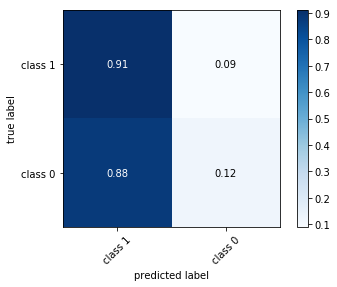

the confusion matrix:  [[876  85]
 [972 135]]
The ROC-AUC score for the test set is:  0.525800195467595
              precision    recall  f1-score   support

           0       0.60      0.91      0.73      1224
           1       0.53      0.14      0.22       856

    accuracy                           0.59      2080
   macro avg       0.56      0.53      0.47      2080
weighted avg       0.57      0.59      0.52      2080



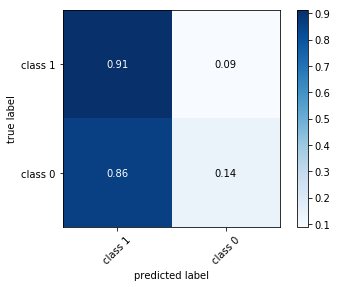

the confusion matrix:  [[1117  107]
 [ 737  119]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 3)
##############################
CPU times: user 10.9 s, sys: 204 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.4s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



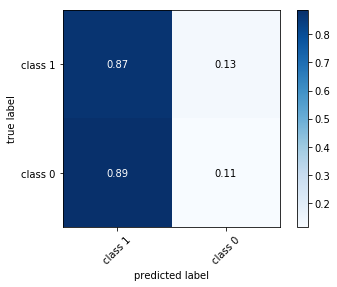

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



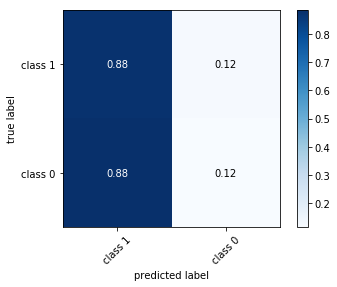

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 5)
##############################
CPU times: user 2min 50s, sys: 392 ms, total: 2min 51s
Wall time: 2min 51s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   21.0s finished


Best: 0.809561 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7124259865560848
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       961
           1       0.78      0.64      0.70      1107

    accuracy                           0.71      2068
   macro avg       0.71      0.71      0.71      2068
weighted avg       0.72      0.71      0.71      2068



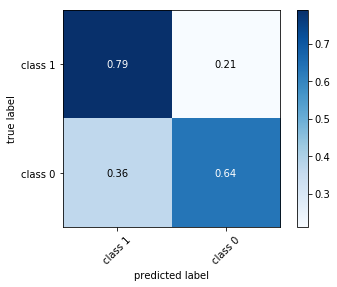

the confusion matrix:  [[759 202]
 [404 703]]
The ROC-AUC score for the test set is:  0.7054165903121373
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      1224
           1       0.67      0.63      0.65       856

    accuracy                           0.72      2080
   macro avg       0.71      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



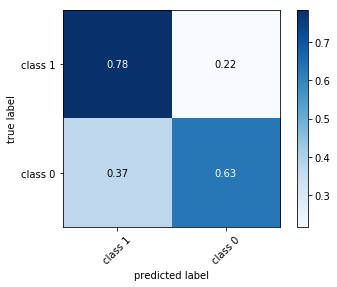

the confusion matrix:  [[959 265]
 [319 537]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 5)
##############################
CPU times: user 3min 46s, sys: 3.3 s, total: 3min 49s
Wall time: 3min 49s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   21.7s finished


Best: 0.626295 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5170253246063504
              precision    recall  f1-score   support

           0       0.47      0.92      0.62       961
           1       0.62      0.12      0.20      1107

    accuracy                           0.49      2068
   macro avg       0.55      0.52      0.41      2068
weighted avg       0.55      0.49      0.40      2068



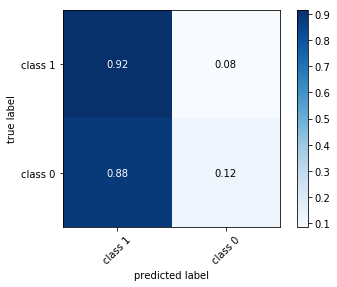

the confusion matrix:  [[880  81]
 [976 131]]
The ROC-AUC score for the test set is:  0.5227078370288925
              precision    recall  f1-score   support

           0       0.60      0.91      0.72      1224
           1       0.51      0.14      0.22       856

    accuracy                           0.59      2080
   macro avg       0.55      0.52      0.47      2080
weighted avg       0.56      0.59      0.52      2080



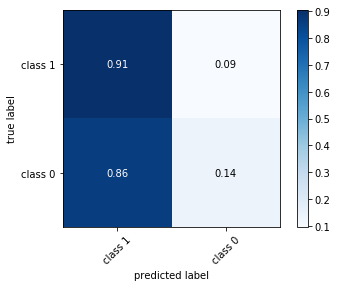

the confusion matrix:  [[1108  116]
 [ 736  120]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 5)
##############################
CPU times: user 11 s, sys: 179 ms, total: 11.2 s
Wall time: 11.2 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.3s finished


Best: 0.498963 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4924630602532179
              precision    recall  f1-score   support

           0       0.46      0.87      0.60       961
           1       0.50      0.11      0.18      1107

    accuracy                           0.47      2068
   macro avg       0.48      0.49      0.39      2068
weighted avg       0.48      0.47      0.38      2068



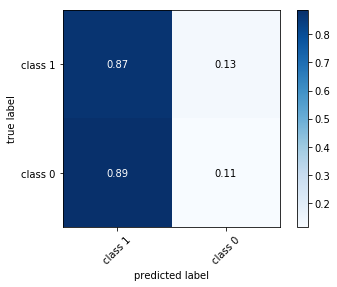

the confusion matrix:  [[838 123]
 [982 125]]
The ROC-AUC score for the test set is:  0.4965525929998167
              precision    recall  f1-score   support

           0       0.59      0.88      0.70      1224
           1       0.40      0.12      0.18       856

    accuracy                           0.56      2080
   macro avg       0.49      0.50      0.44      2080
weighted avg       0.51      0.56      0.49      2080



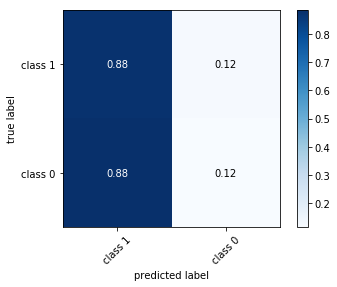

the confusion matrix:  [[1074  150]
 [ 757   99]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 2)
##############################
CPU times: user 1min 19s, sys: 158 ms, total: 1min 19s
Wall time: 1min 19s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   40.9s finished


Best: 0.819170 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.6999338238266185
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.59      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



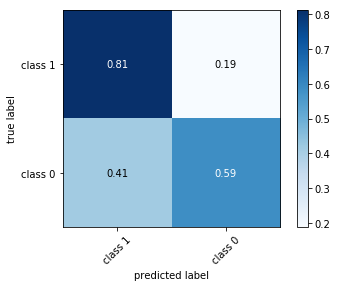

the confusion matrix:  [[781 180]
 [457 650]]
The ROC-AUC score for the test set is:  0.730220359171706
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1224
           1       0.72      0.63      0.67       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.73      2080
weighted avg       0.75      0.75      0.74      2080



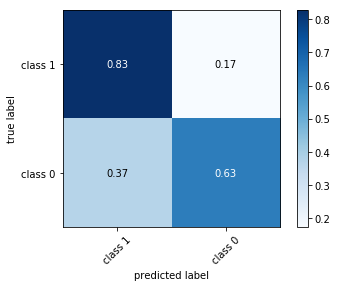

the confusion matrix:  [[1014  210]
 [ 315  541]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 2)
##############################
CPU times: user 1min 38s, sys: 1.25 s, total: 1min 39s
Wall time: 1min 39s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.2s finished


Best: 0.645177 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5522547369074107
              precision    recall  f1-score   support

           0       0.50      0.83      0.62       961
           1       0.65      0.27      0.38      1107

    accuracy                           0.53      2068
   macro avg       0.58      0.55      0.50      2068
weighted avg       0.58      0.53      0.49      2068



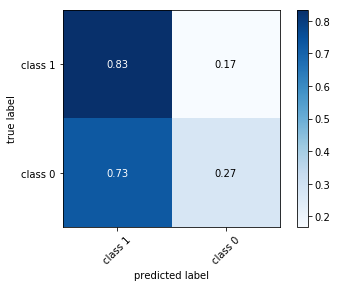

the confusion matrix:  [[801 160]
 [807 300]]
The ROC-AUC score for the test set is:  0.5379749251725613
              precision    recall  f1-score   support

           0       0.61      0.86      0.71      1224
           1       0.52      0.22      0.31       856

    accuracy                           0.59      2080
   macro avg       0.56      0.54      0.51      2080
weighted avg       0.57      0.59      0.55      2080



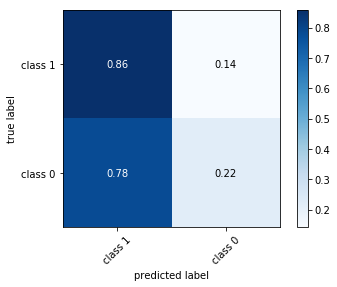

the confusion matrix:  [[1051  173]
 [ 670  186]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 2)
##############################
CPU times: user 4.46 s, sys: 67.7 ms, total: 4.53 s
Wall time: 4.53 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.5s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



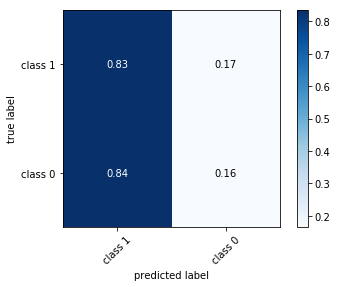

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



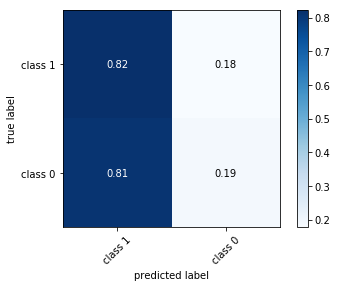

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 3)
##############################
CPU times: user 1min 22s, sys: 210 ms, total: 1min 22s
Wall time: 1min 22s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   38.3s finished


Best: 0.819376 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7041647749117103
              precision    recall  f1-score   support

           0       0.63      0.82      0.72       961
           1       0.79      0.59      0.67      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.72      0.70      0.69      2068



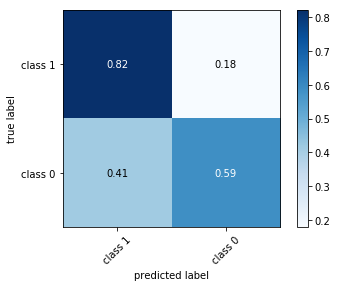

the confusion matrix:  [[790 171]
 [458 649]]
The ROC-AUC score for the test set is:  0.7304532404862256
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1224
           1       0.72      0.63      0.67       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.73      2080
weighted avg       0.75      0.75      0.74      2080



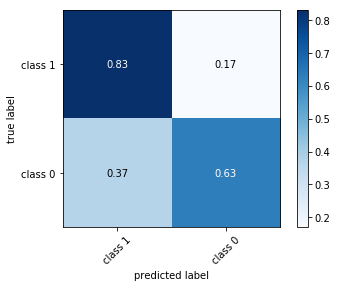

the confusion matrix:  [[1016  208]
 [ 316  540]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 3)
##############################
CPU times: user 1min 43s, sys: 1.45 s, total: 1min 45s
Wall time: 1min 45s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   38.8s finished


Best: 0.643362 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5414146285063267
              precision    recall  f1-score   support

           0       0.49      0.83      0.62       961
           1       0.63      0.25      0.36      1107

    accuracy                           0.52      2068
   macro avg       0.56      0.54      0.49      2068
weighted avg       0.57      0.52      0.48      2068



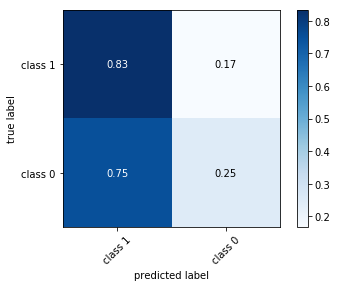

the confusion matrix:  [[801 160]
 [831 276]]
The ROC-AUC score for the test set is:  0.532668285382689
              precision    recall  f1-score   support

           0       0.61      0.84      0.71      1224
           1       0.50      0.23      0.31       856

    accuracy                           0.59      2080
   macro avg       0.55      0.53      0.51      2080
weighted avg       0.56      0.59      0.54      2080



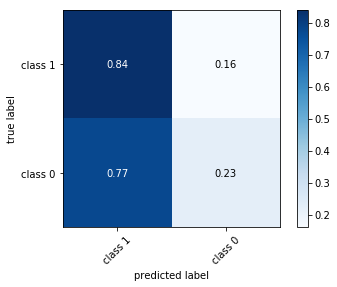

the confusion matrix:  [[1028  196]
 [ 663  193]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 3)
##############################
CPU times: user 4.34 s, sys: 87.9 ms, total: 4.42 s
Wall time: 4.43 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.4s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



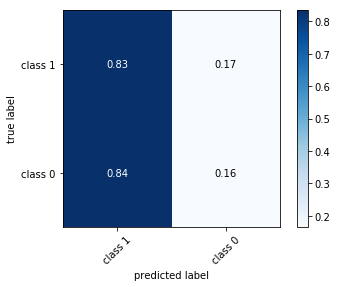

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



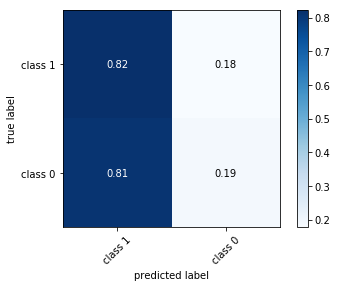

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 5)
##############################
CPU times: user 1min 20s, sys: 154 ms, total: 1min 20s
Wall time: 1min 20s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   39.5s finished


Best: 0.819735 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7046563961997581
              precision    recall  f1-score   support

           0       0.64      0.82      0.71       961
           1       0.79      0.59      0.68      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.70      2068
weighted avg       0.72      0.70      0.69      2068



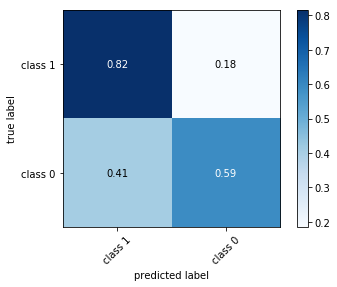

the confusion matrix:  [[784 177]
 [450 657]]
The ROC-AUC score for the test set is:  0.731564198888278
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1224
           1       0.72      0.64      0.68       856

    accuracy                           0.75      2080
   macro avg       0.74      0.73      0.74      2080
weighted avg       0.75      0.75      0.75      2080



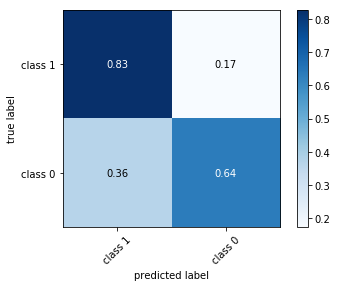

the confusion matrix:  [[1013  211]
 [ 312  544]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 5)
##############################
CPU times: user 1min 43s, sys: 1.22 s, total: 1min 44s
Wall time: 1min 44s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.6s finished


Best: 0.639919 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5387732215858405
              precision    recall  f1-score   support

           0       0.49      0.83      0.62       961
           1       0.63      0.24      0.35      1107

    accuracy                           0.52      2068
   macro avg       0.56      0.54      0.48      2068
weighted avg       0.56      0.52      0.47      2068



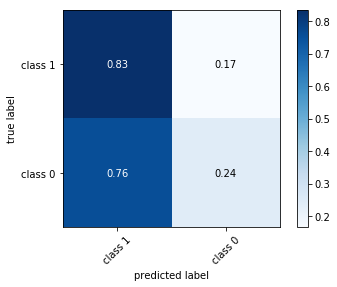

the confusion matrix:  [[802 159]
 [838 269]]
The ROC-AUC score for the test set is:  0.5337830615112087
              precision    recall  f1-score   support

           0       0.61      0.83      0.70      1224
           1       0.49      0.24      0.32       856

    accuracy                           0.59      2080
   macro avg       0.55      0.53      0.51      2080
weighted avg       0.56      0.59      0.55      2080



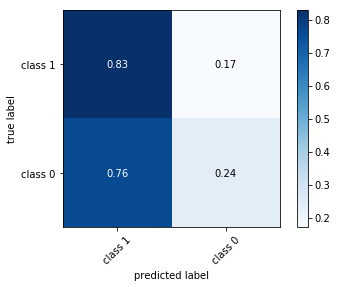

the confusion matrix:  [[1015  209]
 [ 652  204]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 5)
##############################
CPU times: user 4.37 s, sys: 83.6 ms, total: 4.46 s
Wall time: 4.46 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.3s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



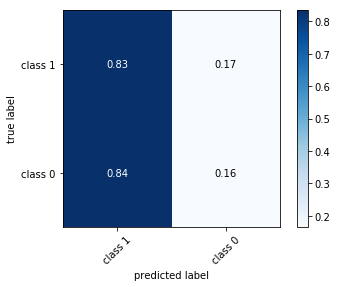

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



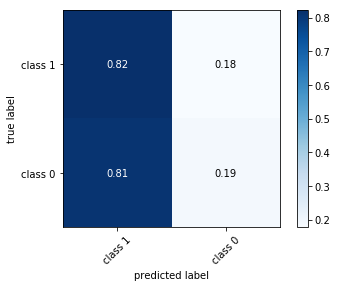

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 2)
##############################
CPU times: user 1min 57s, sys: 201 ms, total: 1min 57s
Wall time: 1min 57s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.7s finished


Best: 0.814237 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7001509643955267
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.78      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



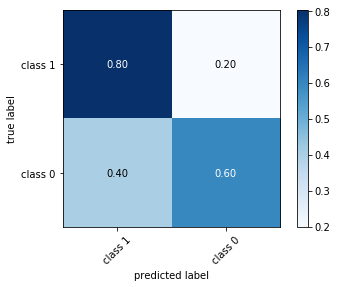

the confusion matrix:  [[771 190]
 [445 662]]
The ROC-AUC score for the test set is:  0.7218175432166637
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1224
           1       0.70      0.63      0.67       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.74      0.74      0.74      2080



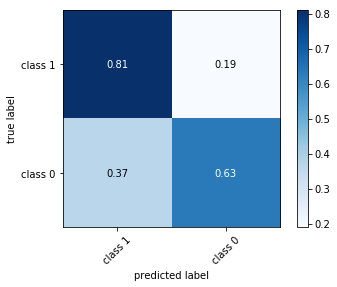

the confusion matrix:  [[992 232]
 [314 542]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 2)
##############################
CPU times: user 2min 26s, sys: 2.13 s, total: 2min 28s
Wall time: 2min 28s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.5s finished


Best: 0.642204 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5330048964728288
              precision    recall  f1-score   support

           0       0.48      0.88      0.62       961
           1       0.64      0.19      0.29      1107

    accuracy                           0.51      2068
   macro avg       0.56      0.53      0.46      2068
weighted avg       0.57      0.51      0.45      2068



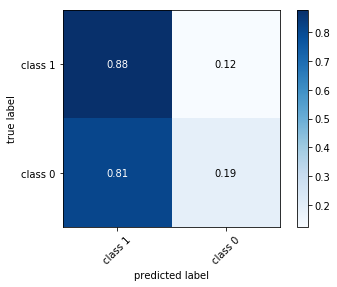

the confusion matrix:  [[843 118]
 [898 209]]
The ROC-AUC score for the test set is:  0.5291979720237004
              precision    recall  f1-score   support

           0       0.60      0.89      0.72      1224
           1       0.52      0.17      0.25       856

    accuracy                           0.59      2080
   macro avg       0.56      0.53      0.49      2080
weighted avg       0.57      0.59      0.53      2080



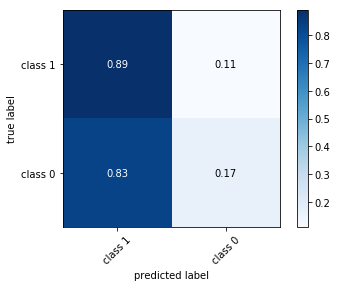

the confusion matrix:  [[1091  133]
 [ 713  143]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 2)
##############################
CPU times: user 6.6 s, sys: 79.5 ms, total: 6.68 s
Wall time: 6.69 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.4s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



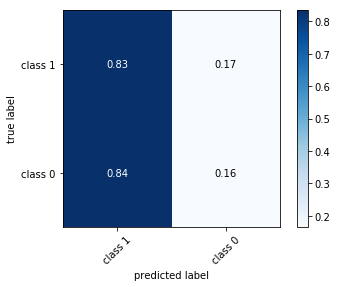

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



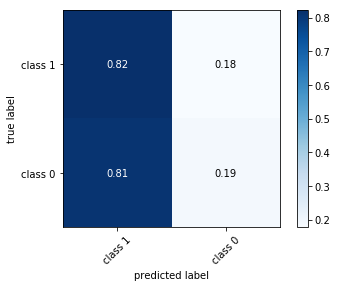

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 3)
##############################
CPU times: user 1min 58s, sys: 221 ms, total: 1min 58s
Wall time: 1min 58s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.7s finished


Best: 0.814306 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.702546560671989
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       961
           1       0.78      0.60      0.68      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.70      0.69      2068



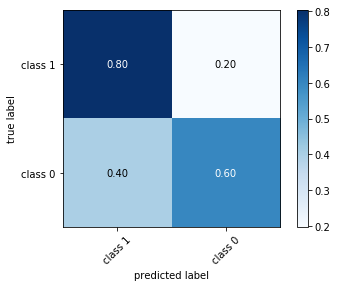

the confusion matrix:  [[773 188]
 [442 665]]
The ROC-AUC score for the test set is:  0.7155106590922974
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1224
           1       0.69      0.62      0.66       856

    accuracy                           0.73      2080
   macro avg       0.72      0.72      0.72      2080
weighted avg       0.73      0.73      0.73      2080



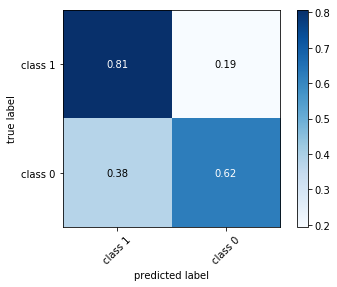

the confusion matrix:  [[988 236]
 [322 534]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 3)
##############################
CPU times: user 2min 27s, sys: 1.86 s, total: 2min 29s
Wall time: 2min 29s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   36.2s finished


Best: 0.635686 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5211129253158643
              precision    recall  f1-score   support

           0       0.48      0.89      0.62       961
           1       0.61      0.15      0.25      1107

    accuracy                           0.50      2068
   macro avg       0.55      0.52      0.43      2068
weighted avg       0.55      0.50      0.42      2068



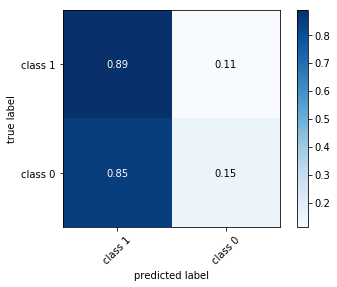

the confusion matrix:  [[854 107]
 [937 170]]
The ROC-AUC score for the test set is:  0.5268080752550242
              precision    recall  f1-score   support

           0       0.60      0.88      0.72      1224
           1       0.50      0.17      0.26       856

    accuracy                           0.59      2080
   macro avg       0.55      0.53      0.49      2080
weighted avg       0.56      0.59      0.53      2080



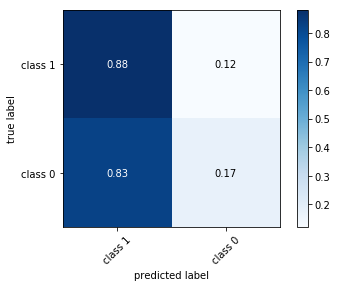

the confusion matrix:  [[1078  146]
 [ 708  148]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 3)
##############################
CPU times: user 6.53 s, sys: 76 ms, total: 6.61 s
Wall time: 6.61 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.3s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



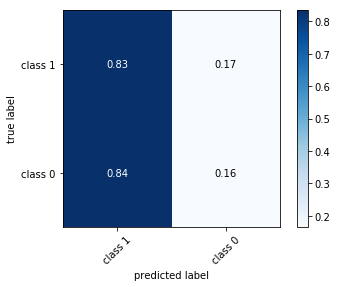

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



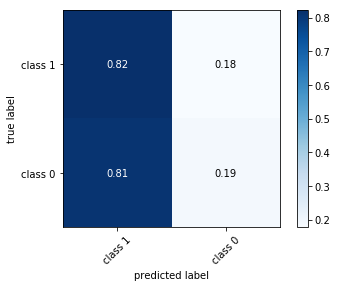

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 5)
##############################
CPU times: user 1min 57s, sys: 225 ms, total: 1min 57s
Wall time: 1min 57s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.8s finished


Best: 0.814056 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7003568249348813
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.60      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



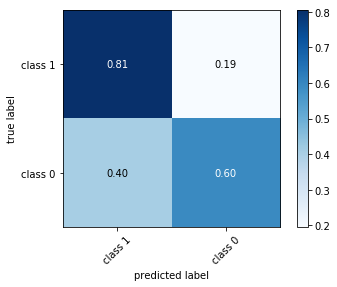

the confusion matrix:  [[774 187]
 [448 659]]
The ROC-AUC score for the test set is:  0.7199506749740395
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1224
           1       0.70      0.63      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



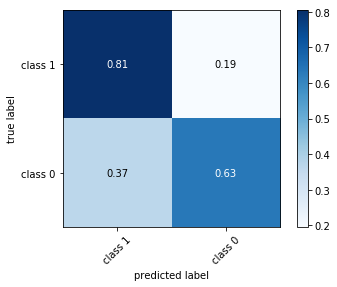

the confusion matrix:  [[986 238]
 [313 543]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 5)
##############################
CPU times: user 2min 32s, sys: 2.01 s, total: 2min 34s
Wall time: 2min 34s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   36.2s finished


Best: 0.632867 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.527041990850016
              precision    recall  f1-score   support

           0       0.48      0.90      0.63       961
           1       0.64      0.15      0.24      1107

    accuracy                           0.50      2068
   macro avg       0.56      0.53      0.44      2068
weighted avg       0.57      0.50      0.42      2068



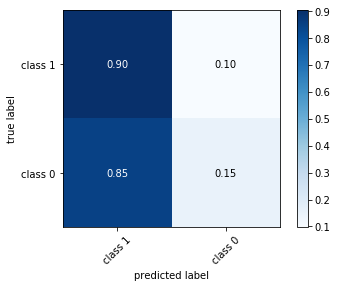

the confusion matrix:  [[868  93]
 [940 167]]
The ROC-AUC score for the test set is:  0.5348596603750534
              precision    recall  f1-score   support

           0       0.61      0.90      0.73      1224
           1       0.54      0.17      0.26       856

    accuracy                           0.60      2080
   macro avg       0.58      0.53      0.49      2080
weighted avg       0.58      0.60      0.53      2080



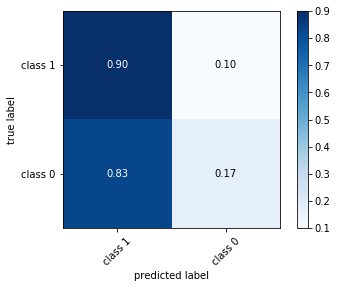

the confusion matrix:  [[1102  122]
 [ 711  145]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 5)
##############################
CPU times: user 6.58 s, sys: 76 ms, total: 6.66 s
Wall time: 6.66 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.4s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



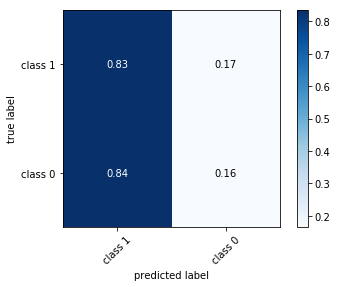

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



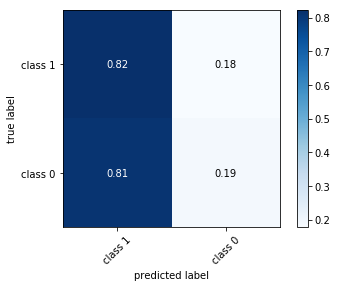

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 2)
##############################
CPU times: user 3min 15s, sys: 312 ms, total: 3min 15s
Wall time: 3min 15s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   32.7s finished


Best: 0.810026 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7142326712895988
              precision    recall  f1-score   support

           0       0.65      0.79      0.72       961
           1       0.78      0.64      0.70      1107

    accuracy                           0.71      2068
   macro avg       0.72      0.71      0.71      2068
weighted avg       0.72      0.71      0.71      2068



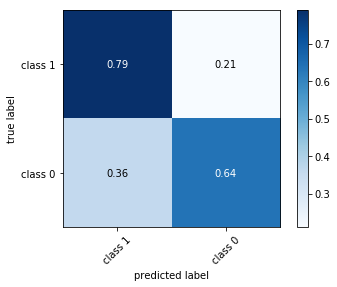

the confusion matrix:  [[759 202]
 [400 707]]
The ROC-AUC score for the test set is:  0.7047752122655915
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      1224
           1       0.67      0.63      0.65       856

    accuracy                           0.72      2080
   macro avg       0.71      0.70      0.71      2080
weighted avg       0.72      0.72      0.72      2080



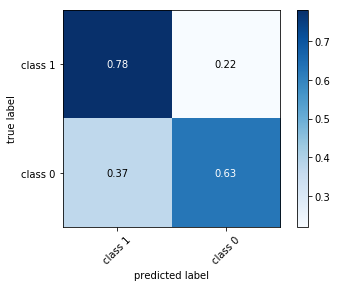

the confusion matrix:  [[956 268]
 [318 538]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 2)
##############################
CPU times: user 3min 56s, sys: 3.27 s, total: 3min 59s
Wall time: 3min 59s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   34.9s finished


Best: 0.627956 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5324220949458888
              precision    recall  f1-score   support

           0       0.48      0.91      0.63       961
           1       0.66      0.16      0.25      1107

    accuracy                           0.51      2068
   macro avg       0.57      0.53      0.44      2068
weighted avg       0.58      0.51      0.43      2068



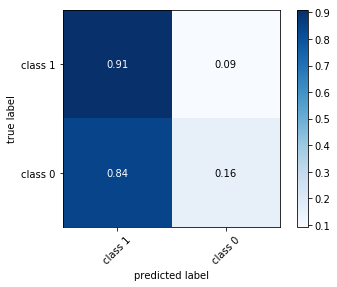

the confusion matrix:  [[874  87]
 [935 172]]
The ROC-AUC score for the test set is:  0.5210204019302425
              precision    recall  f1-score   support

           0       0.60      0.89      0.72      1224
           1       0.49      0.15      0.23       856

    accuracy                           0.59      2080
   macro avg       0.55      0.52      0.47      2080
weighted avg       0.56      0.59      0.52      2080



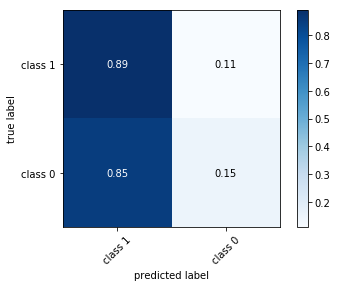

the confusion matrix:  [[1091  133]
 [ 727  129]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 2)
##############################
CPU times: user 10.8 s, sys: 183 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.3s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



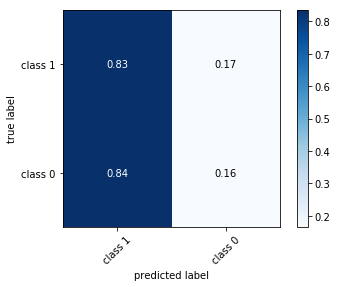

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



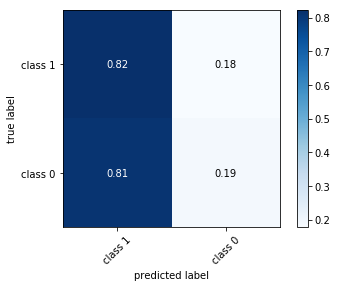

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 3)
##############################
CPU times: user 3min 13s, sys: 357 ms, total: 3min 14s
Wall time: 3min 14s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   34.0s finished


Best: 0.809049 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7110709730059493
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       961
           1       0.78      0.63      0.70      1107

    accuracy                           0.71      2068
   macro avg       0.71      0.71      0.71      2068
weighted avg       0.72      0.71      0.70      2068



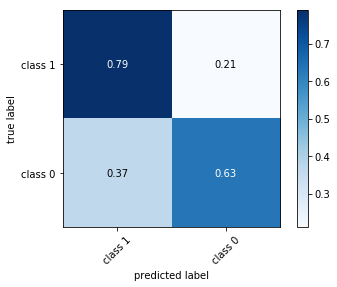

the confusion matrix:  [[759 202]
 [407 700]]
The ROC-AUC score for the test set is:  0.6995792865432778
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1224
           1       0.66      0.62      0.64       856

    accuracy                           0.71      2080
   macro avg       0.70      0.70      0.70      2080
weighted avg       0.71      0.71      0.71      2080



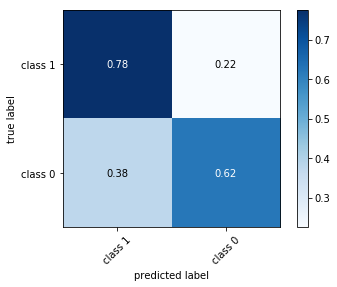

the confusion matrix:  [[949 275]
 [322 534]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 3)
##############################
CPU times: user 4min 1s, sys: 3.46 s, total: 4min 4s
Wall time: 4min 4s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.1s finished


Best: 0.629476 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5173684255052748
              precision    recall  f1-score   support

           0       0.47      0.92      0.63       961
           1       0.62      0.11      0.19      1107

    accuracy                           0.49      2068
   macro avg       0.55      0.52      0.41      2068
weighted avg       0.55      0.49      0.39      2068



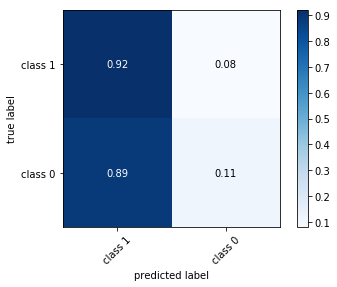

the confusion matrix:  [[885  76]
 [981 126]]
The ROC-AUC score for the test set is:  0.5247503206890233
              precision    recall  f1-score   support

           0       0.60      0.91      0.72      1224
           1       0.52      0.14      0.22       856

    accuracy                           0.59      2080
   macro avg       0.56      0.52      0.47      2080
weighted avg       0.57      0.59      0.52      2080



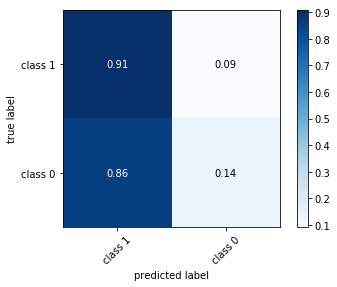

the confusion matrix:  [[1113  111]
 [ 736  120]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 3)
##############################
CPU times: user 10.9 s, sys: 175 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.4s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



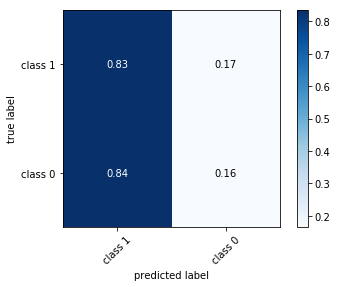

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



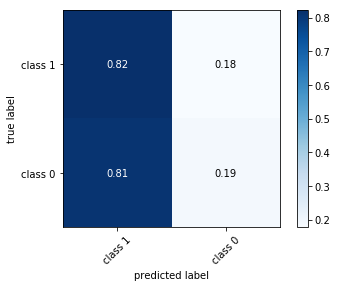

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 5)
##############################
CPU times: user 3min 15s, sys: 380 ms, total: 3min 16s
Wall time: 3min 16s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   33.9s finished


Best: 0.809428 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.7161366462780133
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       961
           1       0.78      0.63      0.70      1107

    accuracy                           0.71      2068
   macro avg       0.72      0.72      0.71      2068
weighted avg       0.72      0.71      0.71      2068



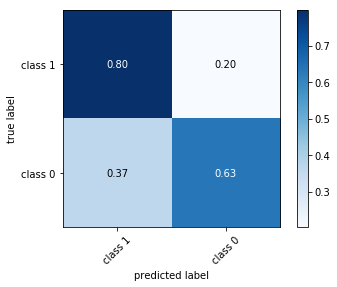

the confusion matrix:  [[767 194]
 [405 702]]
The ROC-AUC score for the test set is:  0.700045049172317
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1224
           1       0.66      0.62      0.64       856

    accuracy                           0.71      2080
   macro avg       0.70      0.70      0.70      2080
weighted avg       0.71      0.71      0.71      2080



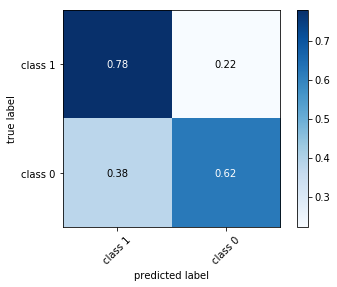

the confusion matrix:  [[953 271]
 [324 532]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 5)
##############################
CPU times: user 4min 7s, sys: 3.49 s, total: 4min 11s
Wall time: 4min 11s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   35.8s finished


Best: 0.625067 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.5146583984050037
              precision    recall  f1-score   support

           0       0.47      0.92      0.62       961
           1       0.61      0.11      0.18      1107

    accuracy                           0.49      2068
   macro avg       0.54      0.51      0.40      2068
weighted avg       0.55      0.49      0.39      2068



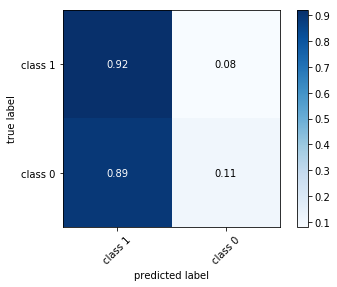

the confusion matrix:  [[885  76]
 [987 120]]
The ROC-AUC score for the test set is:  0.5238722436014905
              precision    recall  f1-score   support

           0       0.60      0.91      0.73      1224
           1       0.52      0.13      0.21       856

    accuracy                           0.59      2080
   macro avg       0.56      0.52      0.47      2080
weighted avg       0.57      0.59      0.51      2080



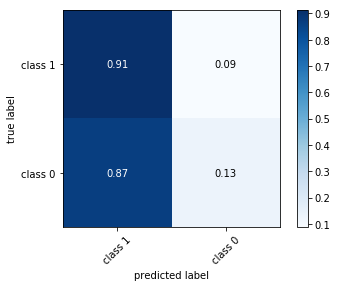

the confusion matrix:  [[1118  106]
 [ 741  115]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 5)
##############################
CPU times: user 10.9 s, sys: 184 ms, total: 11 s
Wall time: 11.1 s
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.3s finished


Best: 0.500515 using {'clf__class_weight': None, 'clf__penalty': 'l2'}
The ROC-AUC score for the test set is:  0.4989575372687477
              precision    recall  f1-score   support

           0       0.46      0.83      0.60       961
           1       0.53      0.16      0.25      1107

    accuracy                           0.48      2068
   macro avg       0.50      0.50      0.42      2068
weighted avg       0.50      0.48      0.41      2068



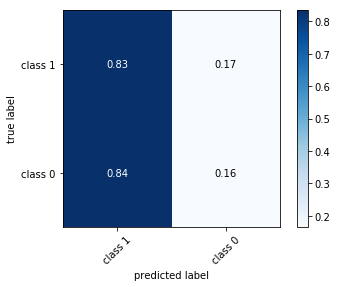

the confusion matrix:  [[801 160]
 [925 182]]
The ROC-AUC score for the test set is:  0.5053982652250931
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1224
           1       0.43      0.19      0.26       856

    accuracy                           0.56      2080
   macro avg       0.51      0.51      0.47      2080
weighted avg       0.52      0.56      0.51      2080



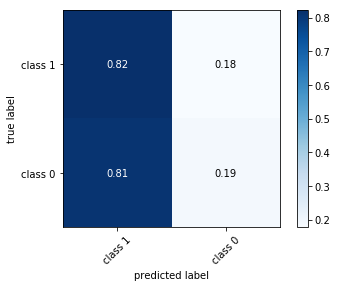

the confusion matrix:  [[1007  217]
 [ 695  161]]
---------------------------------------------------------------
##################################################
Executing  svm  pipeline...
##################################################
------------------------------
Training set has  23241  positive instances and  28336  negative instances.
Test set 1 has  1107  positive instances and  961  negative instances.
Test set 2 has  856  positive instances and  1224  negative instances.
------------------------------


Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 2)
##############################
CPU times: user 56.3 s, sys: 147 ms, total: 56.4 s
Wall time: 56.4 s
Fitting 3 folds for each of 1 candidates, totalling 3 fit

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.807870 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.697480887399925
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.77      0.60      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



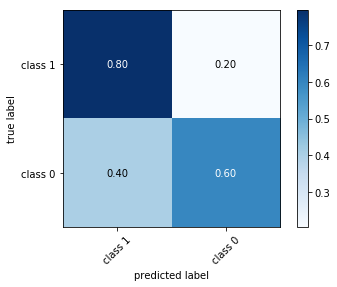

the confusion matrix:  [[765 196]
 [444 663]]
The ROC-AUC score for the test set is:  0.7104788956080875
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1224
           1       0.70      0.60      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.73      0.73      0.73      2080



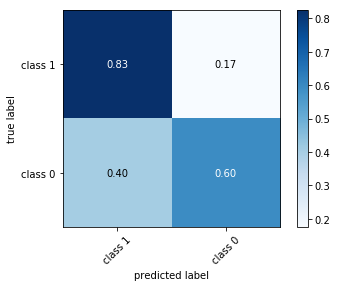

the confusion matrix:  [[1010  214]
 [ 346  510]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 2)
##############################
CPU times: user 1min 22s, sys: 1.22 s, total: 1min 23s
Wall time: 1min 23s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.617742 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5590227546396171
              precision    recall  f1-score   support

           0       0.51      0.72      0.60       961
           1       0.62      0.40      0.49      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.54      2068
weighted avg       0.57      0.55      0.54      2068



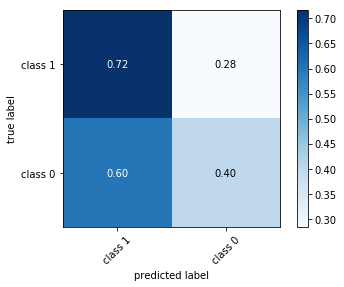

the confusion matrix:  [[689 272]
 [663 444]]
The ROC-AUC score for the test set is:  0.5615188442978437
              precision    recall  f1-score   support

           0       0.63      0.72      0.68      1224
           1       0.50      0.40      0.44       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



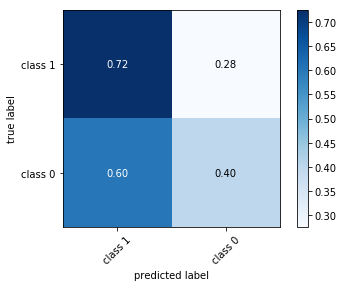

the confusion matrix:  [[887 337]
 [515 341]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 2)
##############################
CPU times: user 4.39 s, sys: 56.2 ms, total: 4.44 s
Wall time: 4.45 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


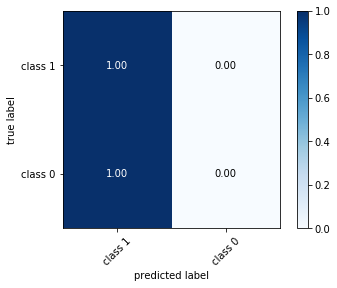

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


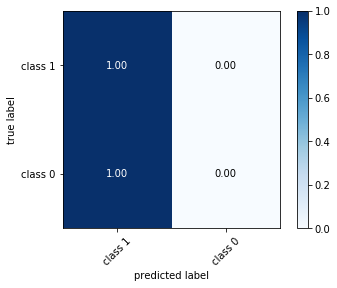

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 3)
##############################
CPU times: user 56 s, sys: 119 ms, total: 56.1 s
Wall time: 56.2 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.807628 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6975894576843791
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



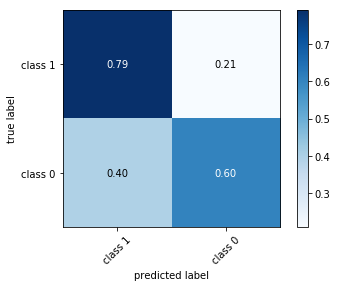

the confusion matrix:  [[760 201]
 [438 669]]
The ROC-AUC score for the test set is:  0.7084364119479568
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1224
           1       0.70      0.60      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.73      0.73      0.72      2080



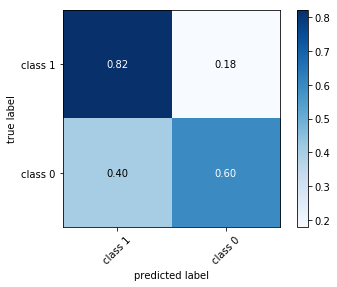

the confusion matrix:  [[1005  219]
 [ 346  510]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 3)
##############################
CPU times: user 1min 23s, sys: 1.24 s, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.617836 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5624302635672905
              precision    recall  f1-score   support

           0       0.51      0.71      0.60       961
           1       0.62      0.41      0.50      1107

    accuracy                           0.55      2068
   macro avg       0.57      0.56      0.55      2068
weighted avg       0.57      0.55      0.54      2068



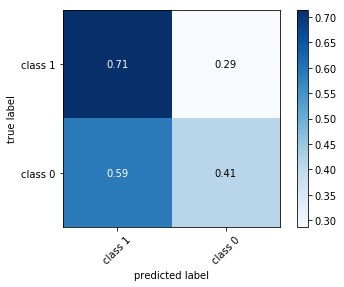

the confusion matrix:  [[686 275]
 [652 455]]
The ROC-AUC score for the test set is:  0.5595488974405961
              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1224
           1       0.49      0.43      0.46       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.58      0.58      0.58      2080



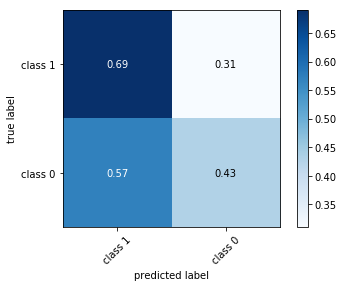

the confusion matrix:  [[845 379]
 [489 367]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 3)
##############################
CPU times: user 4.32 s, sys: 76.2 ms, total: 4.4 s
Wall time: 4.4 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


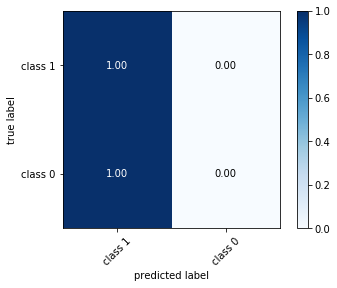

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


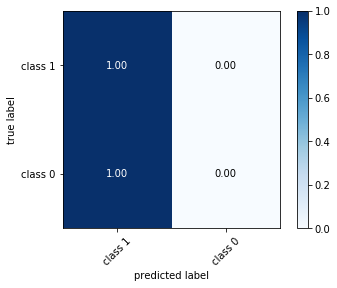

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 5)
##############################
CPU times: user 56.4 s, sys: 63 ms, total: 56.5 s
Wall time: 56.5 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.806919 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6995333827774629
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       961
           1       0.77      0.61      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



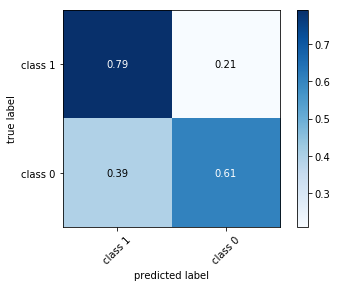

the confusion matrix:  [[762 199]
 [436 671]]
The ROC-AUC score for the test set is:  0.7074972512369433
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1224
           1       0.71      0.58      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.73      0.73      0.72      2080



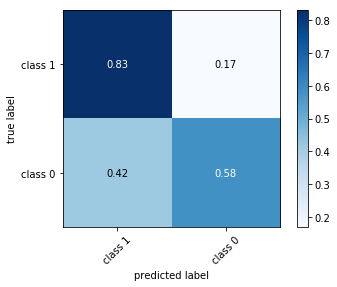

the confusion matrix:  [[1017  207]
 [ 356  500]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 5)
##############################
CPU times: user 1min 24s, sys: 1.18 s, total: 1min 25s
Wall time: 1min 25s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.620668 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5699601532956016
              precision    recall  f1-score   support

           0       0.52      0.73      0.60       961
           1       0.63      0.41      0.50      1107

    accuracy                           0.56      2068
   macro avg       0.58      0.57      0.55      2068
weighted avg       0.58      0.56      0.55      2068



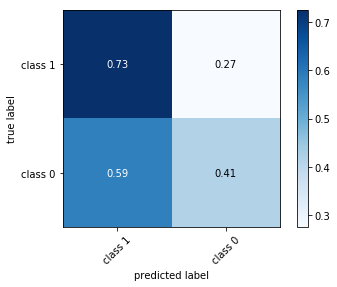

the confusion matrix:  [[697 264]
 [648 459]]
The ROC-AUC score for the test set is:  0.5537154113982041
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1224
           1       0.48      0.43      0.46       856

    accuracy                           0.57      2080
   macro avg       0.56      0.55      0.55      2080
weighted avg       0.57      0.57      0.57      2080



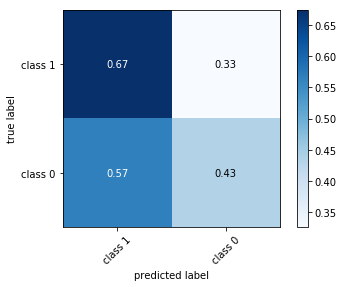

the confusion matrix:  [[825 399]
 [485 371]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 5)
##############################
CPU times: user 4.36 s, sys: 75.8 ms, total: 4.43 s
Wall time: 4.43 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


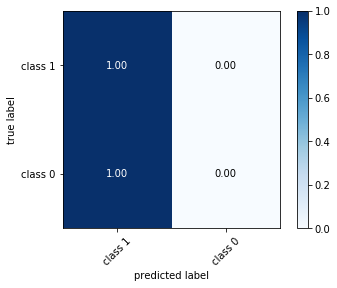

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


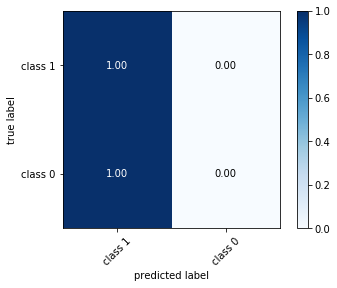

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 2)
##############################
CPU times: user 1min 24s, sys: 126 ms, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.803462 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6931014159257097
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       961
           1       0.77      0.59      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.69      0.68      2068



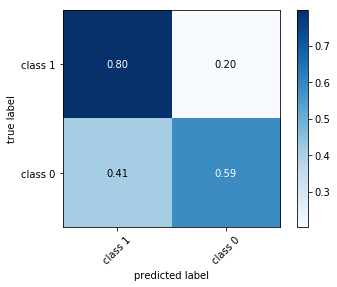

the confusion matrix:  [[767 194]
 [456 651]]
The ROC-AUC score for the test set is:  0.7134032740822186
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



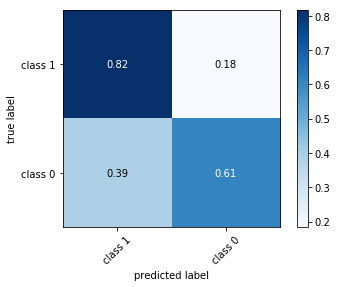

the confusion matrix:  [[1000  224]
 [ 334  522]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 2)
##############################
CPU times: user 2min 2s, sys: 1.82 s, total: 2min 4s
Wall time: 2min 4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.606383 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5633909460842788
              precision    recall  f1-score   support

           0       0.51      0.73      0.60       961
           1       0.63      0.40      0.49      1107

    accuracy                           0.55      2068
   macro avg       0.57      0.56      0.54      2068
weighted avg       0.57      0.55      0.54      2068



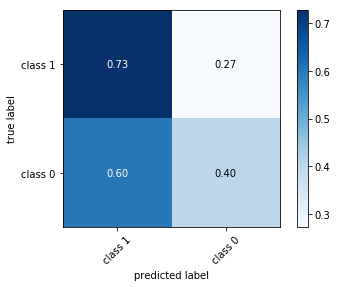

the confusion matrix:  [[700 261]
 [666 441]]
The ROC-AUC score for the test set is:  0.5465151792804349
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1224
           1       0.48      0.39      0.43       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.54      2080
weighted avg       0.56      0.57      0.57      2080



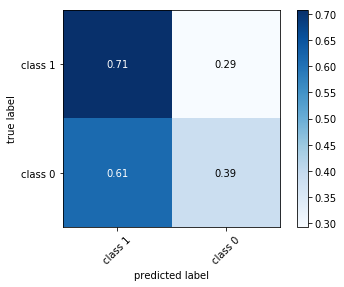

the confusion matrix:  [[866 358]
 [526 330]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 2)
##############################
CPU times: user 6.53 s, sys: 128 ms, total: 6.66 s
Wall time: 6.67 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


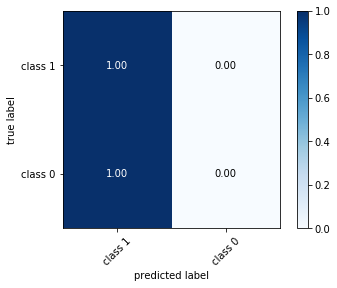

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


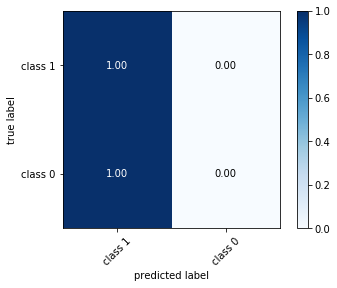

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 3)
##############################
CPU times: user 1min 24s, sys: 183 ms, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.804704 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.691883642735144
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       961
           1       0.77      0.58      0.66      1107

    accuracy                           0.68      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



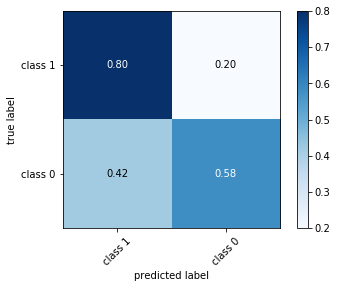

the confusion matrix:  [[769 192]
 [461 646]]
The ROC-AUC score for the test set is:  0.7171980941909474
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1224
           1       0.71      0.61      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



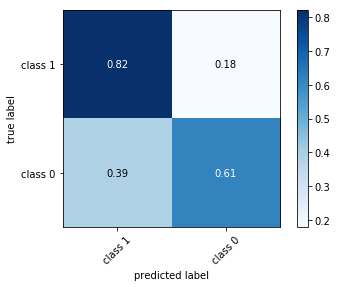

the confusion matrix:  [[1005  219]
 [ 331  525]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 3)
##############################
CPU times: user 2min 4s, sys: 1.95 s, total: 2min 6s
Wall time: 2min 6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.610961 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5452206984782301
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       961
           1       0.60      0.40      0.48      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.55      0.53      2068
weighted avg       0.55      0.54      0.53      2068



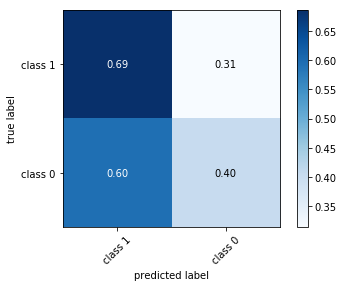

the confusion matrix:  [[659 302]
 [659 448]]
The ROC-AUC score for the test set is:  0.5633398998228574
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1224
           1       0.50      0.42      0.46       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



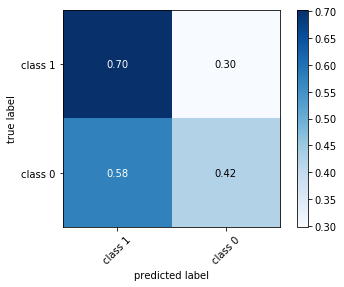

the confusion matrix:  [[860 364]
 [493 363]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 3)
##############################
CPU times: user 6.58 s, sys: 96.1 ms, total: 6.67 s
Wall time: 6.68 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


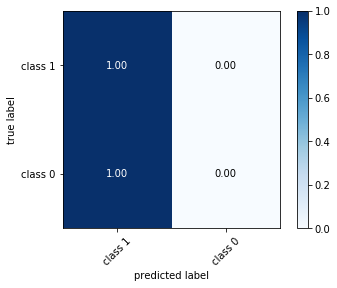

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


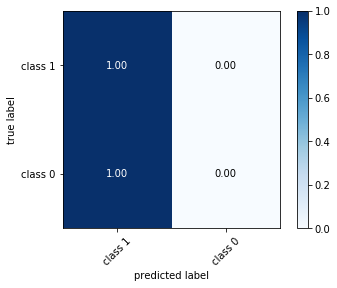

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 5)
##############################
CPU times: user 1min 24s, sys: 143 ms, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.802840 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6933758966448492
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       961
           1       0.77      0.58      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.69      0.68      2068



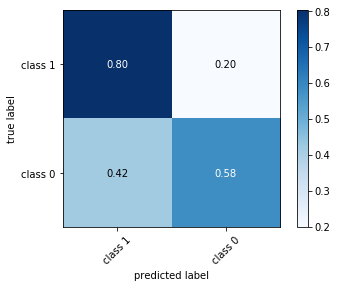

the confusion matrix:  [[771 190]
 [460 647]]
The ROC-AUC score for the test set is:  0.7121167002626595
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.60      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



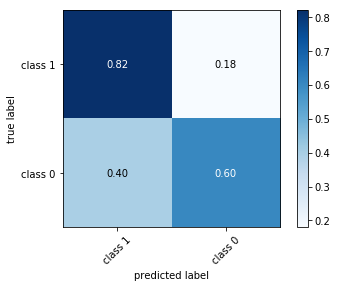

the confusion matrix:  [[1004  220]
 [ 339  517]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 5)
##############################
CPU times: user 2min 8s, sys: 2.05 s, total: 2min 10s
Wall time: 2min 10s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.617239 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5602405278301829
              precision    recall  f1-score   support

           0       0.51      0.71      0.60       961
           1       0.62      0.41      0.49      1107

    accuracy                           0.55      2068
   macro avg       0.57      0.56      0.54      2068
weighted avg       0.57      0.55      0.54      2068



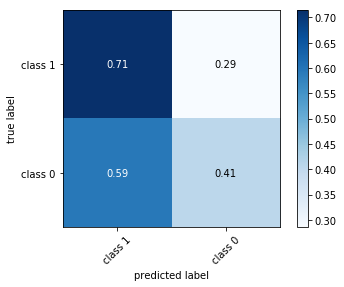

the confusion matrix:  [[687 274]
 [658 449]]
The ROC-AUC score for the test set is:  0.5561053081668804
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      1224
           1       0.49      0.43      0.46       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.58      0.57      2080



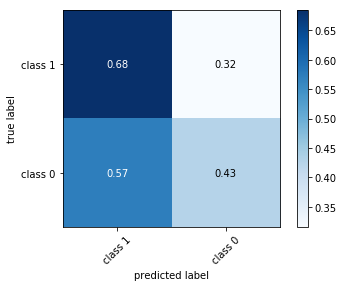

the confusion matrix:  [[838 386]
 [490 366]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 5)
##############################
CPU times: user 6.59 s, sys: 88 ms, total: 6.67 s
Wall time: 6.68 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


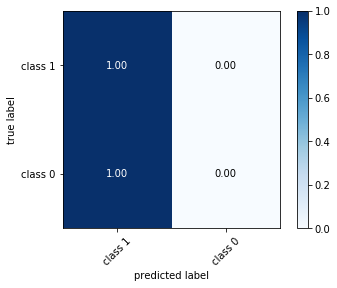

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


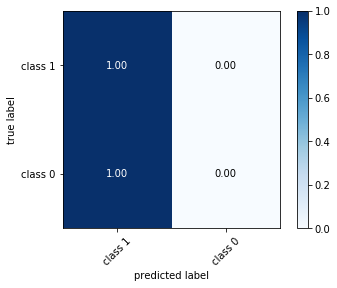

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 2)
##############################
CPU times: user 2min 20s, sys: 298 ms, total: 2min 20s
Wall time: 2min 20s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.798417 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6917863524802436
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.59      0.67      1107

    accuracy                           0.68      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



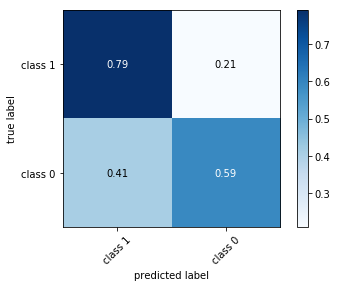

the confusion matrix:  [[761 200]
 [452 655]]
The ROC-AUC score for the test set is:  0.7086120273654632
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1224
           1       0.70      0.60      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.73      0.73      0.72      2080



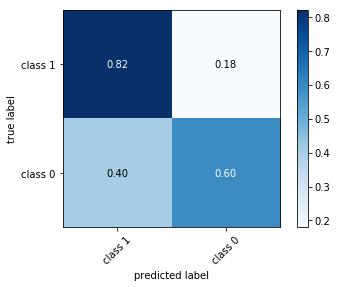

the confusion matrix:  [[1004  220]
 [ 345  511]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 2)
##############################
CPU times: user 3min 22s, sys: 3.16 s, total: 3min 25s
Wall time: 3min 25s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.605026 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5664727441585897
              precision    recall  f1-score   support

           0       0.51      0.74      0.61       961
           1       0.64      0.39      0.48      1107

    accuracy                           0.55      2068
   macro avg       0.57      0.57      0.55      2068
weighted avg       0.58      0.55      0.54      2068



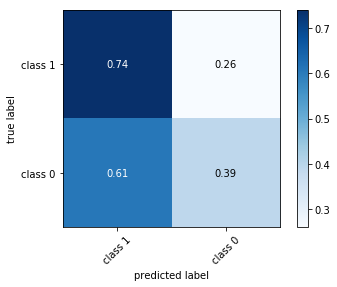

the confusion matrix:  [[712 249]
 [673 434]]
The ROC-AUC score for the test set is:  0.562343473214831
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1224
           1       0.50      0.41      0.45       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



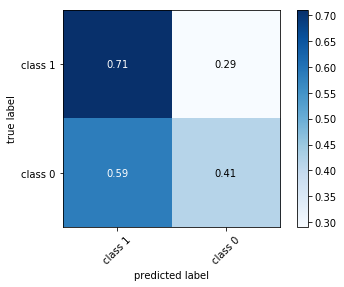

the confusion matrix:  [[869 355]
 [501 355]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 2)
##############################
CPU times: user 10.9 s, sys: 192 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


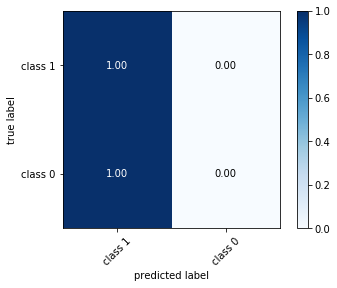

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


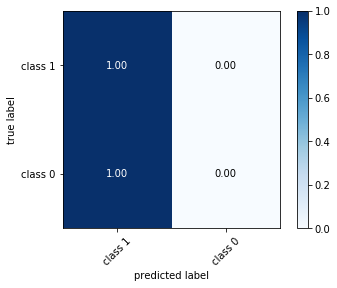

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 3)
##############################
CPU times: user 2min 20s, sys: 222 ms, total: 2min 20s
Wall time: 2min 20s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.798298 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.696400354568929
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.77      0.59      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



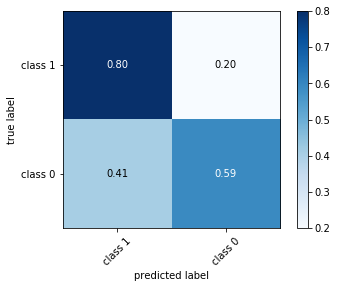

the confusion matrix:  [[769 192]
 [451 656]]
The ROC-AUC score for the test set is:  0.7090281595504245
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      1224
           1       0.69      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.73      0.72      2080



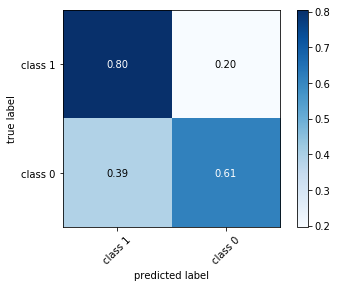

the confusion matrix:  [[985 239]
 [331 525]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 3)
##############################
CPU times: user 3min 29s, sys: 3.37 s, total: 3min 33s
Wall time: 3min 33s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.608294 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5516474953164378
              precision    recall  f1-score   support

           0       0.50      0.73      0.59       961
           1       0.61      0.37      0.47      1107

    accuracy                           0.54      2068
   macro avg       0.56      0.55      0.53      2068
weighted avg       0.56      0.54      0.53      2068



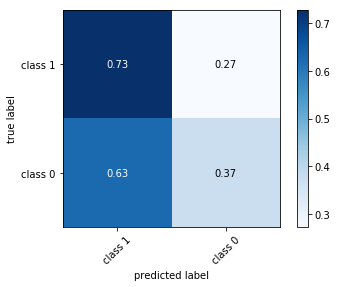

the confusion matrix:  [[700 261]
 [692 415]]
The ROC-AUC score for the test set is:  0.5556891759819192
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1224
           1       0.49      0.41      0.45       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.58      0.57      2080



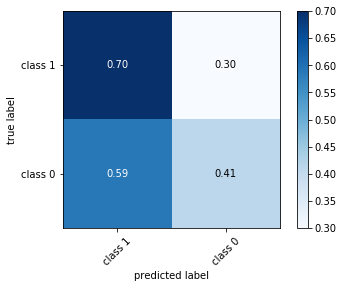

the confusion matrix:  [[857 367]
 [504 352]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 3)
##############################
CPU times: user 10.9 s, sys: 140 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.4s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


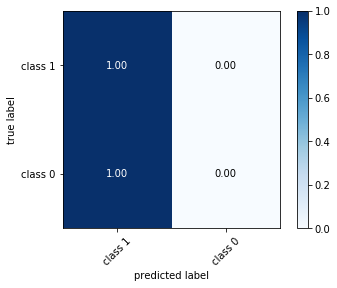

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


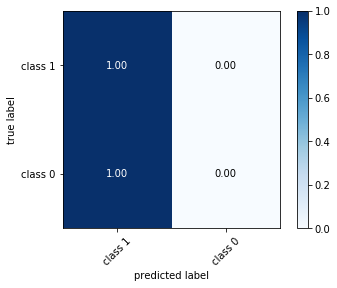

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 5)
##############################
CPU times: user 2min 20s, sys: 298 ms, total: 2min 20s
Wall time: 2min 20s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.799121 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.688075692758315
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       961
           1       0.76      0.59      0.67      1107

    accuracy                           0.68      2068
   macro avg       0.69      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



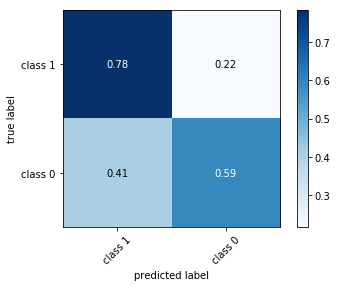

the confusion matrix:  [[753 208]
 [451 656]]
The ROC-AUC score for the test set is:  0.7080317329423981
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1224
           1       0.69      0.60      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.73      0.72      2080



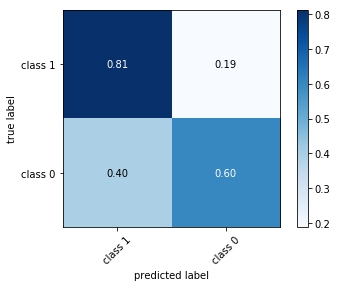

the confusion matrix:  [[994 230]
 [339 517]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 5)
##############################
CPU times: user 3min 27s, sys: 3.19 s, total: 3min 30s
Wall time: 3min 30s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.603496 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5445406066963896
              precision    recall  f1-score   support

           0       0.50      0.71      0.59       961
           1       0.60      0.38      0.47      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.54      0.53      2068
weighted avg       0.55      0.53      0.52      2068



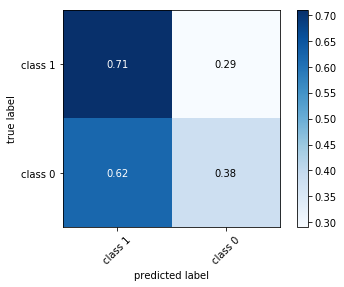

the confusion matrix:  [[682 279]
 [687 420]]
The ROC-AUC score for the test set is:  0.5787024311282145
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      1224
           1       0.52      0.46      0.48       856

    accuracy                           0.60      2080
   macro avg       0.58      0.58      0.58      2080
weighted avg       0.59      0.60      0.60      2080



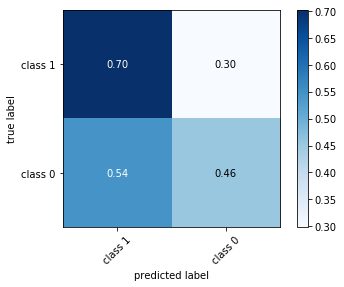

the confusion matrix:  [[859 365]
 [466 390]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 5)
##############################
CPU times: user 10.9 s, sys: 191 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.509027 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


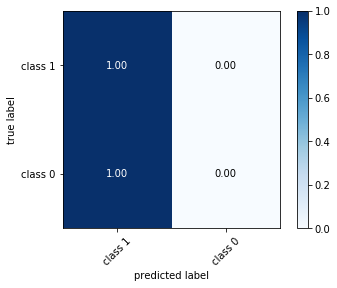

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


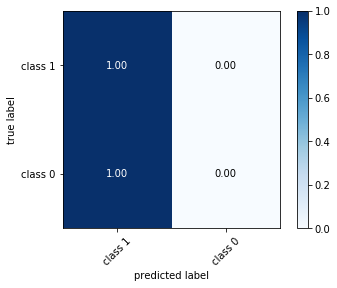

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 2)
##############################
CPU times: user 1min 9s, sys: 154 ms, total: 1min 9s
Wall time: 1min 9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.809728 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6948794305841082
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.60      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.69      0.69      2068
weighted avg       0.70      0.69      0.69      2068



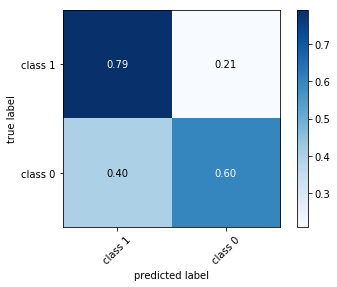

the confusion matrix:  [[760 201]
 [444 663]]
The ROC-AUC score for the test set is:  0.7135788894997251
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



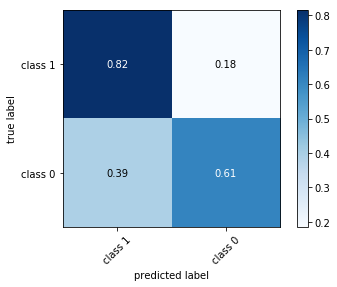

the confusion matrix:  [[999 225]
 [333 523]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 2)
##############################
CPU times: user 1min 30s, sys: 1.33 s, total: 1min 32s
Wall time: 1min 32s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.621642 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5647971897686371
              precision    recall  f1-score   support

           0       0.52      0.71      0.60       961
           1       0.62      0.42      0.50      1107

    accuracy                           0.55      2068
   macro avg       0.57      0.56      0.55      2068
weighted avg       0.57      0.55      0.55      2068



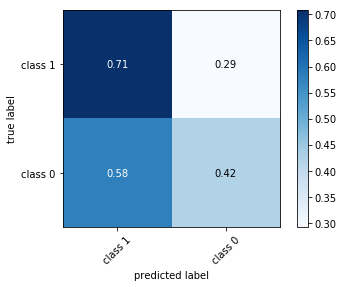

the confusion matrix:  [[681 280]
 [641 466]]
The ROC-AUC score for the test set is:  0.5639278296988577
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1224
           1       0.50      0.43      0.46       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



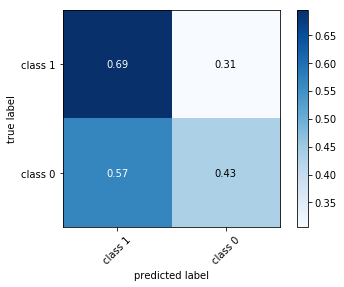

the confusion matrix:  [[850 374]
 [485 371]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 2)
##############################
CPU times: user 4.3 s, sys: 96 ms, total: 4.39 s
Wall time: 4.39 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


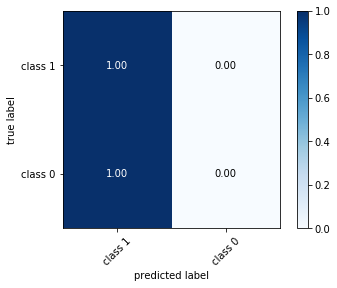

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


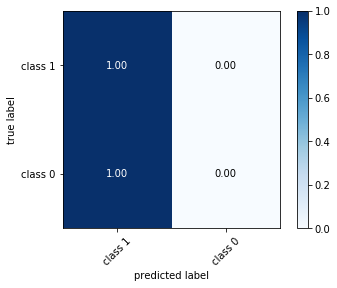

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 3)
##############################
CPU times: user 1min 7s, sys: 142 ms, total: 1min 7s
Wall time: 1min 7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.809790 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.7027237511362281
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       961
           1       0.78      0.61      0.68      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.70      2068
weighted avg       0.71      0.70      0.69      2068



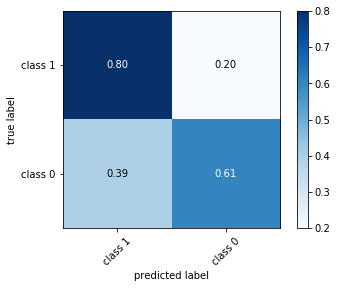

the confusion matrix:  [[769 192]
 [437 670]]
The ROC-AUC score for the test set is:  0.7125251969946856
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.60      0.65       856

    accuracy                           0.73      2080
   macro avg       0.73      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



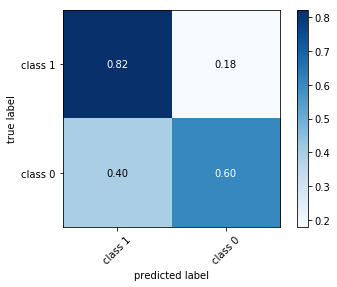

the confusion matrix:  [[1005  219]
 [ 339  517]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 3)
##############################
CPU times: user 1min 33s, sys: 1.27 s, total: 1min 34s
Wall time: 1min 34s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.622450 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5708461056167966
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       961
           1       0.63      0.44      0.52      1107

    accuracy                           0.56      2068
   macro avg       0.58      0.57      0.56      2068
weighted avg       0.58      0.56      0.55      2068



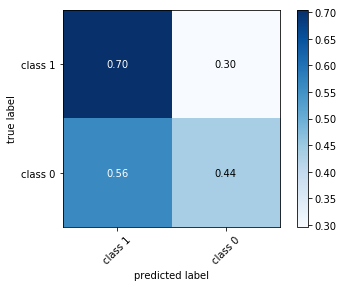

the confusion matrix:  [[677 284]
 [623 484]]
The ROC-AUC score for the test set is:  0.5640461792193513
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1224
           1       0.50      0.44      0.47       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



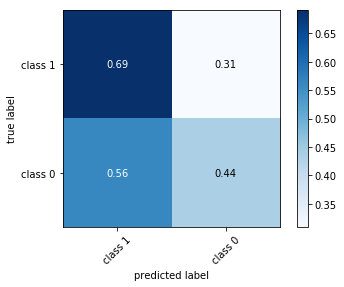

the confusion matrix:  [[846 378]
 [482 374]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 3)
##############################
CPU times: user 4.35 s, sys: 79.6 ms, total: 4.43 s
Wall time: 4.43 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


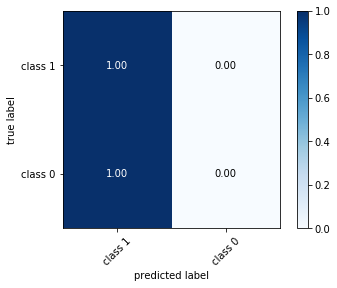

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


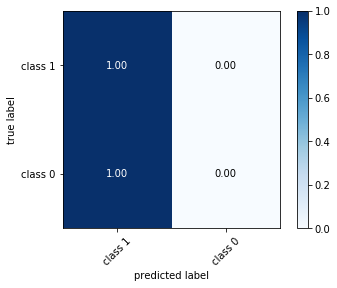

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 5)
##############################
CPU times: user 1min 8s, sys: 135 ms, total: 1min 8s
Wall time: 1min 8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.809460 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6967547354974071
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



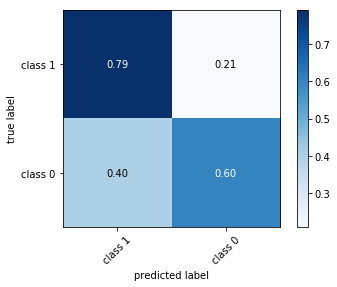

the confusion matrix:  [[761 200]
 [441 666]]
The ROC-AUC score for the test set is:  0.7141630016492578
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.73      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



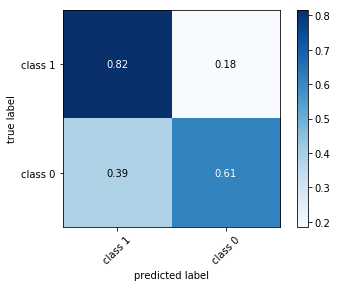

the confusion matrix:  [[999 225]
 [332 524]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 5)
##############################
CPU times: user 1min 32s, sys: 1.31 s, total: 1min 34s
Wall time: 1min 34s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.624059 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5573246401905574
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       961
           1       0.62      0.40      0.49      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.54      2068
weighted avg       0.57      0.55      0.54      2068



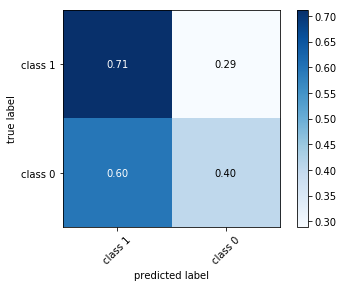

the confusion matrix:  [[684 277]
 [661 446]]
The ROC-AUC score for the test set is:  0.5574491478834525
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      1224
           1       0.49      0.43      0.46       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.58      0.58      2080



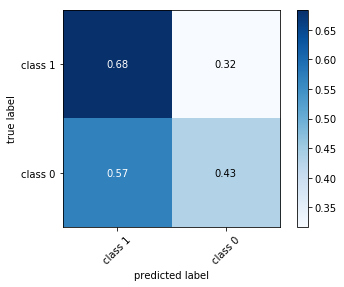

the confusion matrix:  [[837 387]
 [487 369]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 5)
##############################
CPU times: user 4.44 s, sys: 75.5 ms, total: 4.52 s
Wall time: 4.52 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


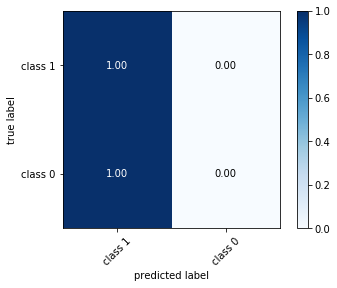

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


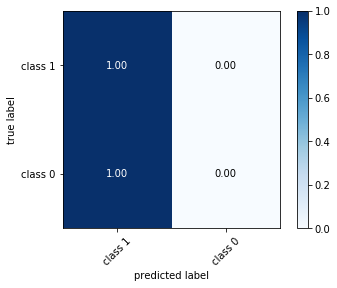

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 2)
##############################
CPU times: user 1min 41s, sys: 198 ms, total: 1min 41s
Wall time: 1min 41s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.805978 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6931987061806102
              precision    recall  f1-score   support

           0       0.62      0.81      0.70       961
           1       0.78      0.58      0.66      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.71      0.69      0.68      2068



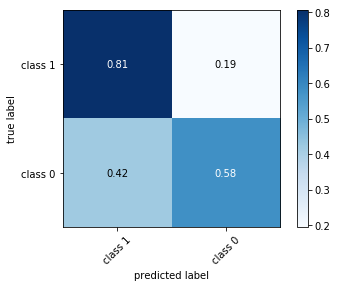

the confusion matrix:  [[775 186]
 [465 642]]
The ROC-AUC score for the test set is:  0.7210578156496243
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1224
           1       0.70      0.63      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



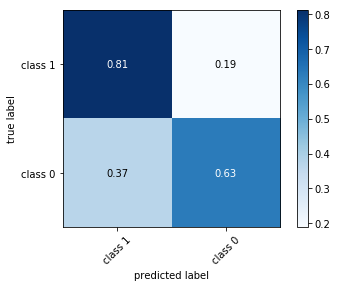

the confusion matrix:  [[993 231]
 [316 540]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 2)
##############################
CPU times: user 2min 14s, sys: 2.06 s, total: 2min 16s
Wall time: 2min 16s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.609191 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5544773727307165
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       961
           1       0.61      0.40      0.48      1107

    accuracy                           0.54      2068
   macro avg       0.56      0.55      0.54      2068
weighted avg       0.56      0.54      0.53      2068



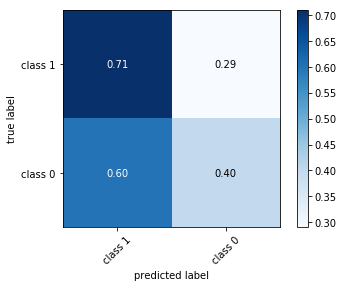

the confusion matrix:  [[682 279]
 [665 442]]
The ROC-AUC score for the test set is:  0.5518905381467228
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1224
           1       0.49      0.40      0.44       856

    accuracy                           0.58      2080
   macro avg       0.56      0.55      0.55      2080
weighted avg       0.57      0.58      0.57      2080



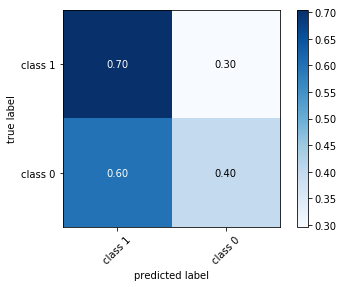

the confusion matrix:  [[862 362]
 [514 342]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 2)
##############################
CPU times: user 6.59 s, sys: 99.7 ms, total: 6.69 s
Wall time: 6.7 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


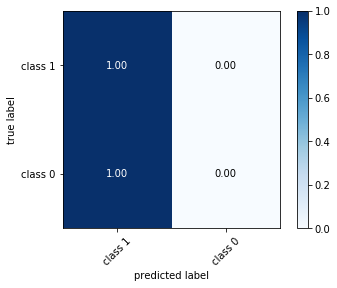

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


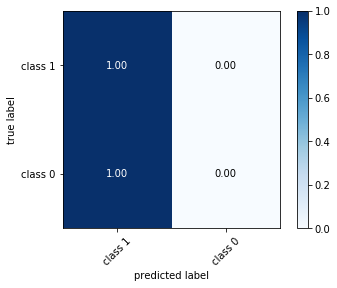

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 3)
##############################
CPU times: user 1min 42s, sys: 199 ms, total: 1min 43s
Wall time: 1min 43s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.806219 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6995221027479092
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       961
           1       0.78      0.59      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



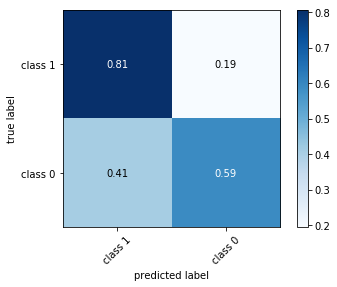

the confusion matrix:  [[775 186]
 [451 656]]
The ROC-AUC score for the test set is:  0.7151556105308167
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.73      0.73      2080



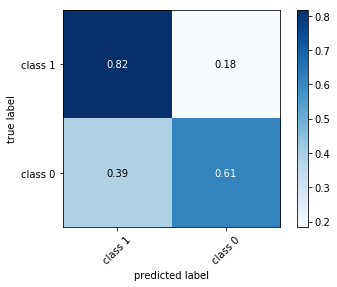

the confusion matrix:  [[1000  224]
 [ 331  525]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 3)
##############################
CPU times: user 2min 15s, sys: 1.95 s, total: 2min 17s
Wall time: 2min 17s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.617105 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5413215682625089
              precision    recall  f1-score   support

           0       0.50      0.70      0.58       961
           1       0.59      0.39      0.47      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.54      0.52      2068
weighted avg       0.55      0.53      0.52      2068



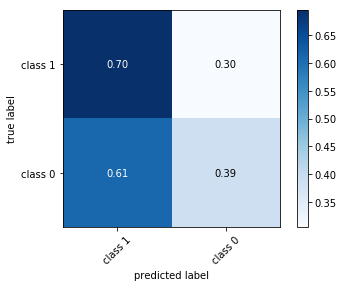

the confusion matrix:  [[668 293]
 [678 429]]
The ROC-AUC score for the test set is:  0.5309999389163765
              precision    recall  f1-score   support

           0       0.61      0.66      0.64      1224
           1       0.45      0.40      0.43       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.53      2080
weighted avg       0.55      0.55      0.55      2080



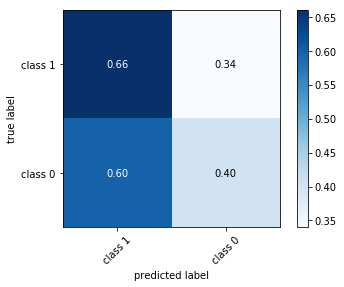

the confusion matrix:  [[808 416]
 [512 344]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 3)
##############################
CPU times: user 6.51 s, sys: 95.9 ms, total: 6.6 s
Wall time: 6.61 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


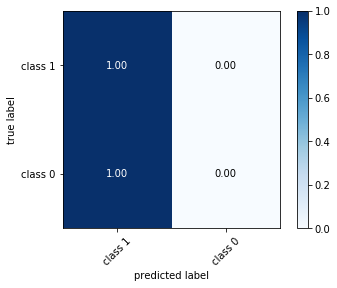

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


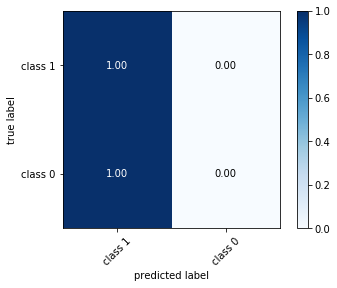

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 5)
##############################
CPU times: user 1min 41s, sys: 126 ms, total: 1min 41s
Wall time: 1min 41s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.806515 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6933758966448492
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       961
           1       0.77      0.58      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.69      0.68      2068



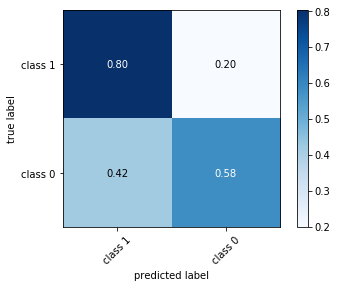

the confusion matrix:  [[771 190]
 [460 647]]
The ROC-AUC score for the test set is:  0.718896982469
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1224
           1       0.70      0.63      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



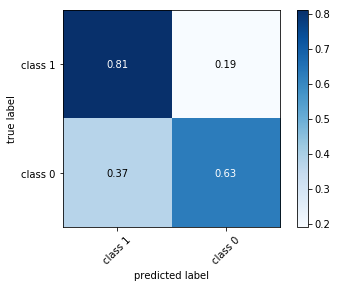

the confusion matrix:  [[992 232]
 [319 537]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 5)
##############################
CPU times: user 2min 19s, sys: 2.04 s, total: 2min 21s
Wall time: 2min 21s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.613382 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5378167690799349
              precision    recall  f1-score   support

           0       0.49      0.69      0.58       961
           1       0.59      0.39      0.47      1107

    accuracy                           0.53      2068
   macro avg       0.54      0.54      0.52      2068
weighted avg       0.54      0.53      0.52      2068



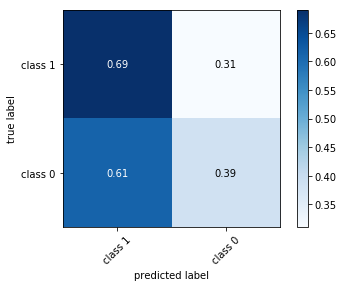

the confusion matrix:  [[663 298]
 [680 427]]
The ROC-AUC score for the test set is:  0.5728613096328874
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1224
           1       0.51      0.44      0.47       856

    accuracy                           0.60      2080
   macro avg       0.58      0.57      0.57      2080
weighted avg       0.59      0.60      0.59      2080



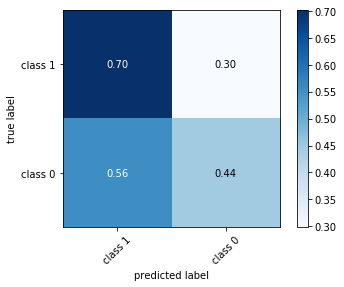

the confusion matrix:  [[859 365]
 [476 380]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 5)
##############################
CPU times: user 6.6 s, sys: 112 ms, total: 6.72 s
Wall time: 6.72 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


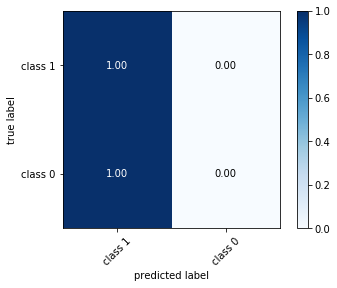

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


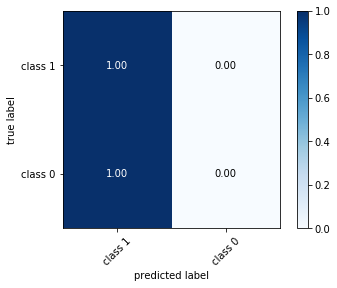

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 2)
##############################
CPU times: user 2min 50s, sys: 301 ms, total: 2min 50s
Wall time: 2min 50s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.800218 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6870351100319882
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       961
           1       0.76      0.59      0.66      1107

    accuracy                           0.68      2068
   macro avg       0.69      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



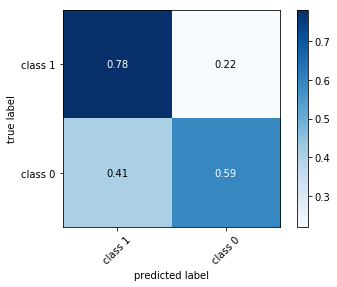

the confusion matrix:  [[751 210]
 [451 656]]
The ROC-AUC score for the test set is:  0.706451194184839
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1224
           1       0.70      0.59      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.73      0.72      2080



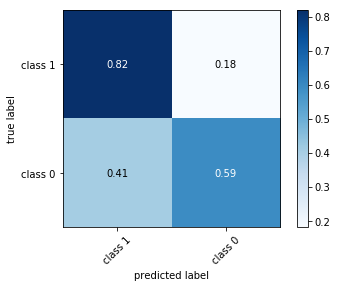

the confusion matrix:  [[1003  221]
 [ 348  508]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 2)
##############################
CPU times: user 3min 39s, sys: 2.97 s, total: 3min 41s
Wall time: 3min 42s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.602415 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5216252266580939
              precision    recall  f1-score   support

           0       0.48      0.69      0.57       961
           1       0.57      0.35      0.43      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.50      2068
weighted avg       0.53      0.51      0.50      2068



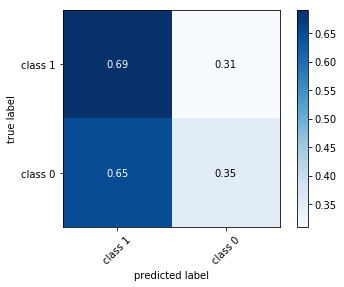

the confusion matrix:  [[664 297]
 [717 390]]
The ROC-AUC score for the test set is:  0.5432433876977582
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1224
           1       0.48      0.38      0.42       856

    accuracy                           0.57      2080
   macro avg       0.55      0.54      0.54      2080
weighted avg       0.56      0.57      0.56      2080



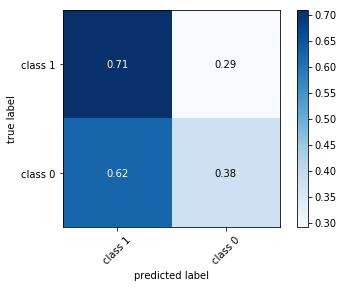

the confusion matrix:  [[868 356]
 [533 323]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 2)
##############################
CPU times: user 10.8 s, sys: 184 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


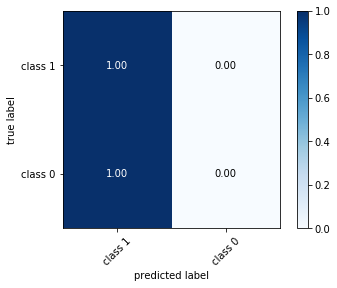

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


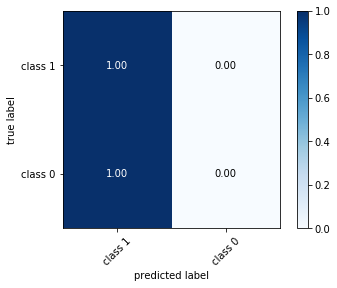

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 3)
##############################
CPU times: user 2min 48s, sys: 341 ms, total: 2min 48s
Wall time: 2min 48s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.800008 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6977953182237338
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



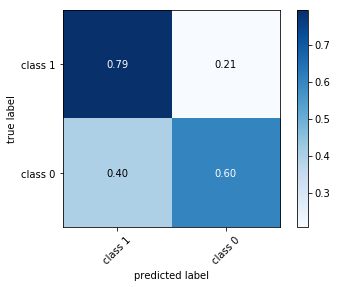

the confusion matrix:  [[763 198]
 [441 666]]
The ROC-AUC score for the test set is:  0.7085547614684503
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1224
           1       0.70      0.60      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.73      0.73      0.72      2080



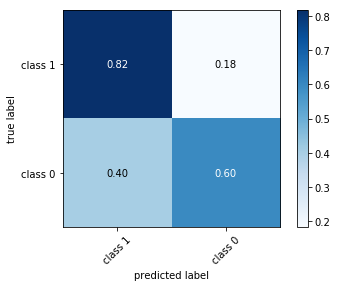

the confusion matrix:  [[1001  223]
 [ 343  513]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 3)
##############################
CPU times: user 3min 44s, sys: 3.32 s, total: 3min 47s
Wall time: 3min 47s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.605392 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5295955075402297
              precision    recall  f1-score   support

           0       0.49      0.72      0.58       961
           1       0.58      0.34      0.43      1107

    accuracy                           0.52      2068
   macro avg       0.53      0.53      0.51      2068
weighted avg       0.54      0.52      0.50      2068



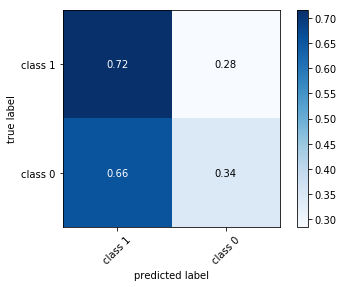

the confusion matrix:  [[688 273]
 [727 380]]
The ROC-AUC score for the test set is:  0.5359018997006902
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1224
           1       0.46      0.40      0.43       856

    accuracy                           0.56      2080
   macro avg       0.54      0.54      0.54      2080
weighted avg       0.55      0.56      0.55      2080



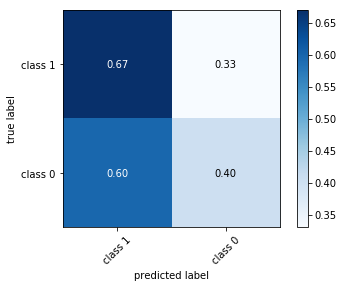

the confusion matrix:  [[820 404]
 [512 344]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 3)
##############################
CPU times: user 10.8 s, sys: 200 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


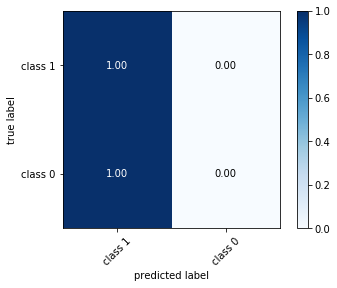

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


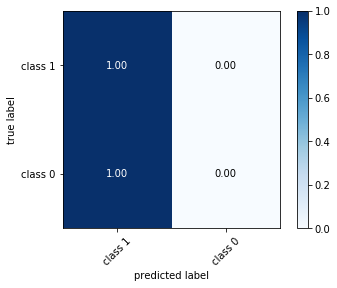

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 5)
##############################
CPU times: user 2min 50s, sys: 341 ms, total: 2min 50s
Wall time: 2min 50s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.799749 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.7032153724242758
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       961
           1       0.77      0.61      0.68      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.70      2068
weighted avg       0.71      0.70      0.70      2068



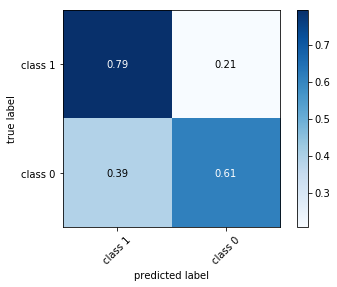

the confusion matrix:  [[763 198]
 [429 678]]
The ROC-AUC score for the test set is:  0.7075621525868915
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1224
           1       0.70      0.60      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.73      0.72      2080



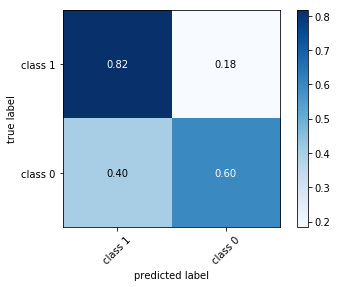

the confusion matrix:  [[1000  224]
 [ 344  512]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 5)
##############################
CPU times: user 3min 47s, sys: 3.11 s, total: 3min 50s
Wall time: 3min 50s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.598356 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5241754533396877
              precision    recall  f1-score   support

           0       0.48      0.72      0.58       961
           1       0.57      0.33      0.42      1107

    accuracy                           0.51      2068
   macro avg       0.53      0.52      0.50      2068
weighted avg       0.53      0.51      0.49      2068



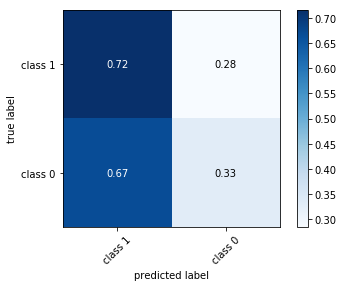

the confusion matrix:  [[688 273]
 [739 368]]
The ROC-AUC score for the test set is:  0.5354323193451835
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1224
           1       0.46      0.40      0.43       856

    accuracy                           0.56      2080
   macro avg       0.54      0.54      0.53      2080
weighted avg       0.55      0.56      0.55      2080



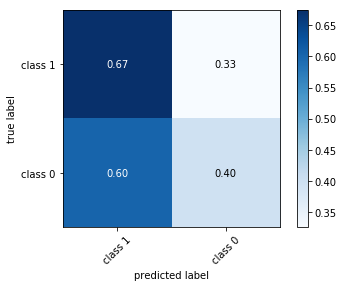

the confusion matrix:  [[826 398]
 [517 339]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 5)
##############################
CPU times: user 10.8 s, sys: 203 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibLinear]

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.502933 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


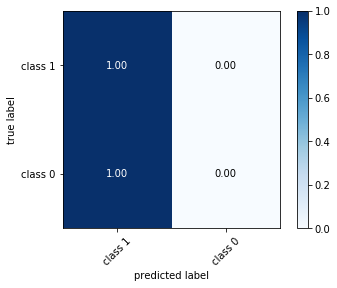

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


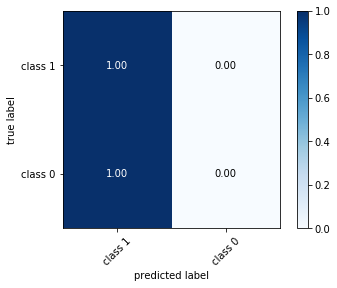

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 2)
##############################
CPU times: user 1min 18s, sys: 159 ms, total: 1min 18s
Wall time: 1min 18s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.810426 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6991103816691999
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       961
           1       0.78      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



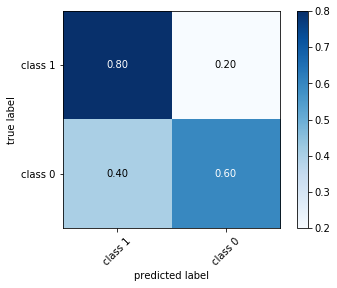

the confusion matrix:  [[769 192]
 [445 662]]
The ROC-AUC score for the test set is:  0.7130520432472054
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



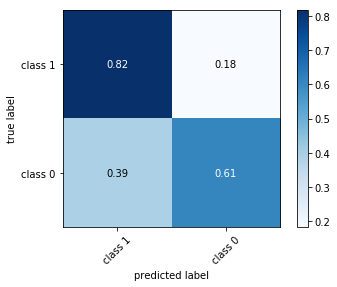

the confusion matrix:  [[1002  222]
 [ 336  520]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 2)
##############################
CPU times: user 1min 38s, sys: 1.32 s, total: 1min 39s
Wall time: 1min 39s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.621363 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5570788295465333
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       961
           1       0.62      0.40      0.48      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.54      2068
weighted avg       0.57      0.55      0.54      2068



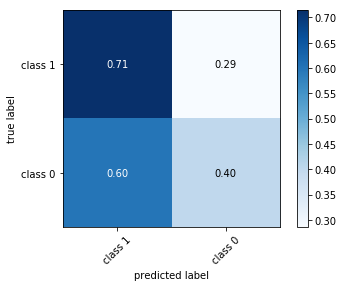

the confusion matrix:  [[687 274]
 [665 442]]
The ROC-AUC score for the test set is:  0.5626336204263637
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1224
           1       0.50      0.41      0.45       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



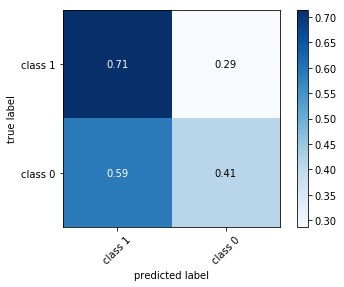

the confusion matrix:  [[874 350]
 [504 352]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 2)
##############################
CPU times: user 4.39 s, sys: 75.9 ms, total: 4.46 s
Wall time: 4.46 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


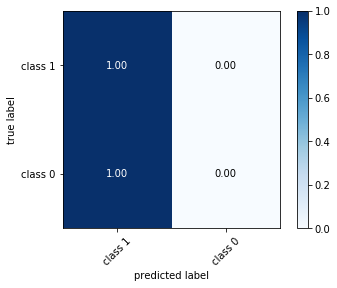

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


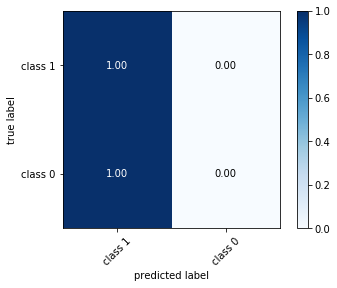

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 3)
##############################
CPU times: user 1min 19s, sys: 162 ms, total: 1min 19s
Wall time: 1min 19s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.810581 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.7016831684099013
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       961
           1       0.78      0.61      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



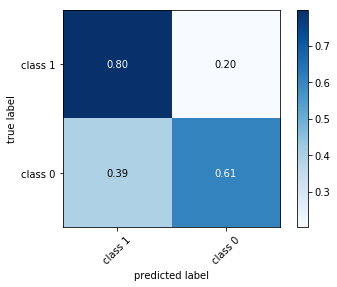

the confusion matrix:  [[767 194]
 [437 670]]
The ROC-AUC score for the test set is:  0.7135178058762446
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.70      0.61      0.65       856

    accuracy                           0.73      2080
   macro avg       0.73      0.71      0.72      2080
weighted avg       0.73      0.73      0.73      2080



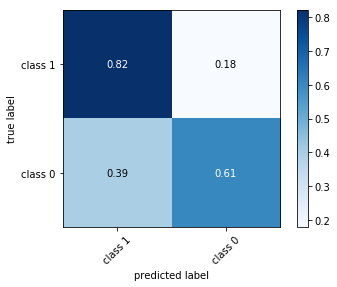

the confusion matrix:  [[1006  218]
 [ 338  518]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 3)
##############################
CPU times: user 1min 43s, sys: 1.51 s, total: 1min 44s
Wall time: 1min 44s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.622340 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5720126486731395
              precision    recall  f1-score   support

           0       0.52      0.72      0.60       961
           1       0.64      0.42      0.51      1107

    accuracy                           0.56      2068
   macro avg       0.58      0.57      0.56      2068
weighted avg       0.58      0.56      0.55      2068



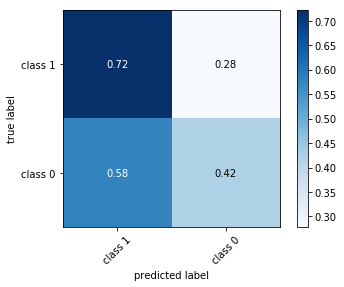

the confusion matrix:  [[694 267]
 [640 467]]
The ROC-AUC score for the test set is:  0.5793399914482928
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1224
           1       0.52      0.45      0.48       856

    accuracy                           0.60      2080
   macro avg       0.58      0.58      0.58      2080
weighted avg       0.60      0.60      0.60      2080



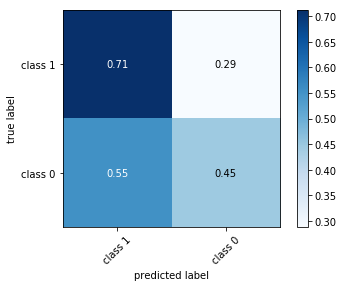

the confusion matrix:  [[872 352]
 [474 382]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 3)
##############################
CPU times: user 4.39 s, sys: 88.4 ms, total: 4.48 s
Wall time: 4.48 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


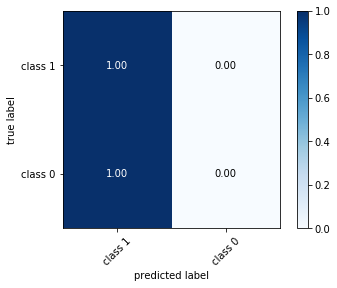

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


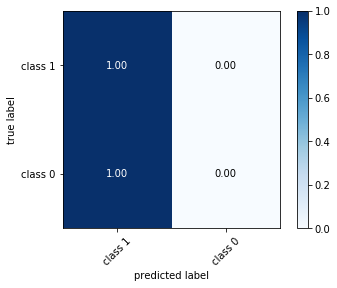

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 5)
##############################
CPU times: user 1min 18s, sys: 171 ms, total: 1min 18s
Wall time: 1min 18s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.810394 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.7021348395932797
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       961
           1       0.78      0.61      0.68      1107

    accuracy                           0.70      2068
   macro avg       0.71      0.70      0.69      2068
weighted avg       0.71      0.70      0.69      2068



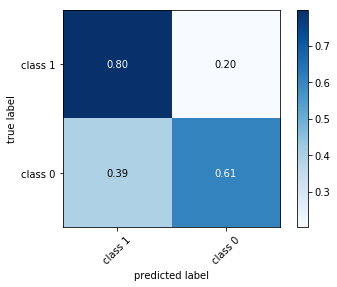

the confusion matrix:  [[767 194]
 [436 671]]
The ROC-AUC score for the test set is:  0.717430975505467
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1224
           1       0.71      0.61      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



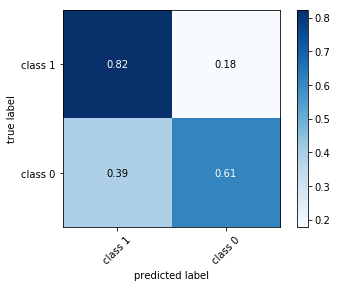

the confusion matrix:  [[1007  217]
 [ 332  524]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 5)
##############################
CPU times: user 1min 42s, sys: 1.32 s, total: 1min 43s
Wall time: 1min 43s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.622123 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5486455974514653
              precision    recall  f1-score   support

           0       0.50      0.70      0.59       961
           1       0.60      0.39      0.48      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.55      0.53      2068
weighted avg       0.56      0.54      0.53      2068



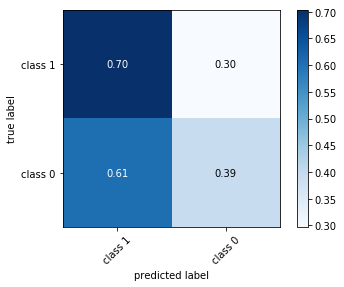

the confusion matrix:  [[676 285]
 [671 436]]
The ROC-AUC score for the test set is:  0.5583844908679984
              precision    recall  f1-score   support

           0       0.63      0.68      0.66      1224
           1       0.49      0.43      0.46       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.58      0.58      2080



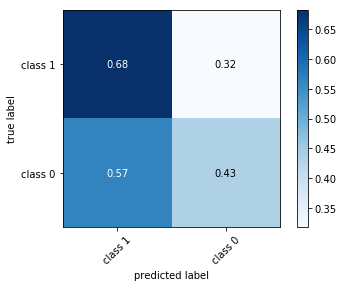

the confusion matrix:  [[835 389]
 [484 372]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 5)
##############################
CPU times: user 4.34 s, sys: 96.1 ms, total: 4.43 s
Wall time: 4.43 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


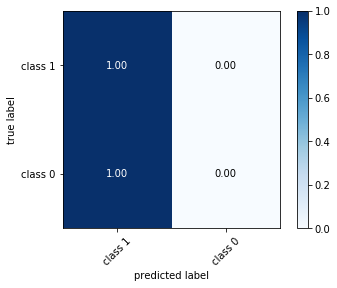

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


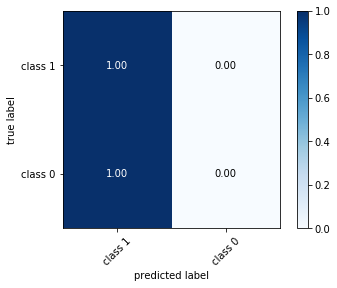

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 2)
##############################
CPU times: user 1min 57s, sys: 227 ms, total: 1min 57s
Wall time: 1min 57s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.807061 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6919123128102596
              precision    recall  f1-score   support

           0       0.62      0.81      0.70       961
           1       0.78      0.58      0.66      1107

    accuracy                           0.68      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



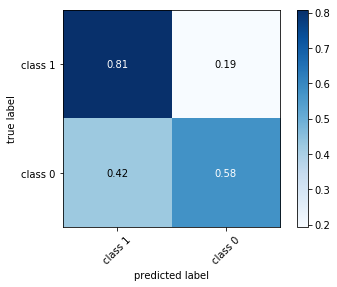

the confusion matrix:  [[776 185]
 [469 638]]
The ROC-AUC score for the test set is:  0.720298088082585
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1224
           1       0.70      0.63      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



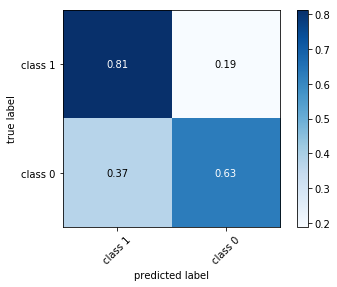

the confusion matrix:  [[994 230]
 [318 538]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 2)
##############################
CPU times: user 2min 30s, sys: 2.07 s, total: 2min 32s
Wall time: 2min 32s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.610425 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.554574662985617
              precision    recall  f1-score   support

           0       0.51      0.72      0.59       961
           1       0.62      0.39      0.48      1107

    accuracy                           0.54      2068
   macro avg       0.56      0.55      0.54      2068
weighted avg       0.56      0.54      0.53      2068



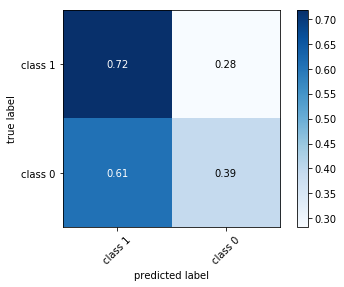

the confusion matrix:  [[690 271]
 [674 433]]
The ROC-AUC score for the test set is:  0.5459348848573697
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      1224
           1       0.48      0.39      0.43       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.54      2080
weighted avg       0.56      0.57      0.56      2080



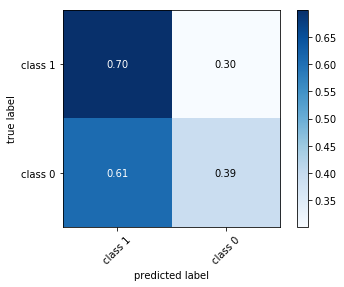

the confusion matrix:  [[856 368]
 [520 336]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 2)
##############################
CPU times: user 6.49 s, sys: 144 ms, total: 6.63 s
Wall time: 6.64 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.4s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


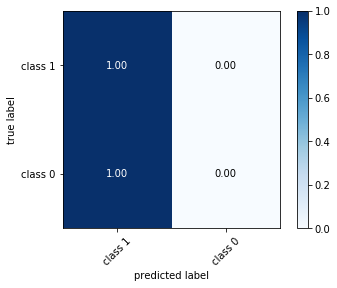

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


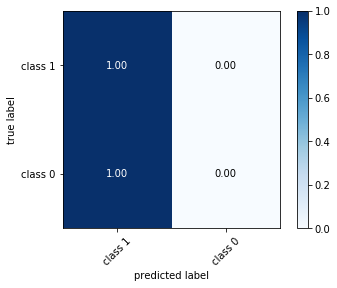

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 3)
##############################
CPU times: user 1min 58s, sys: 266 ms, total: 1min 58s
Wall time: 1min 59s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.806835 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.692541174457877
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       961
           1       0.77      0.58      0.66      1107

    accuracy                           0.68      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



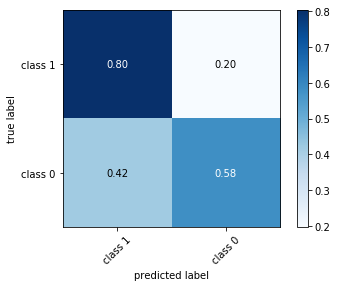

the confusion matrix:  [[772 189]
 [463 644]]
The ROC-AUC score for the test set is:  0.7184235843870258
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1224
           1       0.71      0.61      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



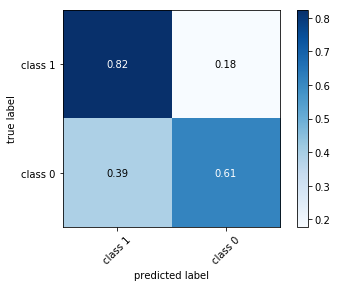

the confusion matrix:  [[1008  216]
 [ 331  525]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 3)
##############################
CPU times: user 2min 27s, sys: 2 s, total: 2min 29s
Wall time: 2min 29s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.613119 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5358728439868513
              precision    recall  f1-score   support

           0       0.49      0.69      0.57       961
           1       0.59      0.38      0.46      1107

    accuracy                           0.53      2068
   macro avg       0.54      0.54      0.52      2068
weighted avg       0.54      0.53      0.52      2068



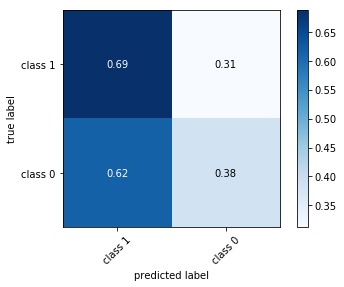

the confusion matrix:  [[661 300]
 [682 425]]
The ROC-AUC score for the test set is:  0.5483515057113189
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1224
           1       0.47      0.44      0.46       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.56      0.57      0.56      2080



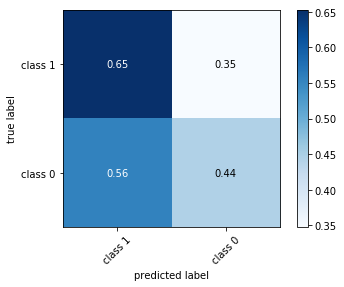

the confusion matrix:  [[799 425]
 [476 380]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 3)
##############################
CPU times: user 6.58 s, sys: 124 ms, total: 6.71 s
Wall time: 6.71 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


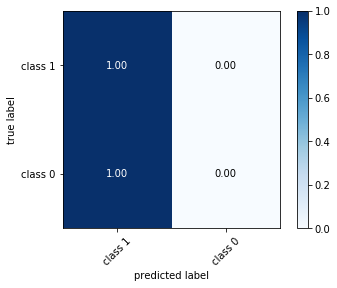

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


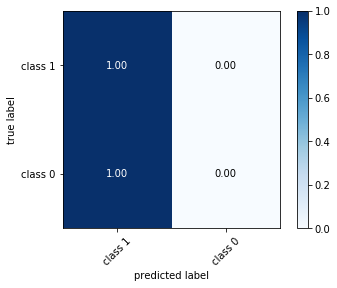

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 5)
##############################
CPU times: user 1min 56s, sys: 250 ms, total: 1min 56s
Wall time: 1min 56s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.807253 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6911175407279567
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       961
           1       0.77      0.58      0.66      1107

    accuracy                           0.68      2068
   macro avg       0.70      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



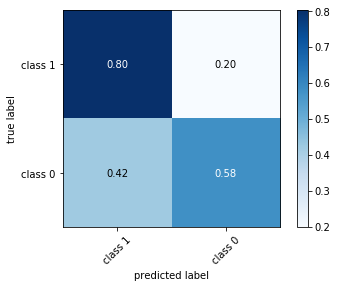

the confusion matrix:  [[771 190]
 [465 642]]
The ROC-AUC score for the test set is:  0.7166139820414146
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1224
           1       0.71      0.61      0.66       856

    accuracy                           0.74      2080
   macro avg       0.73      0.72      0.72      2080
weighted avg       0.73      0.74      0.73      2080



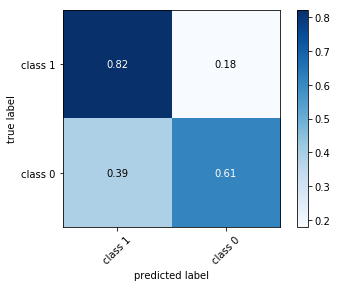

the confusion matrix:  [[1005  219]
 [ 332  524]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 5)
##############################
CPU times: user 2min 36s, sys: 2.31 s, total: 2min 38s
Wall time: 2min 38s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.609237 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5502464216456247
              precision    recall  f1-score   support

           0       0.50      0.70      0.59       961
           1       0.61      0.40      0.48      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.55      0.53      2068
weighted avg       0.56      0.54      0.53      2068



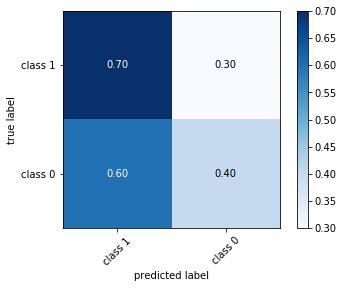

the confusion matrix:  [[673 288]
 [664 443]]
The ROC-AUC score for the test set is:  0.5676653839105735
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1224
           1       0.50      0.44      0.47       856

    accuracy                           0.59      2080
   macro avg       0.57      0.57      0.57      2080
weighted avg       0.58      0.59      0.59      2080



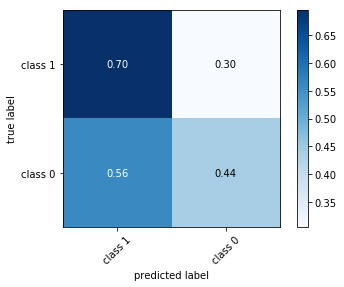

the confusion matrix:  [[852 372]
 [480 376]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 5)
##############################
CPU times: user 6.5 s, sys: 140 ms, total: 6.64 s
Wall time: 6.64 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


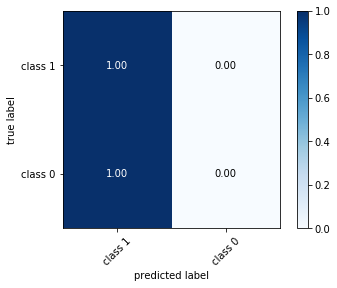

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


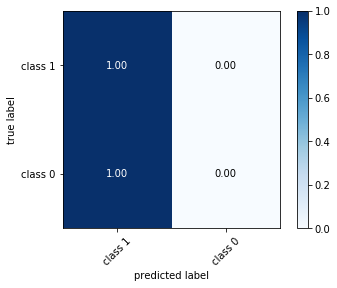

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 2)
##############################
CPU times: user 3min 14s, sys: 445 ms, total: 3min 15s
Wall time: 3min 15s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.800708 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6963030643140286
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.60      0.67      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



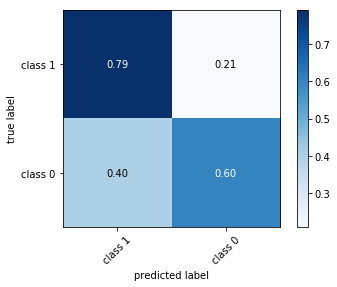

the confusion matrix:  [[761 200]
 [442 665]]
The ROC-AUC score for the test set is:  0.6991555189053814
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1224
           1       0.68      0.59      0.63       856

    accuracy                           0.72      2080
   macro avg       0.71      0.70      0.70      2080
weighted avg       0.72      0.72      0.71      2080



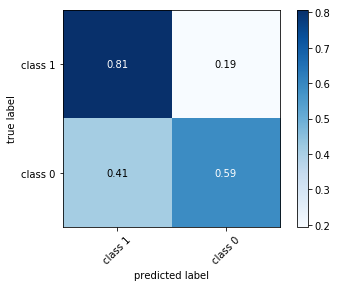

the confusion matrix:  [[988 236]
 [350 506]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 2)
##############################
CPU times: user 3min 59s, sys: 3.3 s, total: 4min 2s
Wall time: 4min 2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.599991 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5136323857168505
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       961
           1       0.56      0.33      0.42      1107

    accuracy                           0.50      2068
   macro avg       0.52      0.51      0.49      2068
weighted avg       0.52      0.50      0.49      2068



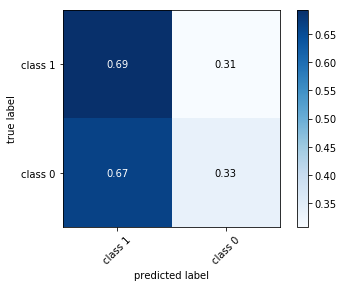

the confusion matrix:  [[666 295]
 [737 370]]
The ROC-AUC score for the test set is:  0.5315725978865066
              precision    recall  f1-score   support

           0       0.61      0.68      0.65      1224
           1       0.46      0.38      0.41       856

    accuracy                           0.56      2080
   macro avg       0.53      0.53      0.53      2080
weighted avg       0.55      0.56      0.55      2080



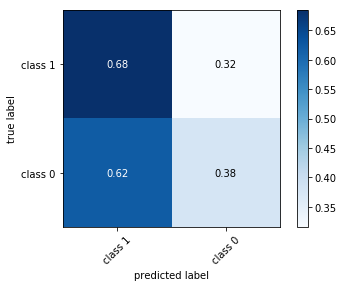

the confusion matrix:  [[838 386]
 [532 324]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 2)
##############################
CPU times: user 10.8 s, sys: 184 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


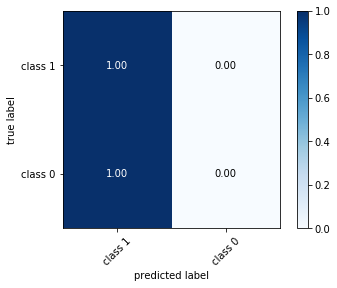

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


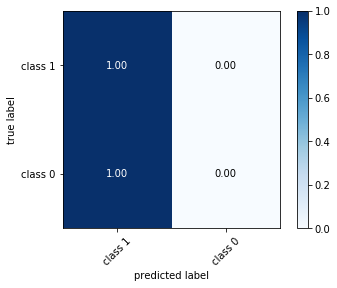

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 3)
##############################
CPU times: user 3min 13s, sys: 342 ms, total: 3min 13s
Wall time: 3min 13s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.801046 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6907857198585861
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       961
           1       0.76      0.60      0.67      1107

    accuracy                           0.68      2068
   macro avg       0.69      0.69      0.68      2068
weighted avg       0.70      0.68      0.68      2068



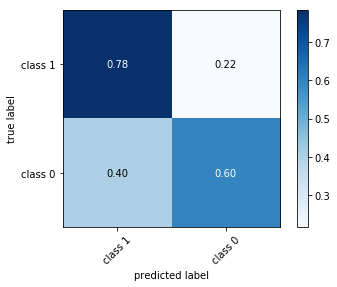

the confusion matrix:  [[753 208]
 [445 662]]
The ROC-AUC score for the test set is:  0.7064550119113066
              precision    recall  f1-score   support

           0       0.74      0.81      0.78      1224
           1       0.69      0.60      0.64       856

    accuracy                           0.73      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.72      0.72      2080



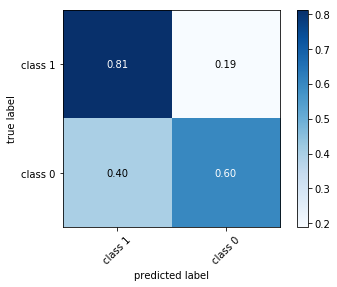

the confusion matrix:  [[993 231]
 [341 515]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 3)
##############################
CPU times: user 4min 8s, sys: 3.63 s, total: 4min 12s
Wall time: 4min 12s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.602428 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5070058383552964
              precision    recall  f1-score   support

           0       0.47      0.68      0.56       961
           1       0.55      0.33      0.41      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



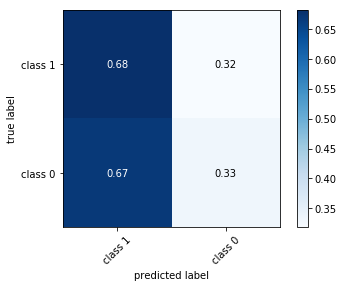

the confusion matrix:  [[655 306]
 [739 368]]
The ROC-AUC score for the test set is:  0.5469427646447987
              precision    recall  f1-score   support

           0       0.62      0.67      0.65      1224
           1       0.47      0.43      0.45       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.56      0.57      0.56      2080



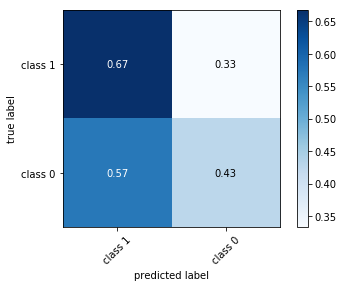

the confusion matrix:  [[817 407]
 [491 365]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 3)
##############################
CPU times: user 10.9 s, sys: 144 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


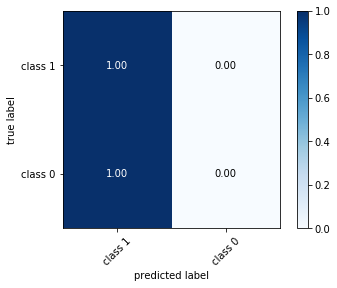

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


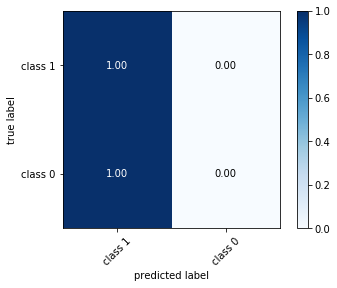

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 5)
##############################
CPU times: user 3min 15s, sys: 374 ms, total: 3min 15s
Wall time: 3min 16s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.800794 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.6975894576843791
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       961
           1       0.77      0.60      0.68      1107

    accuracy                           0.69      2068
   macro avg       0.70      0.70      0.69      2068
weighted avg       0.71      0.69      0.69      2068



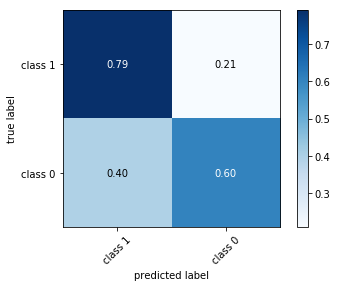

the confusion matrix:  [[760 201]
 [438 669]]
The ROC-AUC score for the test set is:  0.6986859385498748
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1224
           1       0.69      0.59      0.63       856

    accuracy                           0.72      2080
   macro avg       0.71      0.70      0.70      2080
weighted avg       0.72      0.72      0.71      2080



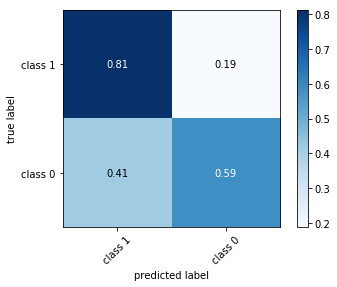

the confusion matrix:  [[994 230]
 [355 501]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 5)
##############################
CPU times: user 4min 8s, sys: 3.11 s, total: 4min 11s
Wall time: 4min 11s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.600280 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.4998190495259097
              precision    recall  f1-score   support

           0       0.46      0.68      0.55       961
           1       0.54      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.50      0.50      0.48      2068
weighted avg       0.50      0.49      0.47      2068



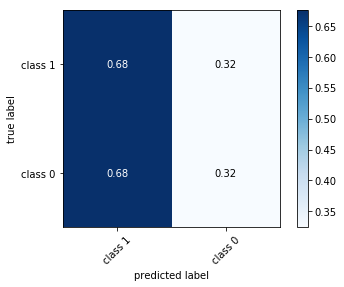

the confusion matrix:  [[649 312]
 [748 359]]
The ROC-AUC score for the test set is:  0.5338517805876245
              precision    recall  f1-score   support

           0       0.61      0.68      0.65      1224
           1       0.46      0.39      0.42       856

    accuracy                           0.56      2080
   macro avg       0.54      0.53      0.53      2080
weighted avg       0.55      0.56      0.55      2080



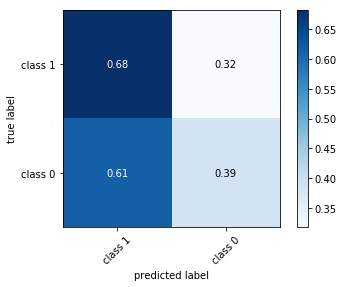

the confusion matrix:  [[835 389]
 [526 330]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 5)
##############################
CPU times: user 10.9 s, sys: 195 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best: 0.503729 using {'clf__method': 'sigmoid'}
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       961
           1       0.00      0.00      0.00      1107

    accuracy                           0.46      2068
   macro avg       0.23      0.50      0.32      2068
weighted avg       0.22      0.46      0.29      2068



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


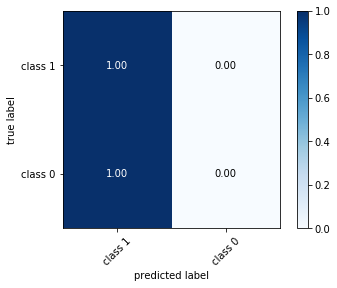

the confusion matrix:  [[ 961    0]
 [1107    0]]
The ROC-AUC score for the test set is:  0.5
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1224
           1       0.00      0.00      0.00       856

    accuracy                           0.59      2080
   macro avg       0.29      0.50      0.37      2080
weighted avg       0.35      0.59      0.44      2080



/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


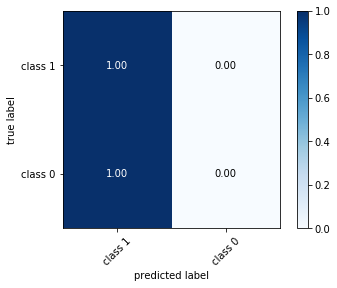

the confusion matrix:  [[1224    0]
 [ 856    0]]
---------------------------------------------------------------
##################################################
Executing  knn  pipeline...
##################################################
------------------------------
Training set has  23241  positive instances and  28336  negative instances.
Test set 1 has  1107  positive instances and  961  negative instances.
Test set 2 has  856  positive instances and  1224  negative instances.
------------------------------


Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 2)
##############################
CPU times: user 56 s, sys: 107 ms, total: 56.1 s
Wall time: 56.1 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 47.8min finished


Best: 0.797097 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7002205245777743
              precision    recall  f1-score   support

           0       0.61      0.89      0.72       961
           1       0.84      0.51      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.73      0.69      0.68      2068



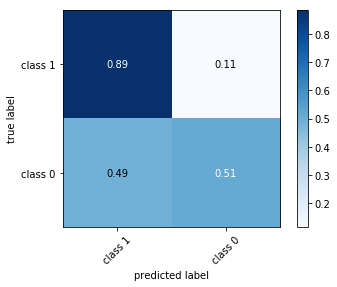

the confusion matrix:  [[851 110]
 [537 570]]
The ROC-AUC score for the test set is:  0.6947422271089121
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1224
           1       0.74      0.51      0.61       856

    accuracy                           0.73      2080
   macro avg       0.73      0.69      0.70      2080
weighted avg       0.73      0.73      0.72      2080



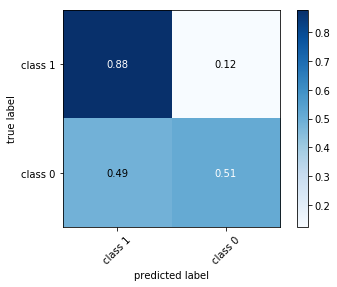

the confusion matrix:  [[1073  151]
 [ 417  439]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 2)
##############################
CPU times: user 1min 23s, sys: 1.4 s, total: 1min 25s
Wall time: 1min 25s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 50.0min finished


Best: 0.594701 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5595759460889788
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       961
           1       0.60      0.52      0.56      1107

    accuracy                           0.56      2068
   macro avg       0.56      0.56      0.56      2068
weighted avg       0.56      0.56      0.56      2068



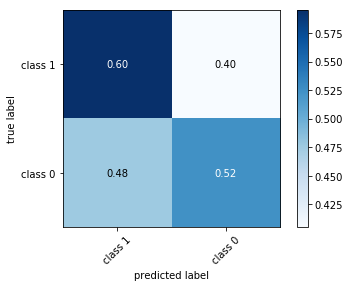

the confusion matrix:  [[572 389]
 [527 580]]
The ROC-AUC score for the test set is:  0.5573689756276343
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      1224
           1       0.47      0.51      0.49       856

    accuracy                           0.57      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.57      0.57      2080



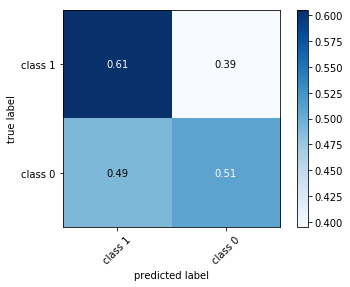

the confusion matrix:  [[741 483]
 [420 436]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 2)
##############################
CPU times: user 4.36 s, sys: 80 ms, total: 4.44 s
Wall time: 4.44 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 47.7min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



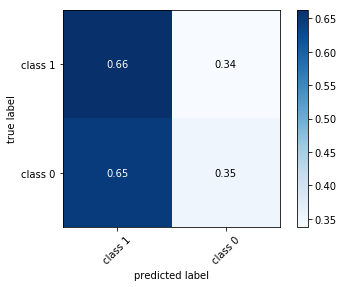

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



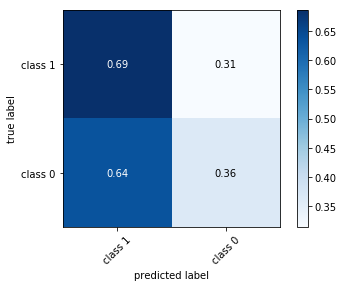

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 3)
##############################
CPU times: user 56.4 s, sys: 168 ms, total: 56.6 s
Wall time: 56.6 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 48.1min finished


Best: 0.797374 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6928964953888178
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.51      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.69      0.67      2068
weighted avg       0.72      0.68      0.67      2068



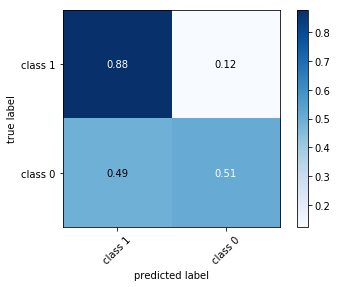

the confusion matrix:  [[843 118]
 [544 563]]
The ROC-AUC score for the test set is:  0.6902983935007024
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      1224
           1       0.75      0.49      0.60       856

    accuracy                           0.73      2080
   macro avg       0.73      0.69      0.69      2080
weighted avg       0.73      0.72      0.71      2080



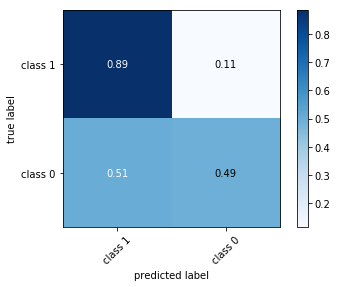

the confusion matrix:  [[1085  139]
 [ 433  423]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 3)
##############################
CPU times: user 1min 22s, sys: 1.52 s, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 50.3min finished


Best: 0.597675 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5494507095608591
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       961
           1       0.59      0.49      0.53      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.55      0.54      2068
weighted avg       0.55      0.54      0.54      2068



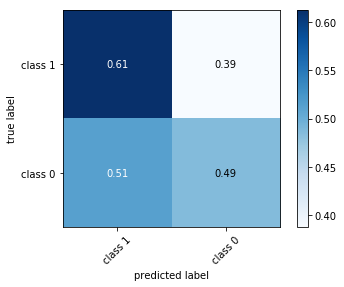

the confusion matrix:  [[589 372]
 [569 538]]
The ROC-AUC score for the test set is:  0.5594725429112455
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1224
           1       0.48      0.52      0.49       856

    accuracy                           0.57      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.57      0.57      2080



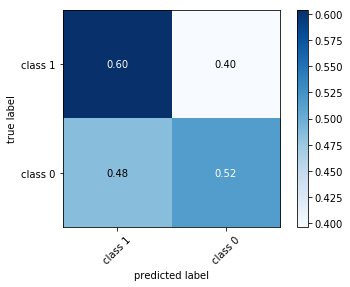

the confusion matrix:  [[739 485]
 [415 441]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 3)
##############################
CPU times: user 4.32 s, sys: 72.4 ms, total: 4.39 s
Wall time: 4.39 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.7min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



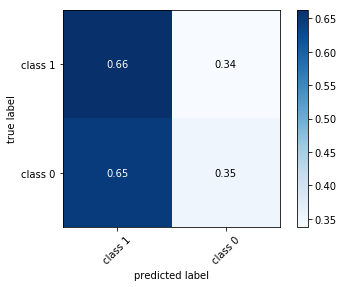

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



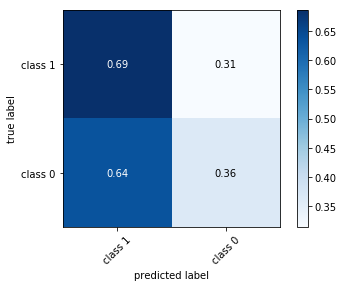

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 20, 5)
##############################
CPU times: user 56.9 s, sys: 108 ms, total: 57 s
Wall time: 57 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 50.0min finished


Best: 0.796454 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6950462810212563
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.51      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.70      0.68      2068
weighted avg       0.73      0.68      0.67      2068



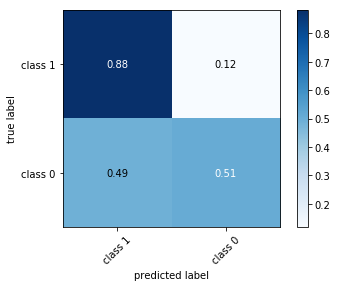

the confusion matrix:  [[848 113]
 [545 562]]
The ROC-AUC score for the test set is:  0.6948567589029381
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1224
           1       0.75      0.51      0.61       856

    accuracy                           0.73      2080
   macro avg       0.73      0.69      0.70      2080
weighted avg       0.73      0.73      0.72      2080



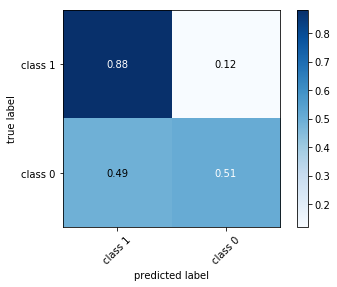

the confusion matrix:  [[1079  145]
 [ 421  435]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 20, 5)
##############################
CPU times: user 1min 24s, sys: 1.32 s, total: 1min 25s
Wall time: 1min 25s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 50.2min finished


Best: 0.597101 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5665916544701347
              precision    recall  f1-score   support

           0       0.52      0.64      0.58       961
           1       0.61      0.49      0.55      1107

    accuracy                           0.56      2068
   macro avg       0.57      0.57      0.56      2068
weighted avg       0.57      0.56      0.56      2068



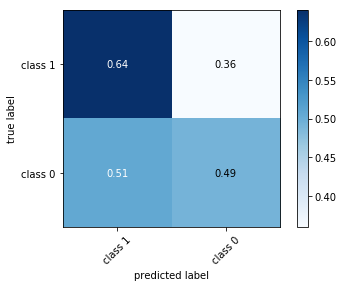

the confusion matrix:  [[615 346]
 [561 546]]
The ROC-AUC score for the test set is:  0.5631910084906236
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1224
           1       0.49      0.48      0.48       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.58      0.58      0.58      2080



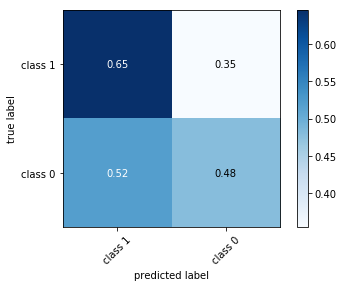

the confusion matrix:  [[791 433]
 [445 411]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 20, 5)
##############################
CPU times: user 4.37 s, sys: 100 ms, total: 4.47 s
Wall time: 4.47 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 47.3min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



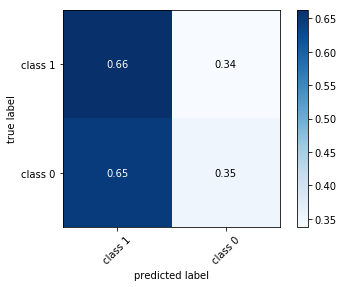

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



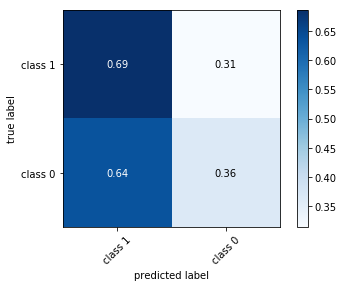

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 2)
##############################
CPU times: user 1min 24s, sys: 187 ms, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.5min finished


Best: 0.794862 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7026161208542365
              precision    recall  f1-score   support

           0       0.61      0.89      0.73       961
           1       0.84      0.52      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.74      0.69      0.68      2068



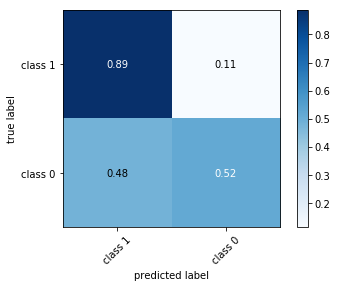

the confusion matrix:  [[853 108]
 [534 573]]
The ROC-AUC score for the test set is:  0.7051417140064749
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1224
           1       0.75      0.54      0.63       856

    accuracy                           0.73      2080
   macro avg       0.74      0.71      0.71      2080
weighted avg       0.74      0.73      0.72      2080



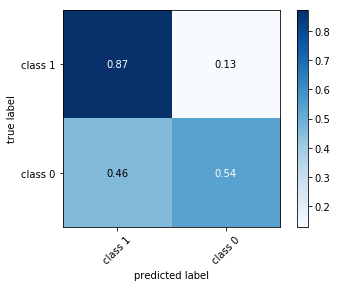

the confusion matrix:  [[1067  157]
 [ 395  461]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 2)
##############################
CPU times: user 2min 3s, sys: 1.91 s, total: 2min 5s
Wall time: 2min 5s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 47.6min finished


Best: 0.583098 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5370436170542767
              precision    recall  f1-score   support

           0       0.50      0.58      0.53       961
           1       0.57      0.50      0.53      1107

    accuracy                           0.53      2068
   macro avg       0.54      0.54      0.53      2068
weighted avg       0.54      0.53      0.53      2068



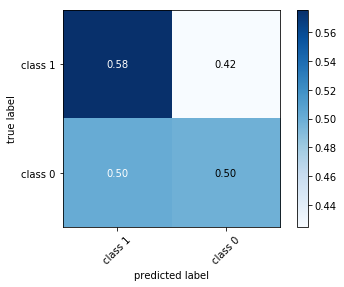

the confusion matrix:  [[553 408]
 [555 552]]
The ROC-AUC score for the test set is:  0.5736553967381345
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1224
           1       0.49      0.52      0.51       856

    accuracy                           0.58      2080
   macro avg       0.57      0.57      0.57      2080
weighted avg       0.59      0.58      0.58      2080



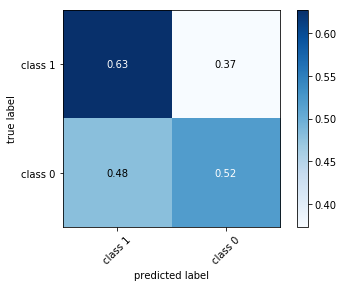

the confusion matrix:  [[768 456]
 [411 445]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 2)
##############################
CPU times: user 6.47 s, sys: 116 ms, total: 6.58 s
Wall time: 6.59 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.1min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



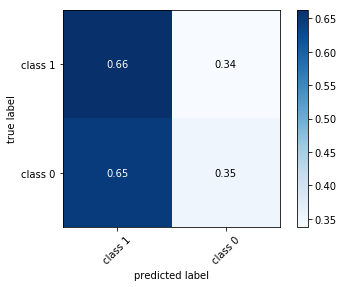

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



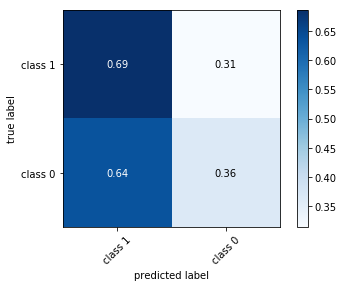

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 3)
##############################
CPU times: user 1min 25s, sys: 152 ms, total: 1min 25s
Wall time: 1min 25s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 51.7min finished


Best: 0.793605 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7060522998570258
              precision    recall  f1-score   support

           0       0.62      0.89      0.73       961
           1       0.85      0.52      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.71      0.69      2068
weighted avg       0.74      0.69      0.68      2068



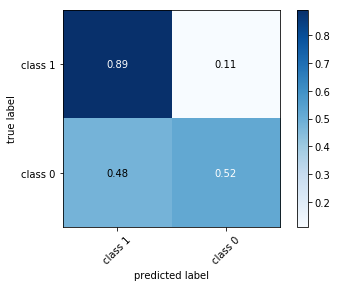

the confusion matrix:  [[857 104]
 [531 576]]
The ROC-AUC score for the test set is:  0.7140217457699591
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1224
           1       0.75      0.56      0.64       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.72      2080
weighted avg       0.74      0.74      0.73      2080



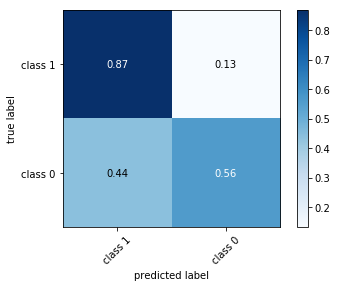

the confusion matrix:  [[1063  161]
 [ 377  479]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 3)
##############################
CPU times: user 2min 5s, sys: 1.9 s, total: 2min 7s
Wall time: 2min 7s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.2min finished


Best: 0.582071 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5443624762296877
              precision    recall  f1-score   support

           0       0.50      0.63      0.56       961
           1       0.59      0.46      0.51      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.54      0.54      2068
weighted avg       0.55      0.54      0.54      2068



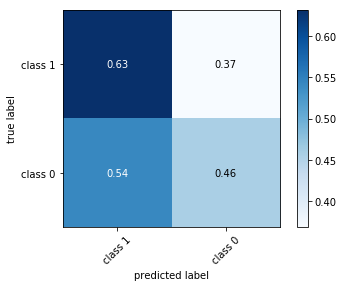

the confusion matrix:  [[607 354]
 [601 506]]
The ROC-AUC score for the test set is:  0.5578309205302059
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1224
           1       0.48      0.50      0.49       856

    accuracy                           0.57      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.57      0.57      2080



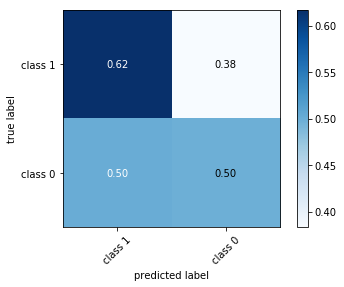

the confusion matrix:  [[755 469]
 [429 427]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 3)
##############################
CPU times: user 6.54 s, sys: 104 ms, total: 6.64 s
Wall time: 6.65 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 52.6min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



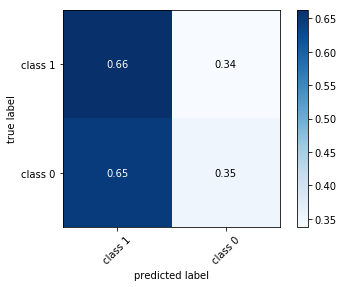

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



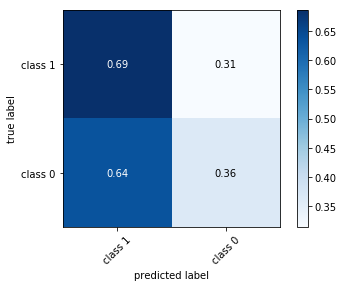

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 30, 5)
##############################
CPU times: user 1min 24s, sys: 160 ms, total: 1min 24s
Wall time: 1min 24s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.3min finished


Best: 0.794081 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7028619314982606
              precision    recall  f1-score   support

           0       0.62      0.88      0.73       961
           1       0.84      0.52      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.74      0.69      0.68      2068



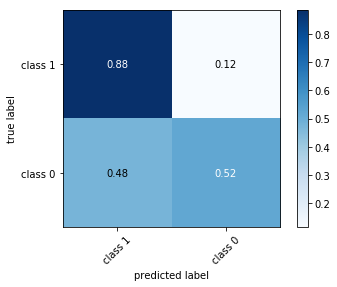

the confusion matrix:  [[850 111]
 [530 577]]
The ROC-AUC score for the test set is:  0.7139568444200111
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1224
           1       0.76      0.55      0.64       856

    accuracy                           0.74      2080
   macro avg       0.75      0.71      0.72      2080
weighted avg       0.75      0.74      0.73      2080



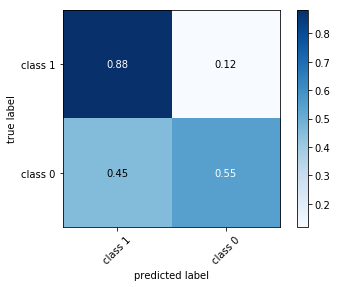

the confusion matrix:  [[1080  144]
 [ 389  467]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 30, 5)
##############################
CPU times: user 2min 5s, sys: 1.86 s, total: 2min 7s
Wall time: 2min 7s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 52.3min finished


Best: 0.587610 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5366553960371376
              precision    recall  f1-score   support

           0       0.50      0.62      0.55       961
           1       0.58      0.45      0.51      1107

    accuracy                           0.53      2068
   macro avg       0.54      0.54      0.53      2068
weighted avg       0.54      0.53      0.53      2068



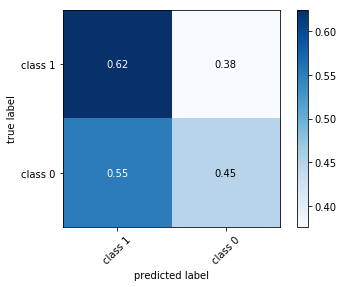

the confusion matrix:  [[600 361]
 [610 497]]
The ROC-AUC score for the test set is:  0.5621487691649869
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1224
           1       0.48      0.50      0.49       856

    accuracy                           0.57      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.58      0.57      0.57      2080



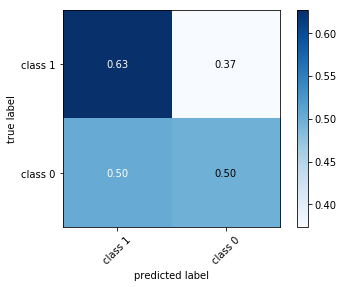

the confusion matrix:  [[767 457]
 [430 426]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 30, 5)
##############################
CPU times: user 6.5 s, sys: 87.9 ms, total: 6.59 s
Wall time: 6.6 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.1min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



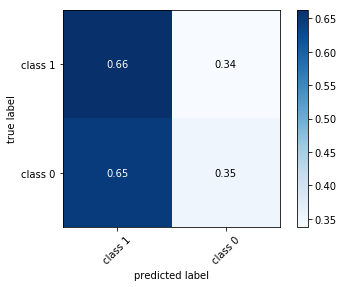

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



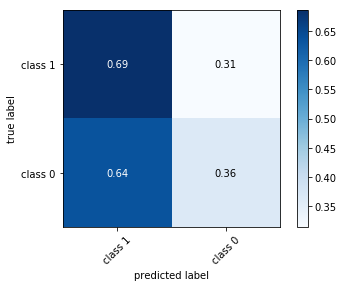

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 2)
##############################
CPU times: user 2min 21s, sys: 268 ms, total: 2min 21s
Wall time: 2min 21s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 51.1min finished


Best: 0.793409 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7013522875429934
              precision    recall  f1-score   support

           0       0.62      0.86      0.72       961
           1       0.82      0.54      0.65      1107

    accuracy                           0.69      2068
   macro avg       0.72      0.70      0.69      2068
weighted avg       0.73      0.69      0.68      2068



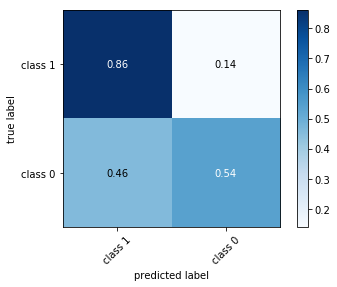

the confusion matrix:  [[828 133]
 [508 599]]
The ROC-AUC score for the test set is:  0.7167705088265837
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1224
           1       0.74      0.57      0.65       856

    accuracy                           0.74      2080
   macro avg       0.74      0.72      0.72      2080
weighted avg       0.74      0.74      0.74      2080



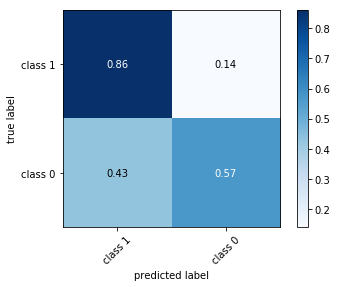

the confusion matrix:  [[1054  170]
 [ 366  490]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 2)
##############################
CPU times: user 3min 22s, sys: 3.21 s, total: 3min 25s
Wall time: 3min 25s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.0min finished


Best: 0.573247 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5431385930231137
              precision    recall  f1-score   support

           0       0.50      0.60      0.55       961
           1       0.58      0.49      0.53      1107

    accuracy                           0.54      2068
   macro avg       0.54      0.54      0.54      2068
weighted avg       0.55      0.54      0.54      2068



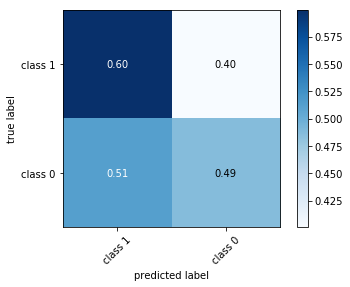

the confusion matrix:  [[576 385]
 [568 539]]
The ROC-AUC score for the test set is:  0.5545094985034512
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1224
           1       0.47      0.51      0.49       856

    accuracy                           0.56      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.57      0.56      0.56      2080



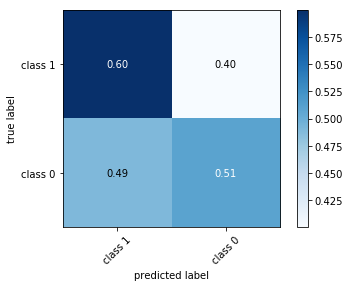

the confusion matrix:  [[734 490]
 [420 436]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 2)
##############################
CPU times: user 10.9 s, sys: 180 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 46.1min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



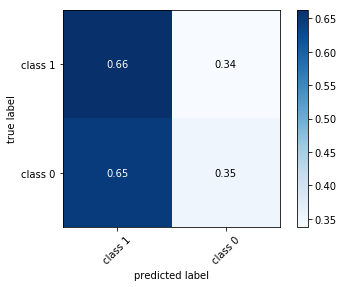

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



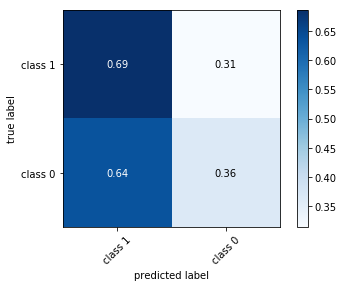

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 3)
##############################
CPU times: user 2min 20s, sys: 288 ms, total: 2min 20s
Wall time: 2min 20s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 48.9min finished


Best: 0.792686 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6908665600703874
              precision    recall  f1-score   support

           0       0.61      0.85      0.71       961
           1       0.81      0.53      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.71      0.69      0.68      2068
weighted avg       0.72      0.68      0.67      2068



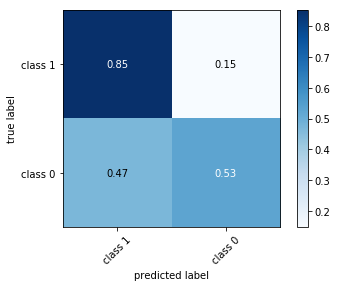

the confusion matrix:  [[820 141]
 [522 585]]
The ROC-AUC score for the test set is:  0.7206264125587931
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1224
           1       0.74      0.58      0.65       856

    accuracy                           0.75      2080
   macro avg       0.74      0.72      0.73      2080
weighted avg       0.74      0.75      0.74      2080



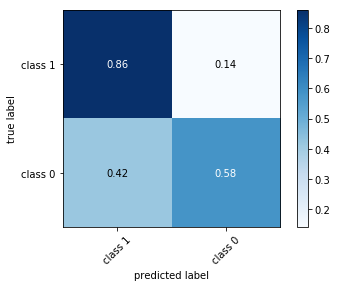

the confusion matrix:  [[1052  172]
 [ 358  498]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 3)
##############################
CPU times: user 3min 24s, sys: 3.2 s, total: 3min 28s
Wall time: 3min 28s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 46.5min finished


Best: 0.579828 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5553910551245644
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       961
           1       0.60      0.50      0.54      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.55      2068
weighted avg       0.56      0.55      0.55      2068



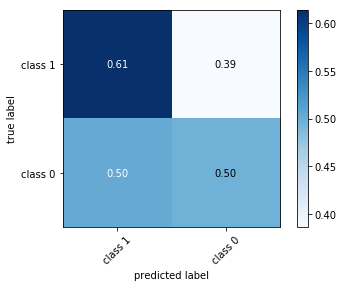

the confusion matrix:  [[590 371]
 [557 550]]
The ROC-AUC score for the test set is:  0.5531045751633987
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1224
           1       0.47      0.50      0.48       856

    accuracy                           0.56      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.57      0.56      0.56      2080



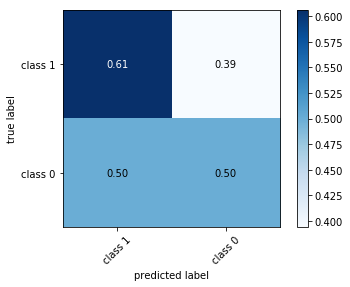

the confusion matrix:  [[742 482]
 [428 428]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 3)
##############################
CPU times: user 11 s, sys: 196 ms, total: 11.1 s
Wall time: 11.2 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 49.1min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



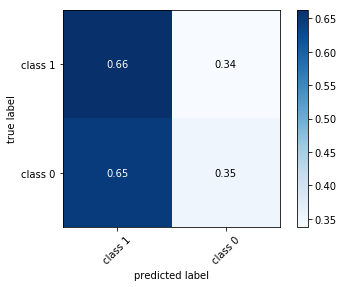

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



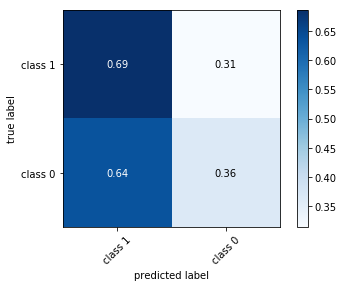

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d100,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (100, 50, 5)
##############################
CPU times: user 2min 22s, sys: 272 ms, total: 2min 22s
Wall time: 2min 22s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 48.8min finished


Best: 0.791695 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6914554716133356
              precision    recall  f1-score   support

           0       0.61      0.86      0.71       961
           1       0.81      0.53      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.71      0.69      0.68      2068
weighted avg       0.72      0.68      0.67      2068



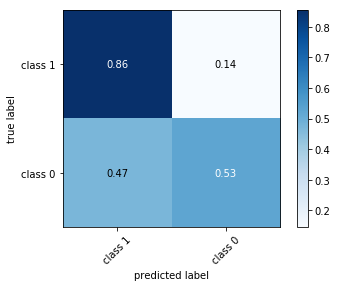

the confusion matrix:  [[822 139]
 [523 584]]
The ROC-AUC score for the test set is:  0.7229590434304562
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1224
           1       0.75      0.58      0.65       856

    accuracy                           0.75      2080
   macro avg       0.75      0.72      0.73      2080
weighted avg       0.75      0.75      0.74      2080



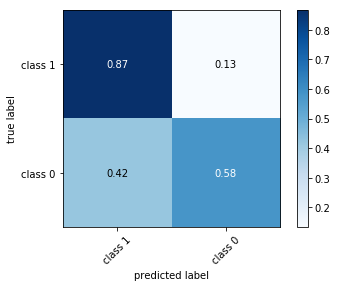

the confusion matrix:  [[1062  162]
 [ 361  495]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (100, 50, 5)
##############################
CPU times: user 3min 28s, sys: 3.21 s, total: 3min 32s
Wall time: 3min 32s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 48.6min finished


Best: 0.579793 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5411608278413689
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       961
           1       0.59      0.44      0.51      1107

    accuracy                           0.53      2068
   macro avg       0.54      0.54      0.53      2068
weighted avg       0.55      0.53      0.53      2068



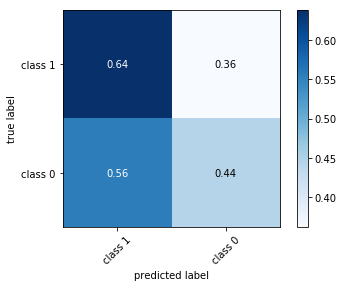

the confusion matrix:  [[613 348]
 [615 492]]
The ROC-AUC score for the test set is:  0.5518829026937878
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1224
           1       0.47      0.51      0.49       856

    accuracy                           0.56      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.57      0.56      0.56      2080



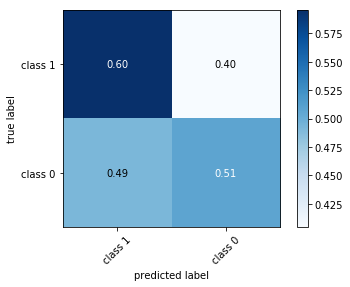

the confusion matrix:  [[729 495]
 [421 435]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (100, 50, 5)
##############################
CPU times: user 10.9 s, sys: 160 ms, total: 11.1 s
Wall time: 11.1 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 48.7min finished


Best: 0.504607 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
The ROC-AUC score for the test set is:  0.5071256886693044
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       961
           1       0.55      0.35      0.43      1107

    accuracy                           0.50      2068
   macro avg       0.51      0.51      0.49      2068
weighted avg       0.51      0.50      0.48      2068



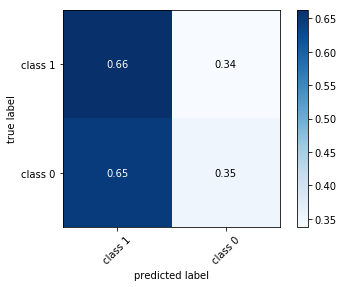

the confusion matrix:  [[637 324]
 [718 389]]
The ROC-AUC score for the test set is:  0.5253802455561664
              precision    recall  f1-score   support

           0       0.61      0.69      0.64      1224
           1       0.45      0.36      0.40       856

    accuracy                           0.55      2080
   macro avg       0.53      0.53      0.52      2080
weighted avg       0.54      0.55      0.54      2080



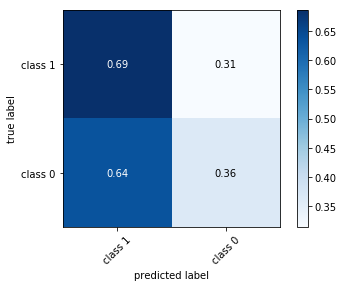

the confusion matrix:  [[840 384]
 [544 312]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 2)
##############################
CPU times: user 1min 8s, sys: 108 ms, total: 1min 8s
Wall time: 1min 8s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 137.7min finished


Best: 0.797873 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7038338940448025
              precision    recall  f1-score   support

           0       0.62      0.89      0.73       961
           1       0.84      0.52      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.69      2068
weighted avg       0.74      0.69      0.68      2068



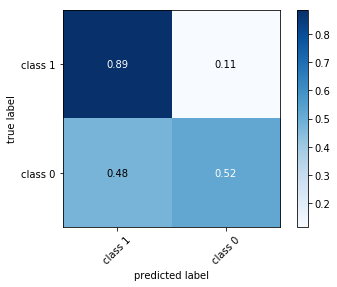

the confusion matrix:  [[851 110]
 [529 578]]
The ROC-AUC score for the test set is:  0.7061266874350987
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1224
           1       0.77      0.52      0.62       856

    accuracy                           0.74      2080
   macro avg       0.75      0.71      0.71      2080
weighted avg       0.74      0.74      0.73      2080



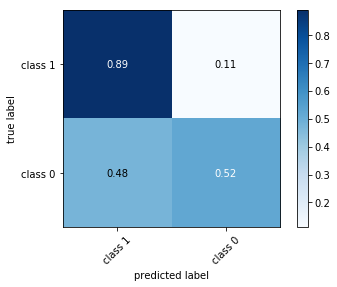

the confusion matrix:  [[1088  136]
 [ 408  448]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 2)
##############################
CPU times: user 1min 30s, sys: 1.34 s, total: 1min 32s
Wall time: 1min 32s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.8min finished


Best: 0.593054 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5583468928688593
              precision    recall  f1-score   support

           0       0.52      0.61      0.56       961
           1       0.60      0.51      0.55      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.55      2068
weighted avg       0.56      0.55      0.55      2068



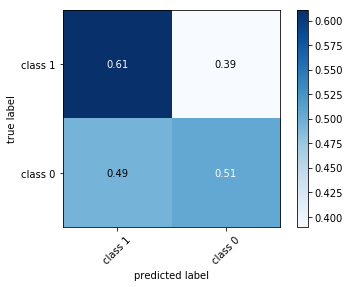

the confusion matrix:  [[587 374]
 [547 560]]
The ROC-AUC score for the test set is:  0.5709677173049905
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1224
           1       0.49      0.51      0.50       856

    accuracy                           0.58      2080
   macro avg       0.57      0.57      0.57      2080
weighted avg       0.58      0.58      0.58      2080



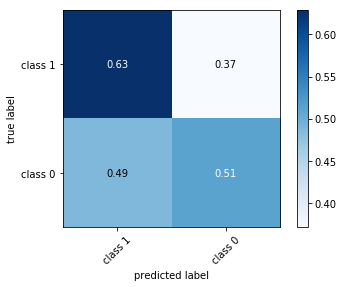

the confusion matrix:  [[770 454]
 [417 439]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 2)
##############################
CPU times: user 4.41 s, sys: 88 ms, total: 4.5 s
Wall time: 4.5 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.6min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



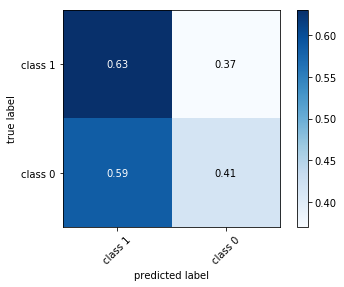

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



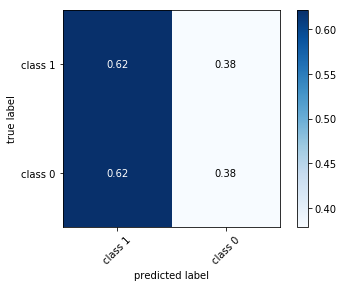

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 3)
##############################
CPU times: user 1min 7s, sys: 124 ms, total: 1min 7s
Wall time: 1min 7s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 136.8min finished


Best: 0.798049 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7002491946528899
              precision    recall  f1-score   support

           0       0.61      0.89      0.73       961
           1       0.85      0.51      0.63      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.74      0.69      0.68      2068



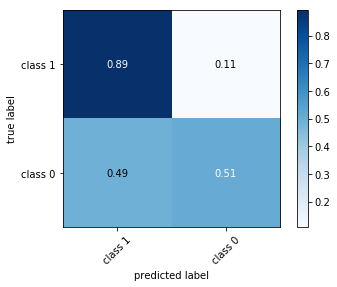

the confusion matrix:  [[858 103]
 [545 562]]
The ROC-AUC score for the test set is:  0.697193207501069
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1224
           1       0.75      0.51      0.61       856

    accuracy                           0.73      2080
   macro avg       0.74      0.70      0.70      2080
weighted avg       0.73      0.73      0.72      2080



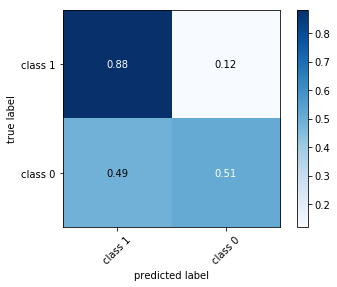

the confusion matrix:  [[1079  145]
 [ 417  439]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 3)
##############################
CPU times: user 1min 31s, sys: 1.45 s, total: 1min 33s
Wall time: 1min 33s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.0min finished


Best: 0.592522 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5691818312563979
              precision    recall  f1-score   support

           0       0.52      0.66      0.58       961
           1       0.62      0.48      0.54      1107

    accuracy                           0.56      2068
   macro avg       0.57      0.57      0.56      2068
weighted avg       0.57      0.56      0.56      2068



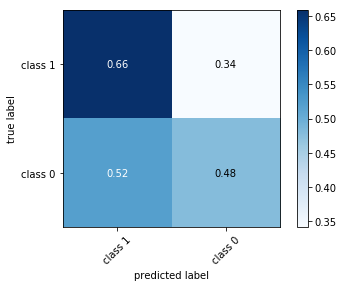

the confusion matrix:  [[633 328]
 [576 531]]
The ROC-AUC score for the test set is:  0.5693260949239509
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1224
           1       0.49      0.50      0.49       856

    accuracy                           0.58      2080
   macro avg       0.57      0.57      0.57      2080
weighted avg       0.58      0.58      0.58      2080



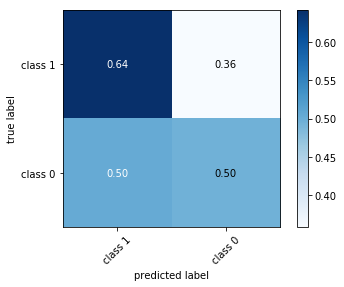

the confusion matrix:  [[786 438]
 [431 425]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 3)
##############################
CPU times: user 4.64 s, sys: 92 ms, total: 4.73 s
Wall time: 4.73 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.7min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



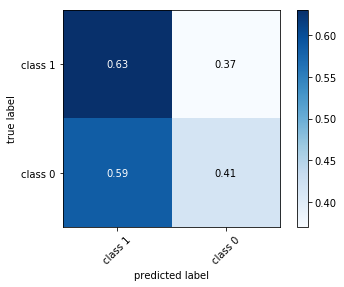

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



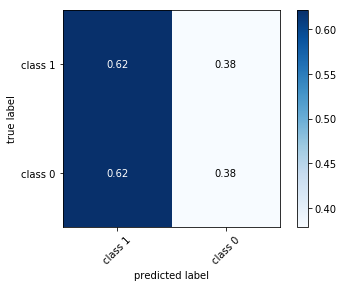

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 20, 5)
##############################
CPU times: user 1min 8s, sys: 128 ms, total: 1min 8s
Wall time: 1min 8s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 136.7min finished


Best: 0.796873 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7026161208542365
              precision    recall  f1-score   support

           0       0.61      0.89      0.73       961
           1       0.84      0.52      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.74      0.69      0.68      2068



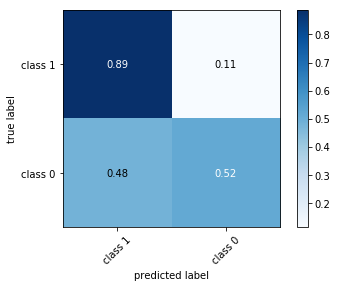

the confusion matrix:  [[853 108]
 [534 573]]
The ROC-AUC score for the test set is:  0.7037291552134873
              precision    recall  f1-score   support

           0       0.72      0.89      0.80      1224
           1       0.77      0.51      0.62       856

    accuracy                           0.74      2080
   macro avg       0.75      0.70      0.71      2080
weighted avg       0.74      0.74      0.72      2080



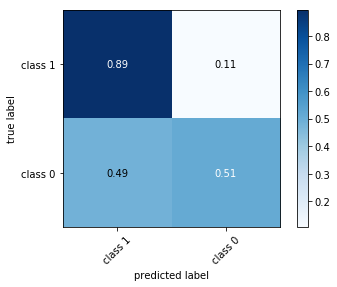

the confusion matrix:  [[1095  129]
 [ 417  439]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 20, 5)
##############################
CPU times: user 1min 32s, sys: 1.43 s, total: 1min 34s
Wall time: 1min 34s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.6min finished


Best: 0.595156 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5591078248625011
              precision    recall  f1-score   support

           0       0.51      0.66      0.58       961
           1       0.61      0.46      0.52      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.55      2068
weighted avg       0.56      0.55      0.55      2068



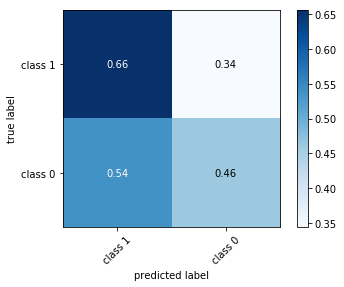

the confusion matrix:  [[631 330]
 [596 511]]
The ROC-AUC score for the test set is:  0.5520317940260215
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1224
           1       0.48      0.45      0.46       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.57      0.57      0.57      2080



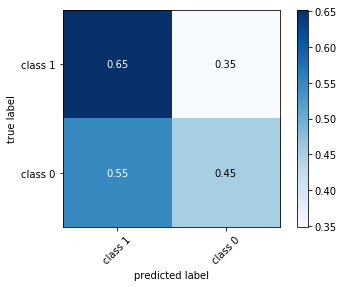

the confusion matrix:  [[798 426]
 [469 387]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 20, 5)
##############################
CPU times: user 4.33 s, sys: 112 ms, total: 4.45 s
Wall time: 4.45 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.3min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



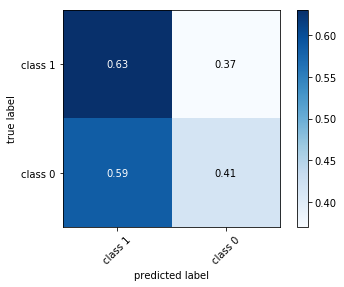

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



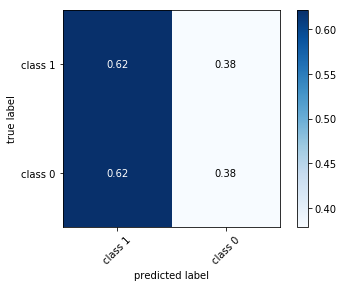

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 2)
##############################
CPU times: user 1min 41s, sys: 244 ms, total: 1min 41s
Wall time: 1min 41s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.8min finished


Best: 0.793553 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6928964953888178
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.51      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.69      0.67      2068
weighted avg       0.72      0.68      0.67      2068



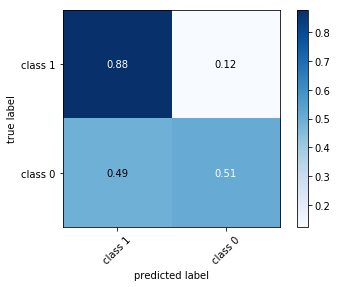

the confusion matrix:  [[843 118]
 [544 563]]
The ROC-AUC score for the test set is:  0.7164116425386353
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1224
           1       0.76      0.55      0.64       856

    accuracy                           0.75      2080
   macro avg       0.75      0.72      0.72      2080
weighted avg       0.75      0.75      0.74      2080



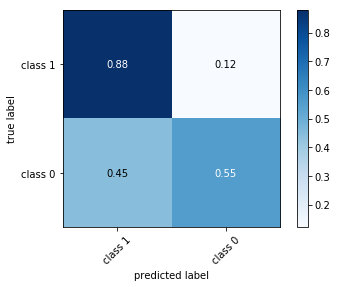

the confusion matrix:  [[1076  148]
 [ 382  474]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 2)
##############################
CPU times: user 2min 13s, sys: 1.93 s, total: 2min 15s
Wall time: 2min 15s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.0min finished


Best: 0.586848 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5475016144542298
              precision    recall  f1-score   support

           0       0.50      0.66      0.57       961
           1       0.60      0.44      0.50      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.55      0.54      2068
weighted avg       0.55      0.54      0.53      2068



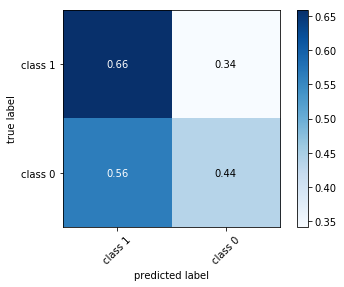

the confusion matrix:  [[633 328]
 [624 483]]
The ROC-AUC score for the test set is:  0.5512109828355019
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1224
           1       0.48      0.44      0.46       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.57      0.57      0.57      2080



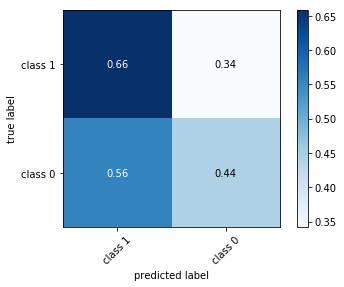

the confusion matrix:  [[806 418]
 [476 380]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 2)
##############################
CPU times: user 6.57 s, sys: 92.1 ms, total: 6.66 s
Wall time: 6.66 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.5min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



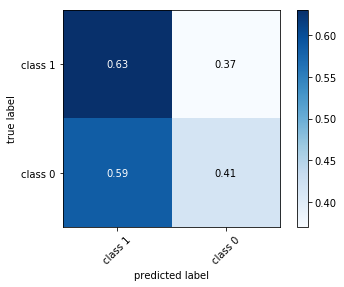

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



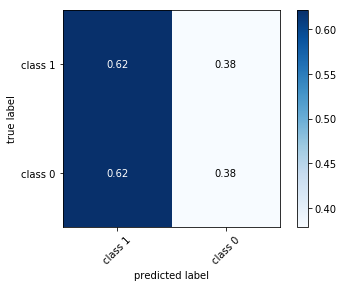

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 3)
##############################
CPU times: user 1min 42s, sys: 148 ms, total: 1min 42s
Wall time: 1min 42s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.4min finished


Best: 0.794448 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6967157253952005
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.51      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.70      0.68      2068
weighted avg       0.73      0.68      0.67      2068



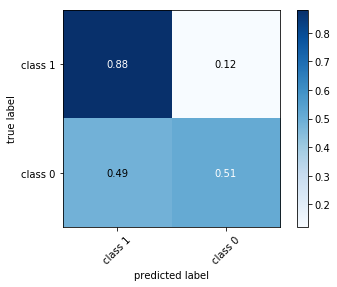

the confusion matrix:  [[846 115]
 [539 568]]
The ROC-AUC score for the test set is:  0.7127886201209456
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1224
           1       0.76      0.54      0.63       856

    accuracy                           0.74      2080
   macro avg       0.75      0.71      0.72      2080
weighted avg       0.75      0.74      0.73      2080



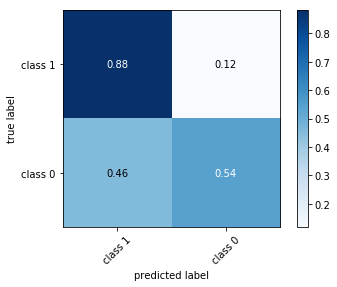

the confusion matrix:  [[1080  144]
 [ 391  465]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 3)
##############################
CPU times: user 2min 15s, sys: 2.06 s, total: 2min 17s
Wall time: 2min 17s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.3min finished


Best: 0.579308 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5532534895241425
              precision    recall  f1-score   support

           0       0.51      0.68      0.58       961
           1       0.61      0.43      0.50      1107

    accuracy                           0.54      2068
   macro avg       0.56      0.55      0.54      2068
weighted avg       0.56      0.54      0.54      2068



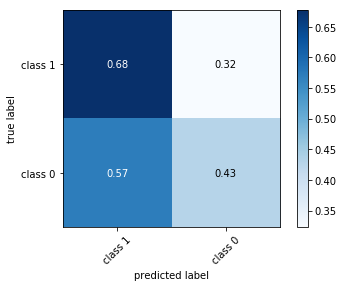

the confusion matrix:  [[651 310]
 [632 475]]
The ROC-AUC score for the test set is:  0.5454309449636552
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1224
           1       0.47      0.44      0.45       856

    accuracy                           0.56      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.56      0.56      0.56      2080



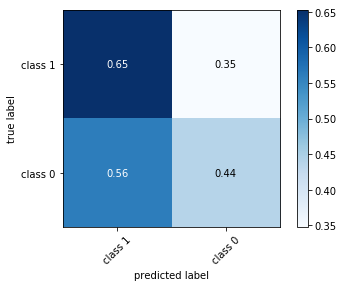

the confusion matrix:  [[799 425]
 [481 375]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 3)
##############################
CPU times: user 6.47 s, sys: 124 ms, total: 6.6 s
Wall time: 6.6 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.3min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



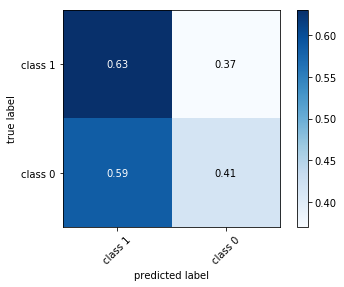

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



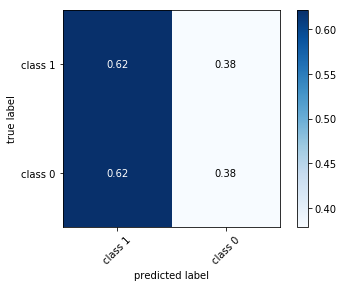

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 30, 5)
##############################
CPU times: user 1min 42s, sys: 200 ms, total: 1min 42s
Wall time: 1min 42s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.4min finished


Best: 0.792902 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7015755381279098
              precision    recall  f1-score   support

           0       0.61      0.89      0.73       961
           1       0.84      0.52      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.73      0.69      0.68      2068



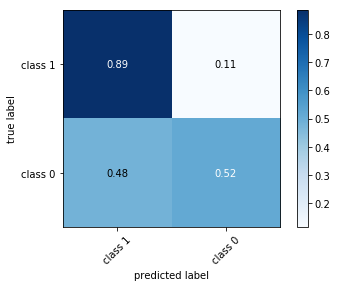

the confusion matrix:  [[851 110]
 [534 573]]
The ROC-AUC score for the test set is:  0.7067757009345794
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1224
           1       0.75      0.54      0.63       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.71      2080
weighted avg       0.74      0.74      0.73      2080



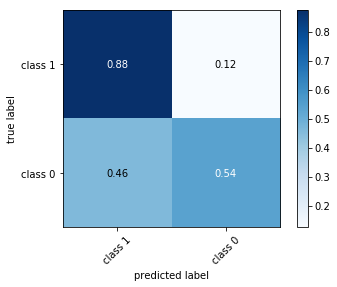

the confusion matrix:  [[1071  153]
 [ 395  461]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 30, 5)
##############################
CPU times: user 2min 19s, sys: 2.04 s, total: 2min 21s
Wall time: 2min 21s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.4min finished


Best: 0.583414 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5462960612956805
              precision    recall  f1-score   support

           0       0.50      0.73      0.59       961
           1       0.61      0.36      0.45      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.55      0.52      2068
weighted avg       0.56      0.53      0.52      2068



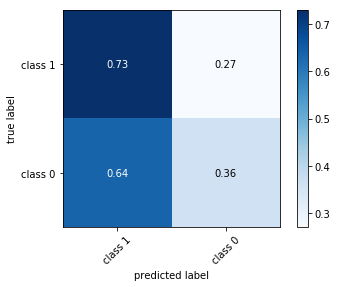

the confusion matrix:  [[701 260]
 [705 402]]
The ROC-AUC score for the test set is:  0.5469274937389286
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      1224
           1       0.48      0.39      0.43       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.56      0.57      0.57      2080



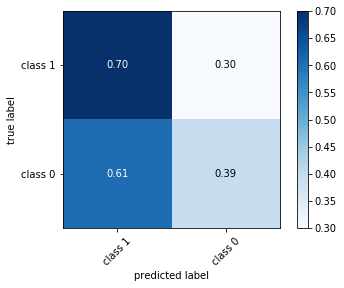

the confusion matrix:  [[857 367]
 [519 337]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 30, 5)
##############################
CPU times: user 6.42 s, sys: 144 ms, total: 6.57 s
Wall time: 6.57 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.1min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



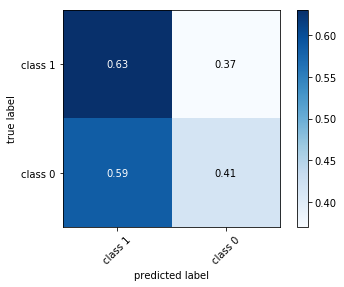

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



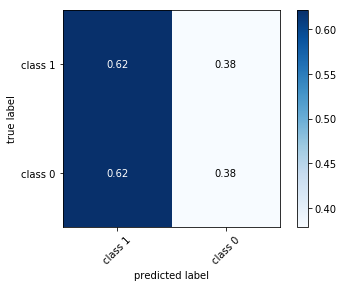

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 2)
##############################
CPU times: user 2min 48s, sys: 340 ms, total: 2min 48s
Wall time: 2min 48s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.8min finished


Best: 0.791924 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6947431302270013
              precision    recall  f1-score   support

           0       0.61      0.87      0.72       961
           1       0.82      0.52      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.69      0.68      2068
weighted avg       0.72      0.68      0.67      2068



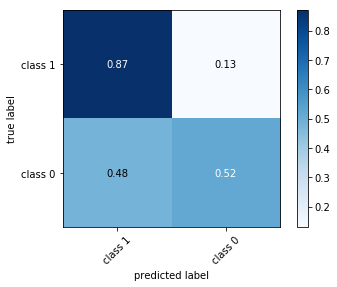

the confusion matrix:  [[837 124]
 [533 574]]
The ROC-AUC score for the test set is:  0.7107499541872824
              precision    recall  f1-score   support

           0       0.73      0.87      0.80      1224
           1       0.75      0.55      0.63       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.72      2080
weighted avg       0.74      0.74      0.73      2080



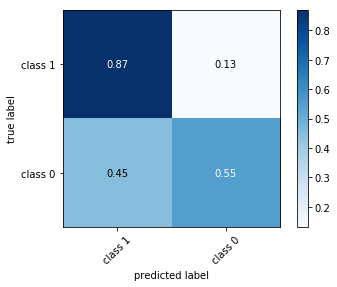

the confusion matrix:  [[1065  159]
 [ 384  472]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 2)
##############################
CPU times: user 3min 41s, sys: 3.5 s, total: 3min 45s
Wall time: 3min 45s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.8min finished


Best: 0.569583 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5654608315073786
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       961
           1       0.64      0.38      0.48      1107

    accuracy                           0.55      2068
   macro avg       0.57      0.57      0.54      2068
weighted avg       0.58      0.55      0.54      2068



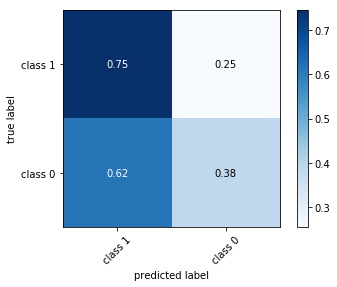

the confusion matrix:  [[717 244]
 [681 426]]
The ROC-AUC score for the test set is:  0.5301676745464541
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1224
           1       0.46      0.37      0.41       856

    accuracy                           0.56      2080
   macro avg       0.53      0.53      0.53      2080
weighted avg       0.55      0.56      0.55      2080



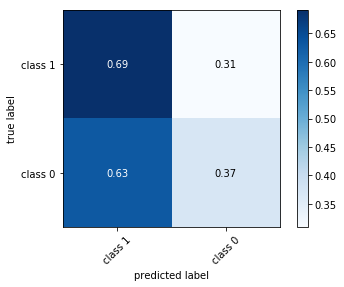

the confusion matrix:  [[846 378]
 [540 316]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 2)
##############################
CPU times: user 11 s, sys: 168 ms, total: 11.2 s
Wall time: 11.2 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.6min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



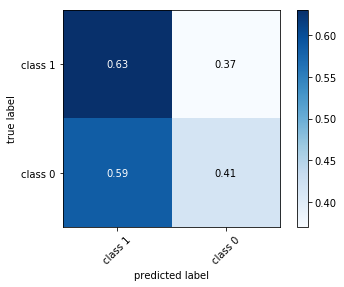

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



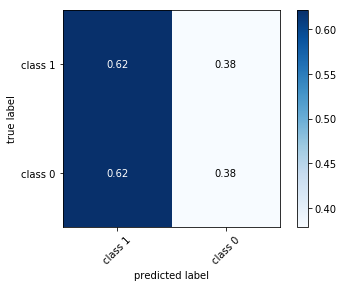

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 3)
##############################
CPU times: user 2min 48s, sys: 300 ms, total: 2min 49s
Wall time: 2min 49s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.6min finished


Best: 0.791397 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6965211448853997
              precision    recall  f1-score   support

           0       0.61      0.86      0.72       961
           1       0.82      0.53      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.70      0.68      2068
weighted avg       0.72      0.68      0.68      2068



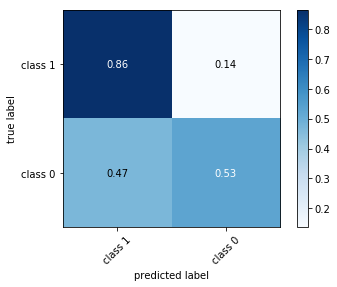

the confusion matrix:  [[830 131]
 [521 586]]
The ROC-AUC score for the test set is:  0.7261163032191069
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1224
           1       0.75      0.59      0.66       856

    accuracy                           0.75      2080
   macro avg       0.75      0.73      0.73      2080
weighted avg       0.75      0.75      0.74      2080



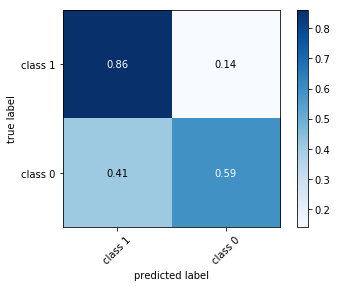

the confusion matrix:  [[1054  170]
 [ 350  506]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 3)
##############################
CPU times: user 3min 44s, sys: 3.52 s, total: 3min 47s
Wall time: 3min 47s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 134.0min finished


Best: 0.568367 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5395609436496724
              precision    recall  f1-score   support

           0       0.49      0.72      0.59       961
           1       0.60      0.36      0.45      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.54      0.52      2068
weighted avg       0.55      0.53      0.51      2068



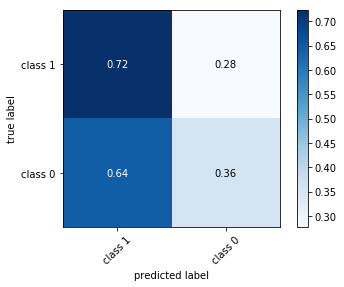

the confusion matrix:  [[695 266]
 [713 394]]
The ROC-AUC score for the test set is:  0.5415483171461732
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1224
           1       0.47      0.37      0.42       856

    accuracy                           0.57      2080
   macro avg       0.55      0.54      0.54      2080
weighted avg       0.56      0.57      0.56      2080



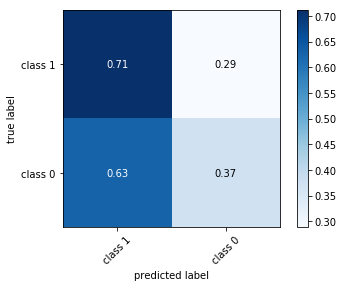

the confusion matrix:  [[871 353]
 [538 318]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 3)
##############################
CPU times: user 11.2 s, sys: 220 ms, total: 11.4 s
Wall time: 11.4 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.1min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



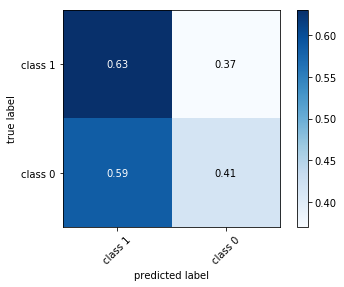

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



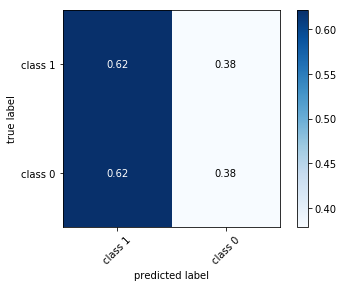

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d300,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d300,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (300, 50, 5)
##############################
CPU times: user 2min 49s, sys: 312 ms, total: 2min 50s
Wall time: 2min 50s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.2min finished


Best: 0.792813 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.689442926340467
              precision    recall  f1-score   support

           0       0.61      0.85      0.71       961
           1       0.80      0.53      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.71      0.69      0.67      2068
weighted avg       0.71      0.68      0.67      2068



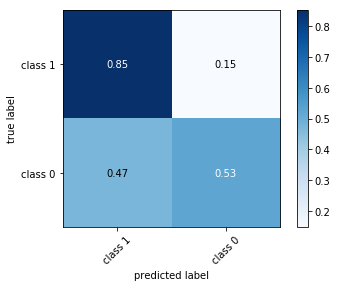

the confusion matrix:  [[819 142]
 [524 583]]
The ROC-AUC score for the test set is:  0.722199315863417
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1224
           1       0.75      0.58      0.65       856

    accuracy                           0.75      2080
   macro avg       0.75      0.72      0.73      2080
weighted avg       0.75      0.75      0.74      2080



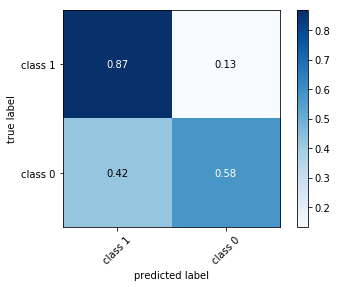

the confusion matrix:  [[1063  161]
 [ 363  493]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (300, 50, 5)
##############################
CPU times: user 3min 49s, sys: 3.3 s, total: 3min 53s
Wall time: 3min 53s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 135.4min finished


Best: 0.572416 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5402358654179674
              precision    recall  f1-score   support

           0       0.49      0.75      0.59       961
           1       0.60      0.33      0.43      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.54      0.51      2068
weighted avg       0.55      0.53      0.51      2068



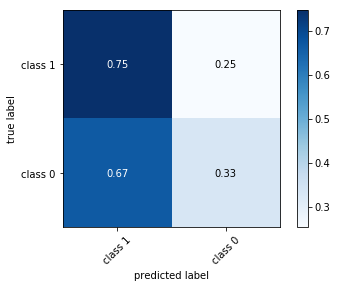

the confusion matrix:  [[718 243]
 [738 369]]
The ROC-AUC score for the test set is:  0.5239676867631787
              precision    recall  f1-score   support

           0       0.61      0.71      0.65      1224
           1       0.45      0.34      0.39       856

    accuracy                           0.56      2080
   macro avg       0.53      0.52      0.52      2080
weighted avg       0.54      0.56      0.54      2080



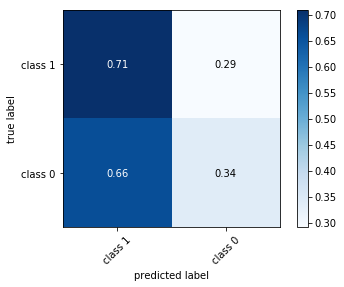

the confusion matrix:  [[868 356]
 [566 290]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (300, 50, 5)
##############################
CPU times: user 10.9 s, sys: 120 ms, total: 11 s
Wall time: 11 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 133.7min finished


Best: 0.505434 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 9}
The ROC-AUC score for the test set is:  0.5226136392477349
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       961
           1       0.56      0.41      0.48      1107

    accuracy                           0.51      2068
   macro avg       0.52      0.52      0.51      2068
weighted avg       0.53      0.51      0.51      2068



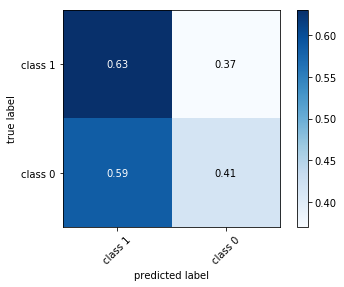

the confusion matrix:  [[606 355]
 [648 459]]
The ROC-AUC score for the test set is:  0.49970985278846736
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1224
           1       0.41      0.38      0.39       856

    accuracy                           0.52      2080
   macro avg       0.50      0.50      0.50      2080
weighted avg       0.52      0.52      0.52      2080



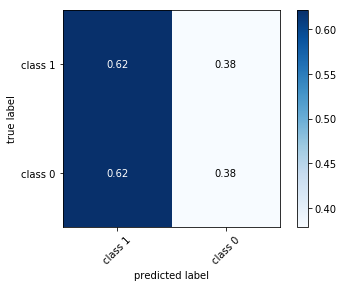

the confusion matrix:  [[760 464]
 [532 324]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 2)
##############################
CPU times: user 1min 18s, sys: 176 ms, total: 1min 18s
Wall time: 1min 18s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 217.8min finished


Best: 0.799524 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6999060937539656
              precision    recall  f1-score   support

           0       0.61      0.89      0.72       961
           1       0.84      0.51      0.64      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.68      2068
weighted avg       0.73      0.69      0.68      2068



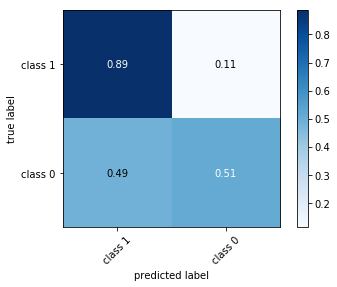

the confusion matrix:  [[853 108]
 [540 567]]
The ROC-AUC score for the test set is:  0.6978345855476147
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1224
           1       0.76      0.51      0.61       856

    accuracy                           0.73      2080
   macro avg       0.74      0.70      0.70      2080
weighted avg       0.74      0.73      0.72      2080



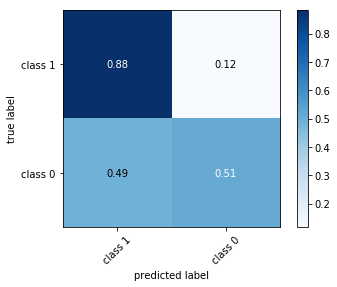

the confusion matrix:  [[1082  142]
 [ 418  438]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 2)
##############################
CPU times: user 1min 39s, sys: 1.49 s, total: 1min 40s
Wall time: 1min 40s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 211.0min finished


Best: 0.593264 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5752819772387804
              precision    recall  f1-score   support

           0       0.53      0.63      0.58       961
           1       0.62      0.52      0.56      1107

    accuracy                           0.57      2068
   macro avg       0.58      0.58      0.57      2068
weighted avg       0.58      0.57      0.57      2068



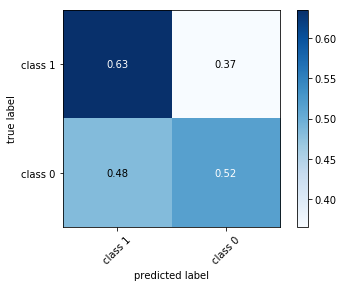

the confusion matrix:  [[610 351]
 [536 571]]
The ROC-AUC score for the test set is:  0.5643210555250138
              precision    recall  f1-score   support

           0       0.65      0.60      0.62      1224
           1       0.48      0.53      0.50       856

    accuracy                           0.57      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.58      0.57      0.57      2080



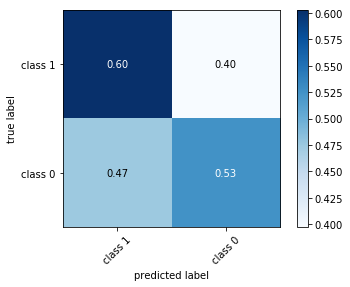

the confusion matrix:  [[738 486]
 [406 450]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 2)
##############################
CPU times: user 4.4 s, sys: 71.9 ms, total: 4.47 s
Wall time: 4.48 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 211.4min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



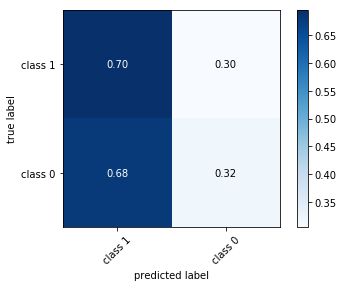

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



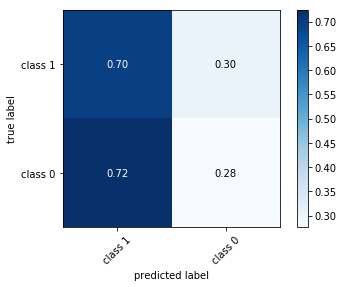

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 3)
##############################
CPU times: user 1min 19s, sys: 124 ms, total: 1min 19s
Wall time: 1min 19s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 215.4min finished


Best: 0.799254 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.7083106557739183
              precision    recall  f1-score   support

           0       0.62      0.89      0.73       961
           1       0.85      0.52      0.65      1107

    accuracy                           0.70      2068
   macro avg       0.73      0.71      0.69      2068
weighted avg       0.74      0.70      0.69      2068



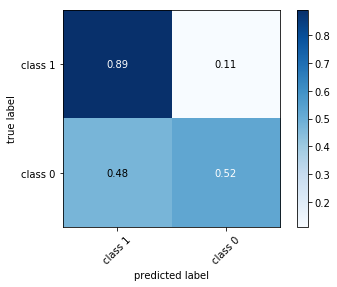

the confusion matrix:  [[857 104]
 [526 581]]
The ROC-AUC score for the test set is:  0.7051951621770203
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1224
           1       0.76      0.53      0.62       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.71      2080
weighted avg       0.74      0.74      0.73      2080



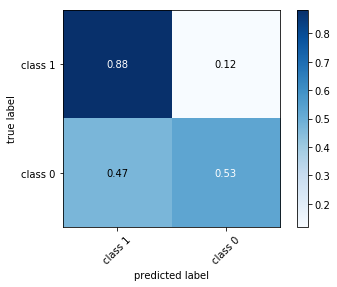

the confusion matrix:  [[1080  144]
 [ 404  452]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 3)
##############################
CPU times: user 1min 40s, sys: 1.42 s, total: 1min 41s
Wall time: 1min 41s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 213.0min finished


Best: 0.594539 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5562431673570984
              precision    recall  f1-score   support

           0       0.51      0.63      0.57       961
           1       0.60      0.48      0.53      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.55      2068
weighted avg       0.56      0.55      0.55      2068



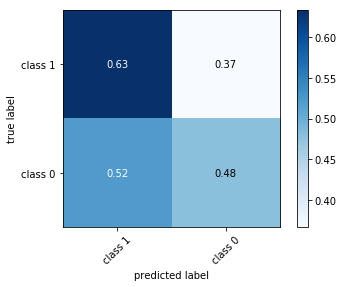

the confusion matrix:  [[609 352]
 [577 530]]
The ROC-AUC score for the test set is:  0.5765225093152526
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1224
           1       0.49      0.54      0.51       856

    accuracy                           0.58      2080
   macro avg       0.57      0.58      0.58      2080
weighted avg       0.59      0.58      0.59      2080



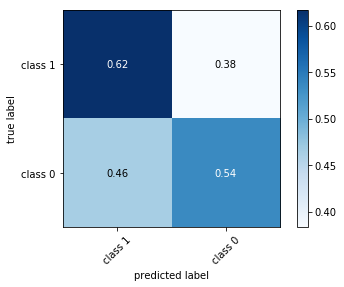

the confusion matrix:  [[755 469]
 [397 459]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 3)
##############################
CPU times: user 4.29 s, sys: 120 ms, total: 4.41 s
Wall time: 4.41 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 209.9min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



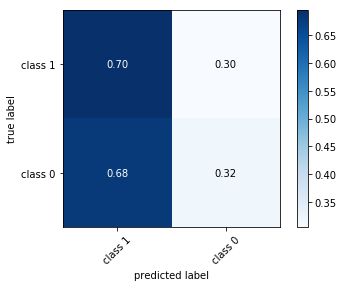

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



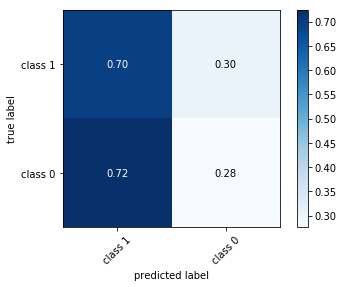

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 20, 5)
##############################
CPU times: user 1min 18s, sys: 124 ms, total: 1min 18s
Wall time: 1min 18s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 216.3min finished


Best: 0.798165 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.703559413325663
              precision    recall  f1-score   support

           0       0.62      0.88      0.73       961
           1       0.84      0.53      0.65      1107

    accuracy                           0.69      2068
   macro avg       0.73      0.70      0.69      2068
weighted avg       0.73      0.69      0.68      2068



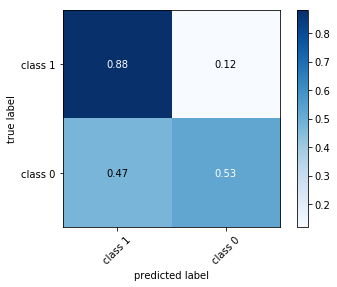

the confusion matrix:  [[847 114]
 [525 582]]
The ROC-AUC score for the test set is:  0.7058976238470466
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1224
           1       0.75      0.53      0.62       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.71      2080
weighted avg       0.74      0.74      0.73      2080



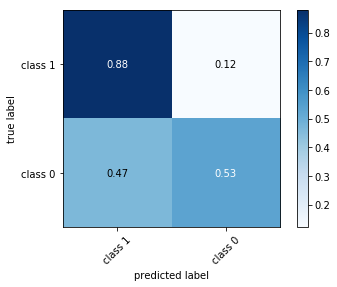

the confusion matrix:  [[1076  148]
 [ 400  456]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 20, 5)
##############################
CPU times: user 1min 42s, sys: 1.29 s, total: 1min 44s
Wall time: 1min 44s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 212.0min finished


Best: 0.597942 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5604689484286449
              precision    recall  f1-score   support

           0       0.51      0.69      0.59       961
           1       0.62      0.43      0.51      1107

    accuracy                           0.55      2068
   macro avg       0.56      0.56      0.55      2068
weighted avg       0.57      0.55      0.54      2068



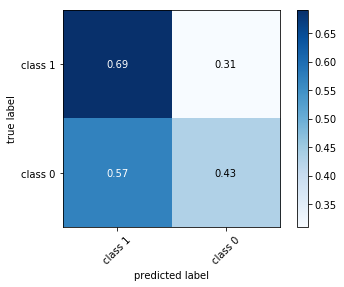

the confusion matrix:  [[664 297]
 [631 476]]
The ROC-AUC score for the test set is:  0.5948285077270783
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      1224
           1       0.53      0.50      0.51       856

    accuracy                           0.61      2080
   macro avg       0.60      0.59      0.60      2080
weighted avg       0.61      0.61      0.61      2080



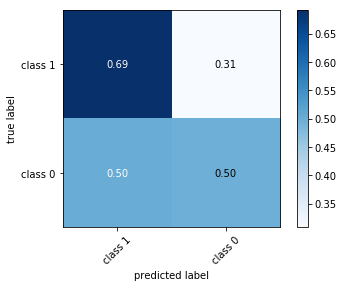

the confusion matrix:  [[847 377]
 [430 426]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 20, 5)
##############################
CPU times: user 4.35 s, sys: 72 ms, total: 4.42 s
Wall time: 4.42 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 211.5min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



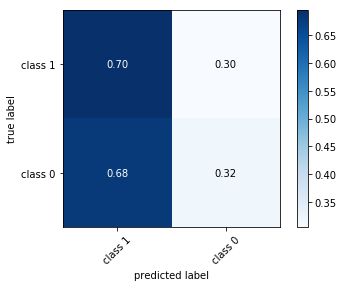

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



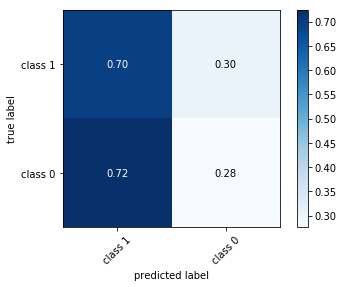

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 2)
##############################
CPU times: user 1min 58s, sys: 208 ms, total: 1min 59s
Wall time: 1min 59s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 214.7min finished


Best: 0.793930 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6927879251043638
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.50      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.69      0.67      2068
weighted avg       0.73      0.68      0.67      2068



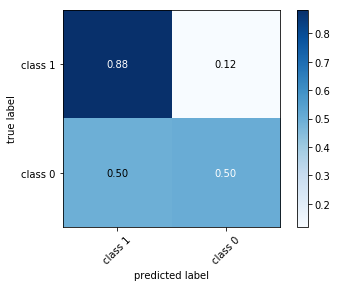

the confusion matrix:  [[848 113]
 [550 557]]
The ROC-AUC score for the test set is:  0.7005260827072262
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1224
           1       0.75      0.53      0.62       856

    accuracy                           0.73      2080
   macro avg       0.74      0.70      0.71      2080
weighted avg       0.73      0.73      0.72      2080



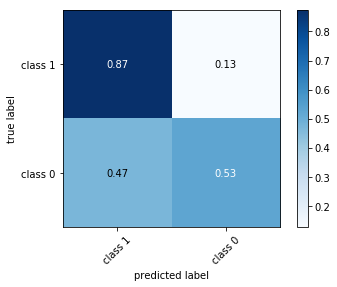

the confusion matrix:  [[1070  154]
 [ 405  451]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 2)
##############################
CPU times: user 2min 25s, sys: 2.08 s, total: 2min 27s
Wall time: 2min 27s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 213.2min finished


Best: 0.585646 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5511948841305965
              precision    recall  f1-score   support

           0       0.51      0.65      0.57       961
           1       0.60      0.46      0.52      1107

    accuracy                           0.54      2068
   macro avg       0.55      0.55      0.54      2068
weighted avg       0.56      0.54      0.54      2068



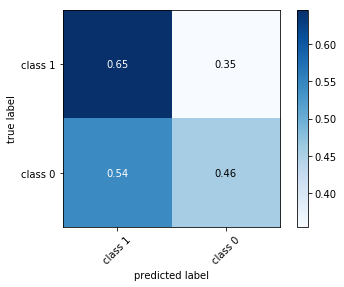

the confusion matrix:  [[621 340]
 [602 505]]
The ROC-AUC score for the test set is:  0.559911581455012
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1224
           1       0.49      0.46      0.47       856

    accuracy                           0.58      2080
   macro avg       0.56      0.56      0.56      2080
weighted avg       0.57      0.58      0.58      2080



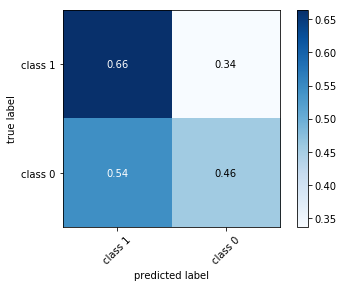

the confusion matrix:  [[813 411]
 [466 390]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 2)
##############################
CPU times: user 6.53 s, sys: 116 ms, total: 6.64 s
Wall time: 6.65 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.8min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



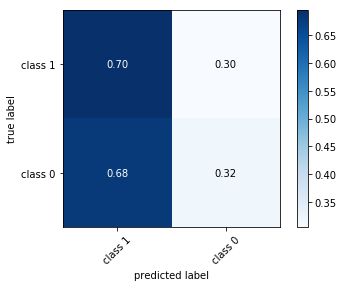

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



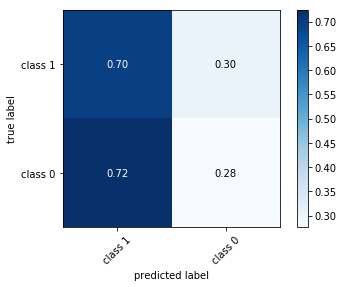

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 3)
##############################
CPU times: user 1min 57s, sys: 248 ms, total: 1min 57s
Wall time: 1min 57s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 212.2min finished


Best: 0.794701 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6932795463924115
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.51      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.69      0.67      2068
weighted avg       0.72      0.68      0.67      2068



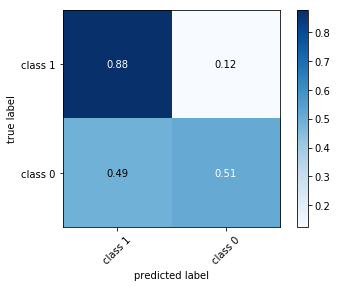

the confusion matrix:  [[842 119]
 [542 565]]
The ROC-AUC score for the test set is:  0.7143691588785046
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1224
           1       0.76      0.55      0.64       856

    accuracy                           0.74      2080
   macro avg       0.75      0.71      0.72      2080
weighted avg       0.74      0.74      0.73      2080



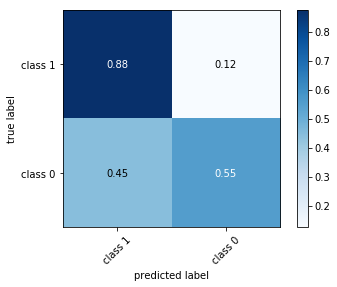

the confusion matrix:  [[1071  153]
 [ 382  474]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 3)
##############################
CPU times: user 2min 28s, sys: 1.98 s, total: 2min 30s
Wall time: 2min 30s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 211.5min finished


Best: 0.584506 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.552801818340764
              precision    recall  f1-score   support

           0       0.51      0.68      0.58       961
           1       0.60      0.43      0.50      1107

    accuracy                           0.54      2068
   macro avg       0.56      0.55      0.54      2068
weighted avg       0.56      0.54      0.54      2068



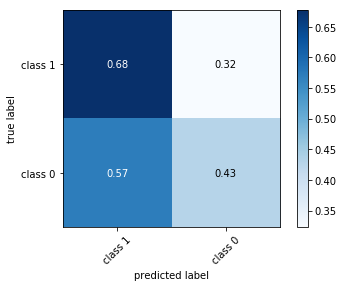

the confusion matrix:  [[651 310]
 [633 474]]
The ROC-AUC score for the test set is:  0.5528487874900739
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1224
           1       0.48      0.45      0.46       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.57      0.57      0.57      2080



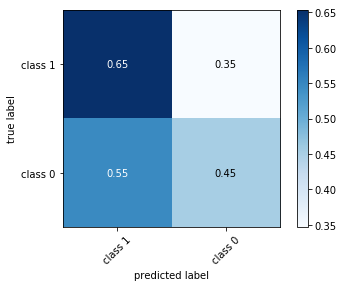

the confusion matrix:  [[800 424]
 [469 387]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 3)
##############################
CPU times: user 6.59 s, sys: 132 ms, total: 6.72 s
Wall time: 6.73 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 212.1min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



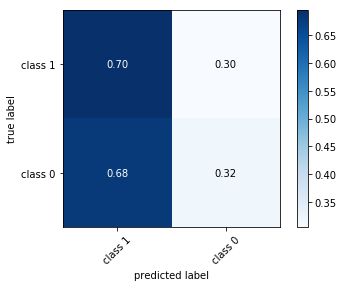

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



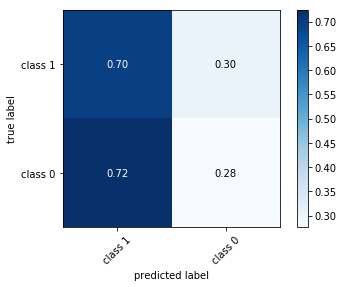

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 30, 5)
##############################
CPU times: user 2min 6s, sys: 362 ms, total: 2min 7s
Wall time: 2min 7s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 213.5min finished


Best: 0.793413 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6951948014103796
              precision    recall  f1-score   support

           0       0.61      0.87      0.72       961
           1       0.82      0.52      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.70      0.68      2068
weighted avg       0.72      0.68      0.67      2068



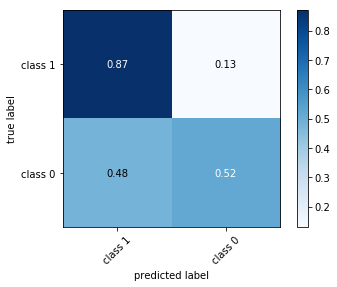

the confusion matrix:  [[837 124]
 [532 575]]
The ROC-AUC score for the test set is:  0.7057258261560075
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1224
           1       0.75      0.54      0.63       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.71      2080
weighted avg       0.74      0.74      0.73      2080



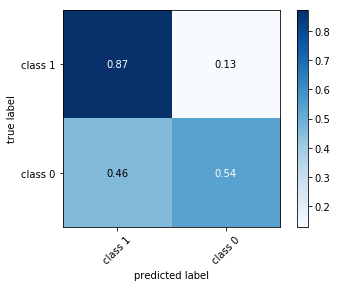

the confusion matrix:  [[1067  157]
 [ 394  462]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 30, 5)
##############################
CPU times: user 2min 32s, sys: 1.85 s, total: 2min 34s
Wall time: 2min 34s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.3min finished


Best: 0.582092 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5534941301546209
              precision    recall  f1-score   support

           0       0.50      0.72      0.59       961
           1       0.61      0.38      0.47      1107

    accuracy                           0.54      2068
   macro avg       0.56      0.55      0.53      2068
weighted avg       0.56      0.54      0.53      2068



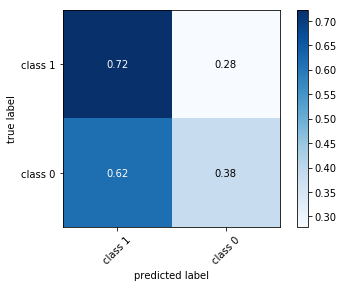

the confusion matrix:  [[694 267]
 [681 426]]
The ROC-AUC score for the test set is:  0.563343717549325
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1224
           1       0.50      0.43      0.46       856

    accuracy                           0.59      2080
   macro avg       0.57      0.56      0.56      2080
weighted avg       0.58      0.59      0.58      2080



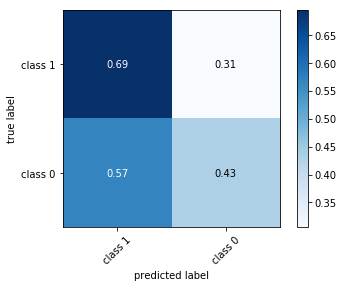

the confusion matrix:  [[850 374]
 [486 370]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 30, 5)
##############################
CPU times: user 6.67 s, sys: 124 ms, total: 6.79 s
Wall time: 7.3 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 209.8min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



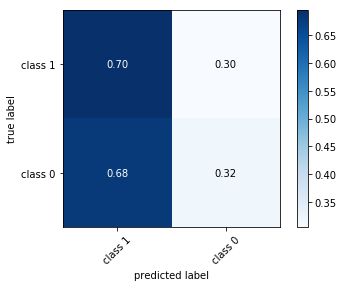

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



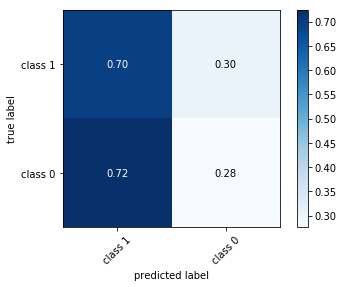

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w2,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 2)
##############################
CPU times: user 3min 15s, sys: 352 ms, total: 3min 15s
Wall time: 3min 15s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.0min finished


Best: 0.792221 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6958523331331129
              precision    recall  f1-score   support

           0       0.61      0.87      0.72       961
           1       0.83      0.52      0.64      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.70      0.68      2068
weighted avg       0.73      0.68      0.67      2068



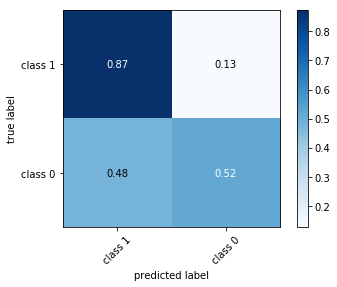

the confusion matrix:  [[840 121]
 [534 573]]
The ROC-AUC score for the test set is:  0.7231919247449758
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1224
           1       0.76      0.58      0.65       856

    accuracy                           0.75      2080
   macro avg       0.75      0.72      0.73      2080
weighted avg       0.75      0.75      0.74      2080



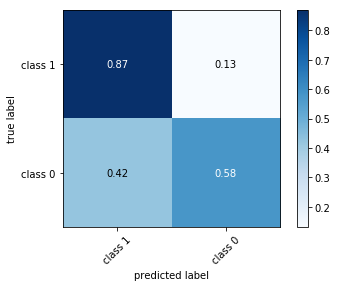

the confusion matrix:  [[1064  160]
 [ 362  494]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 2)
##############################
CPU times: user 3min 58s, sys: 3.26 s, total: 4min 1s
Wall time: 4min 1s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.1min finished


Best: 0.568156 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5435174140156247
              precision    recall  f1-score   support

           0       0.50      0.73      0.59       961
           1       0.60      0.36      0.45      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.54      0.52      2068
weighted avg       0.55      0.53      0.52      2068



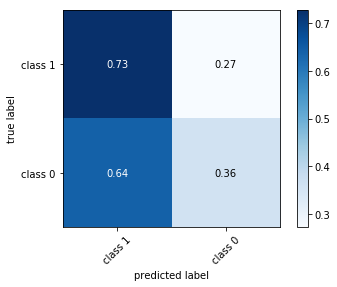

the confusion matrix:  [[700 261]
 [710 397]]
The ROC-AUC score for the test set is:  0.54540803860485
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      1224
           1       0.48      0.39      0.43       856

    accuracy                           0.57      2080
   macro avg       0.55      0.55      0.54      2080
weighted avg       0.56      0.57      0.56      2080



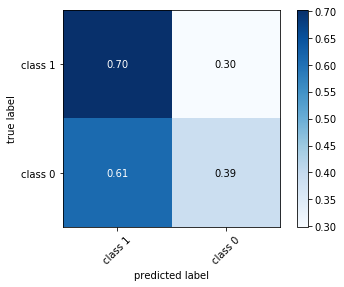

the confusion matrix:  [[859 365]
 [523 333]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 2)
##############################
CPU times: user 10.8 s, sys: 219 ms, total: 11 s
Wall time: 11.2 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 211.3min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



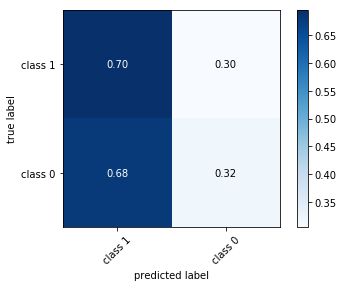

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



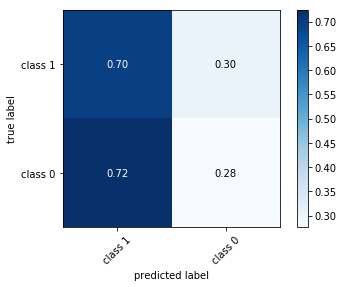

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w3,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 3)
##############################
CPU times: user 3min 22s, sys: 464 ms, total: 3min 22s
Wall time: 3min 22s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.4min finished


Best: 0.793085 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6915527618682361
              precision    recall  f1-score   support

           0       0.61      0.86      0.71       961
           1       0.81      0.52      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.71      0.69      0.67      2068
weighted avg       0.72      0.68      0.67      2068



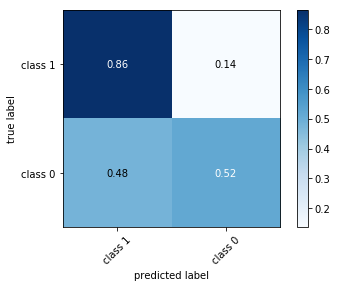

the confusion matrix:  [[830 131]
 [532 575]]
The ROC-AUC score for the test set is:  0.7147814733369984
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1224
           1       0.75      0.56      0.64       856

    accuracy                           0.74      2080
   macro avg       0.74      0.71      0.72      2080
weighted avg       0.74      0.74      0.73      2080



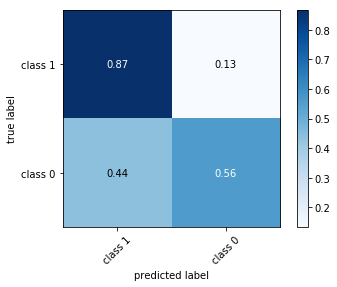

the confusion matrix:  [[1062  162]
 [ 375  481]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 3)
##############################
CPU times: user 4min 1s, sys: 3.34 s, total: 4min 4s
Wall time: 4min 4s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.5min finished


Best: 0.569910 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5404816760619913
              precision    recall  f1-score   support

           0       0.49      0.74      0.59       961
           1       0.60      0.34      0.43      1107

    accuracy                           0.53      2068
   macro avg       0.55      0.54      0.51      2068
weighted avg       0.55      0.53      0.51      2068



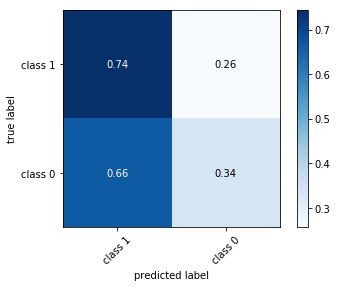

the confusion matrix:  [[715 246]
 [734 373]]
The ROC-AUC score for the test set is:  0.5413154358316535
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1224
           1       0.47      0.37      0.42       856

    accuracy                           0.57      2080
   macro avg       0.55      0.54      0.54      2080
weighted avg       0.56      0.57      0.56      2080



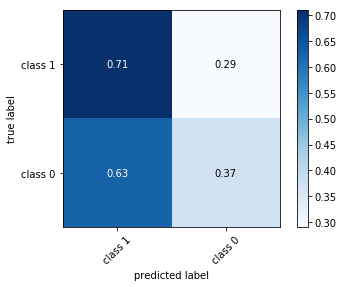

the confusion matrix:  [[869 355]
 [537 319]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 3)
##############################
CPU times: user 10.8 s, sys: 188 ms, total: 11 s
Wall time: 11.1 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.3min finished


Best: 0.504759 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5074462295091213
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       961
           1       0.55      0.32      0.40      1107

    accuracy                           0.49      2068
   macro avg       0.51      0.51      0.48      2068
weighted avg       0.51      0.49      0.48      2068



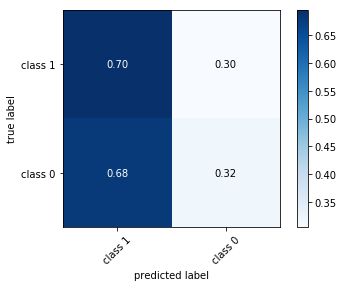

the confusion matrix:  [[668 293]
 [753 354]]
The ROC-AUC score for the test set is:  0.48548118624396797
              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1224
           1       0.39      0.28      0.32       856

    accuracy                           0.52      2080
   macro avg       0.48      0.49      0.48      2080
weighted avg       0.50      0.52      0.50      2080



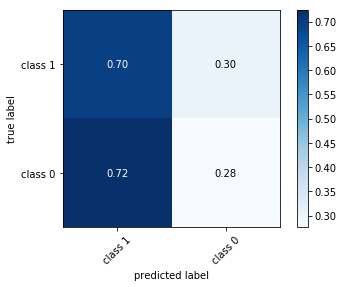

the confusion matrix:  [[851 373]
 [620 236]]
---------------------------------------------------------------
Doc2Vec(dbow,d500,n5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized
Doc2Vec(dm/c,d500,n5,w5,mc2,t48) vocabulary scanned & state initialized



##############################
Doc2vec_ 1  - model name:  pvdbow  params:  (500, 50, 5)
##############################
CPU times: user 3min 14s, sys: 412 ms, total: 3min 14s
Wall time: 3min 14s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 212.5min finished


Best: 0.791559 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.6943887492985232
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       961
           1       0.83      0.51      0.63      1107

    accuracy                           0.68      2068
   macro avg       0.72      0.69      0.68      2068
weighted avg       0.73      0.68      0.67      2068



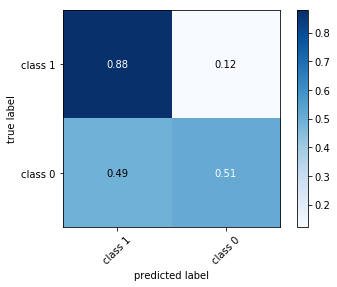

the confusion matrix:  [[845 116]
 [543 564]]
The ROC-AUC score for the test set is:  0.7268149471626657
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1224
           1       0.75      0.59      0.66       856

    accuracy                           0.75      2080
   macro avg       0.75      0.73      0.73      2080
weighted avg       0.75      0.75      0.74      2080



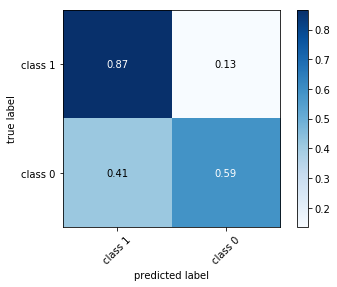

the confusion matrix:  [[1060  164]
 [ 353  503]]
---------------------------------------------------------------
##############################
Doc2vec_ 2  - model name:  pvdm  params:  (500, 50, 5)
##############################
CPU times: user 4min 7s, sys: 3.31 s, total: 4min 11s
Wall time: 4min 11s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 210.5min finished


Best: 0.570151 using {'clf__metric': 'minkowski', 'clf__n_neighbors': 31}
The ROC-AUC score for the test set is:  0.5291499463728595
              precision    recall  f1-score   support

           0       0.48      0.75      0.59       961
           1       0.59      0.31      0.40      1107

    accuracy                           0.51      2068
   macro avg       0.54      0.53      0.50      2068
weighted avg       0.54      0.51      0.49      2068



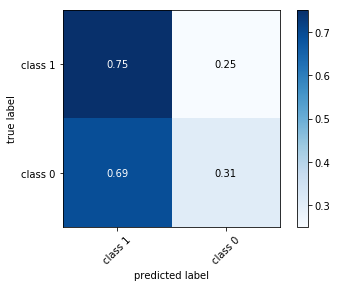

the confusion matrix:  [[721 240]
 [766 341]]
The ROC-AUC score for the test set is:  0.5392653167185877
              precision    recall  f1-score   support

           0       0.62      0.72      0.66      1224
           1       0.47      0.36      0.41       856

    accuracy                           0.57      2080
   macro avg       0.54      0.54      0.54      2080
weighted avg       0.56      0.57      0.56      2080



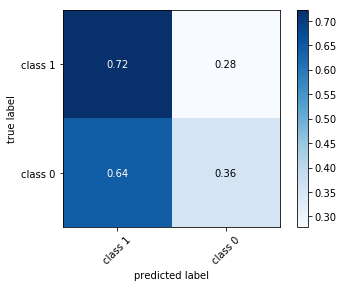

the confusion matrix:  [[884 340]
 [551 305]]
---------------------------------------------------------------
##############################
Doc2vec_ 3  - model name:  pvdmc  params:  (500, 50, 5)
##############################
CPU times: user 11 s, sys: 184 ms, total: 11.2 s
Wall time: 11.3 s
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
baselines = ['logistic_regression', 'svm', 'knn']

best_model_vec1 = dict()
best_model_vec2 = dict()

for eachModel in baselines:
    print('#' * 50)
    print('Executing ', eachModel, ' pipeline...')
    print('#' * 50)
    best_model_vec_i, best_model_vec_j = doc2vec_documentlevel(eachModel, df_data, df_testdata, df_testdata2)
    
    key = max(best_model_vec_i.items(), key=operator.itemgetter(1))[0]
    value = max(best_model_vec_i.items(), key=operator.itemgetter(1))[1]
    
    best_model_vec1[key] = value
    
    
    key2 = max(best_model_vec_j.items(), key=operator.itemgetter(1))[0]
    value2 = max(best_model_vec_j.items(), key=operator.itemgetter(1))[1]
    
    best_model_vec2[key2] = value2

In [ ]:
print(best_model_vec1)
print(best_model_vec2)